In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import os
import gc
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

import warnings
warnings.filterwarnings("ignore")

In [2]:
def build_df(LST_no_sensor, subject):    
    path = './DB_B_preproceesed/'  
    
    file_list = os.listdir(path)
    data_pool = {}
    if subject < 10:    
        for gesture in range(1,9):
            for trial in range(1,11): 
                if trial < 10:
                    data_pool['data_S{}_G{}_T{}'.format(subject, gesture, trial)] = scipy.io.loadmat(path + file_list[subject-1] + 
                                                                '/00{}-00{}-00{}.mat'.format(subject, gesture, trial))['data'].T
                else:
                    data_pool['data_S{}_G{}_T10'.format(subject, gesture)] = scipy.io.loadmat(path + file_list[subject-1] + 
                                                                '/00{}-00{}-010.mat'.format(subject, gesture))['data'].T
    
    elif subject >= 10:    
        for gesture in range(1,9):
            for trial in range(1,11): 
                if trial < 10:
                    data_pool['data_S{}_G{}_T{}'.format(subject, gesture, trial)] = scipy.io.loadmat(path + file_list[subject-1] + 
                                                                    '/0{}-00{}-00{}.mat'.format(subject, gesture, trial))['data'].T
                else:
                    data_pool['data_S{}_G{}_T10'.format(subject, gesture)] = scipy.io.loadmat(path + file_list[subject-1] + 
                                                                    '/0{}-00{}-010.mat'.format(subject, gesture))['data'].T
    
    div_len = 1000 
    total_data, label_lst = [], []
    list_trials = np.sort(random.sample(np.arange(1,11).tolist(), 3)).tolist() #  Select three gestures

    for gesture in range(1,9):
        for trial in list_trials:
            for idx in range(1):  #250 * 4 = 1000
                for sensor in LST_no_sensor: #128
                    data_tmp = data_pool['data_S{}_G{}_T{}'.format(subject, gesture, trial)][sensor][div_len*idx:div_len*(idx+1)].tolist()
                    total_data.append(data_tmp) 
                    label_lst.append(gesture-1)

    df = pd.DataFrame(total_data)
    df['Label'] = label_lst
    
    return df

In [3]:
def build_graph_works_larger_than_16(df, LST_no_sensor):
    electrodes = {}
    row_sensor = 8
    for i in range(row_sensor,len(LST_no_sensor)-row_sensor):
        if i%8 == 0: electrodes['lst_{}'.format(i)]=[i-row_sensor, i-(row_sensor-1), i+1, i+row_sensor, i+row_sensor+1]

        elif i%8 == 7: electrodes['lst_{}'.format(i)]=[i-row_sensor, i-(row_sensor+1), i-1, i+(row_sensor-1), i+row_sensor]

        else: electrodes['lst_{}'.format(i)]=[i-(row_sensor+1), i-row_sensor, i-(row_sensor-1), 
                                             i-1, i+1, i+(row_sensor-1), i+row_sensor, i+row_sensor+1]

    for i in range(row_sensor):
        if i==0: electrodes['lst_{}'.format(i)]=[1,row_sensor,row_sensor+1,len(LST_no_sensor)-row_sensor,len(LST_no_sensor)-row_sensor+1]
        elif i==row_sensor-1: electrodes['lst_{}'.format(i)]=[row_sensor-2,row_sensor*2-2,row_sensor*2-1,len(LST_no_sensor)-2,len(LST_no_sensor)-1]
        else: electrodes['lst_{}'.format(i)]=[i-1, i+1, i+row_sensor-1, i+row_sensor, i+row_sensor+1, i+len(LST_no_sensor)-row_sensor-1, i+len(LST_no_sensor)-row_sensor, i+len(LST_no_sensor)-row_sensor+1]

    for i in range(len(LST_no_sensor)-row_sensor, len(LST_no_sensor)):  
        if i==len(LST_no_sensor)-row_sensor: electrodes['lst_{}'.format(i)]=[i-row_sensor,i-row_sensor+1,i+1,0,1]
        elif i==len(LST_no_sensor)-1: electrodes['lst_{}'.format(i)]=[i-row_sensor-1, i-row_sensor, i-1, row_sensor-2, row_sensor-1]
        else: electrodes['lst_{}'.format(i)]=[i-1, i-row_sensor-1, i-row_sensor, i-row_sensor+1, i+1, i-len(LST_no_sensor)-row_sensor+1, i-len(LST_no_sensor), i-len(LST_no_sensor)-row_sensor-1]
    
    for i in range(row_sensor):
        if i%row_sensor==0: electrodes['lst_{}'.format(i)]=[2,row_sensor+2,0,1,row_sensor+4] 
        elif i%row_sensor==1: electrodes['lst_{}'.format(i)]=[3,row_sensor+3,0,1,2,3,row_sensor+5] 
        elif i%row_sensor==6: electrodes['lst_{}'.format(i)]=[4,row_sensor+4,row_sensor-3,row_sensor-2,row_sensor-1,row_sensor,row_sensor+1,row_sensor+2,row_sensor+3]  
        elif i%row_sensor==7: electrodes['lst_{}'.format(i)]=[5,row_sensor+5,row_sensor-2,row_sensor-1,3,row_sensor+3,row_sensor+2,row_sensor+1]

    for i in range(8,16):
        if i%row_sensor==0: electrodes['lst_{}'.format(i)]=[2,row_sensor+2,row_sensor,row_sensor+1,row_sensor+2,row_sensor-2,row_sensor-3,4]
        elif i%row_sensor==1: electrodes['lst_{}'.format(i)]=[3,row_sensor+3,3,row_sensor,row_sensor+1,row_sensor+2,row_sensor+3,row_sensor-1,row_sensor-2,row_sensor-3]
        elif i%row_sensor==(row_sensor-2): electrodes['lst_{}'.format(i)]=[4,row_sensor+4,row_sensor+5,row_sensor+6,row_sensor+7,3,2,1]
        elif i%row_sensor==(row_sensor-1): electrodes['lst_{}'.format(i)]=[5,row_sensor+5,row_sensor+6,row_sensor+7,3,2,1]
            
    lst_tmp_1, lst_tmp_2, num_cnt = [], [], 0

    for sensors in range(len(LST_no_sensor)):
        for i in range(len(electrodes['lst_{}'.format(sensors)])):
            lst_tmp_1.append(sensors)
            lst_tmp_2.append(electrodes['lst_{}'.format(sensors)][i])

    lst1_final, lst2_final = [], []

    lst1_final = lst1_final + lst_tmp_1 #처음 은 +127안해줌
    lst2_final = lst2_final + lst_tmp_2

    for i in range(int(len(df)/len(LST_no_sensor))-1):
        for idx in range(len(lst_tmp_1)):
            lst_tmp_1[idx] = lst_tmp_1[idx] + len(LST_no_sensor)
            lst_tmp_2[idx] = lst_tmp_2[idx] + len(LST_no_sensor)   

        lst1_final = lst1_final + lst_tmp_1
        lst2_final = lst2_final + lst_tmp_2
        
        for k in range(len(LST_no_sensor)):  #SW 부분
            lst2_final.append((i+1)*len(LST_no_sensor) + k)  #128, 129
            lst1_final.append(num_cnt)
            num_cnt = num_cnt + 1

    graph1 = pd.DataFrame({'source':lst1_final, 'target':lst2_final })
    train_data = df.sample(frac=1)
    feature_names = list(set(df.columns) - {"Label"})7
    x_train = train_data[feature_names].to_numpy()
    y_train = train_data["Label"]

    edges = graph1[["source", "target"]].to_numpy().T
    edge_weights = tf.ones(shape=edges.shape[1])
    node_features = tf.cast(df[feature_names].to_numpy(), dtype=tf.dtypes.float32)
    graph_info = (node_features, edges, edge_weights) # Create graph info tuple with node_features, edges, and edge_weights.

    print("Edges shape:", edges.shape, "     Nodes shape:", node_features.shape)
    
    x_train = train_data.index.to_numpy()
    
    return graph1, graph_info, x_train, y_train

In [4]:
def draw_graph(graph1):
    import networkx as nx

    plt.figure(figsize=(6, 6))
    cora_graph = nx.from_pandas_edgelist(graph1[:300])
    nx.draw_spring(cora_graph, node_size=10, node_color='blue')

In [5]:
def plot(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"], marker='o', markersize=2)
    ax1.plot(history.history["val_loss"], marker='o', markersize=2)
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.grid() 
    
    ax2.plot(history.history["acc"], marker='o', markersize=2)
    ax2.plot(history.history["val_acc"], marker='o', markersize=2)
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.grid() 
    
    plt.show()

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [11]:
def build_gnn_model(graph_metadata, num_classes, hidden_units, dropout_rate):
    import model
    
    GCN = model.GNNNodeClassifier(
        graph_info=graph_metadata,
        num_classes=num_classes,
        hidden_units=hidden_units,
        dropout_rate=dropout_rate,
        name="GCN_Capgmyo type A",
    )
    
    GCN.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )

    return GCN

In [12]:
hidden_units_GRU = 256 #[128, 128]
hidden_units = [128, 128]
learning_rate = 0.002
dropout_rate = 0.15
num_epochs = 50
batch_size = 128
num_classes = 8

Start subject 1, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


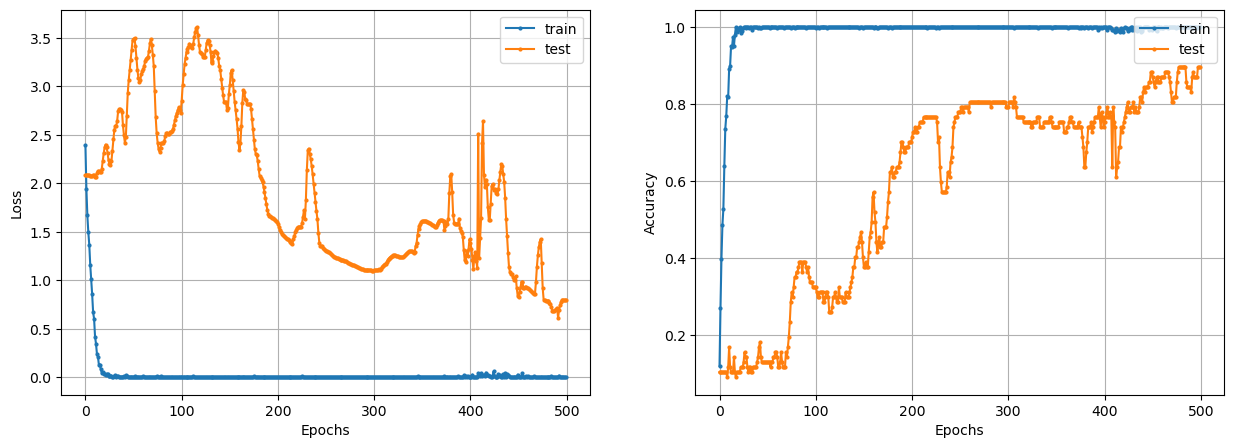

0.8961039185523987 0.6125941872596741
Start subject 1, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


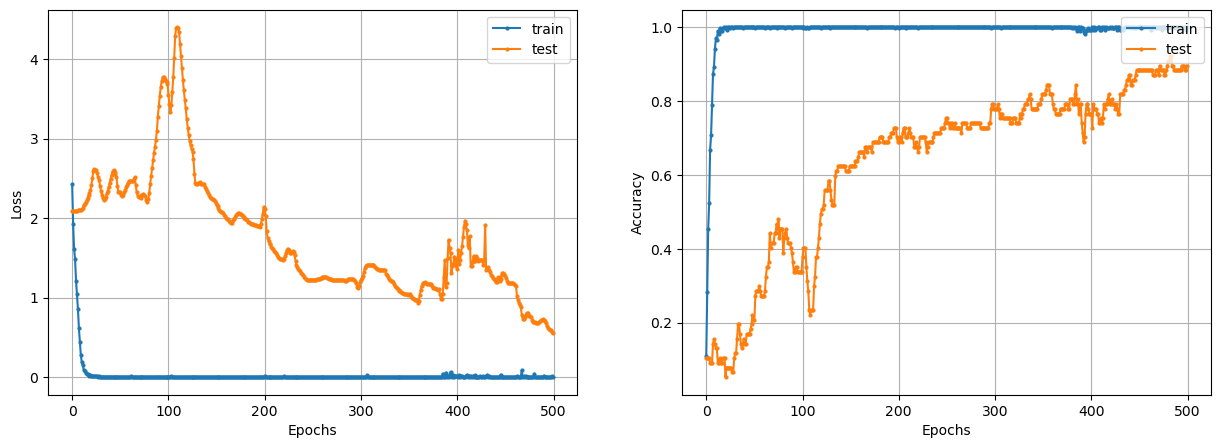

0.9220778942108154 0.5606909394264221
Start subject 1, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


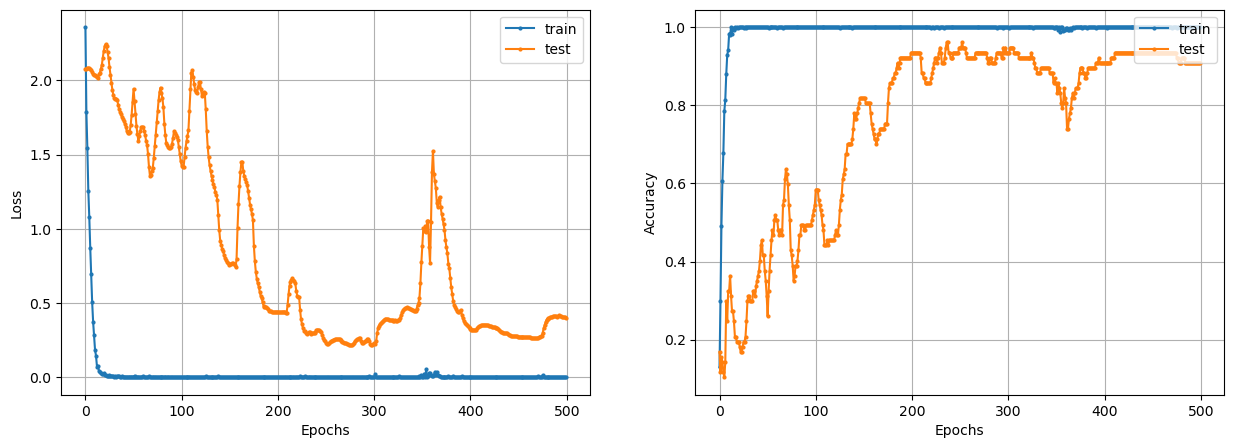

0.9610389471054077 0.2154136300086975
Start subject 1, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


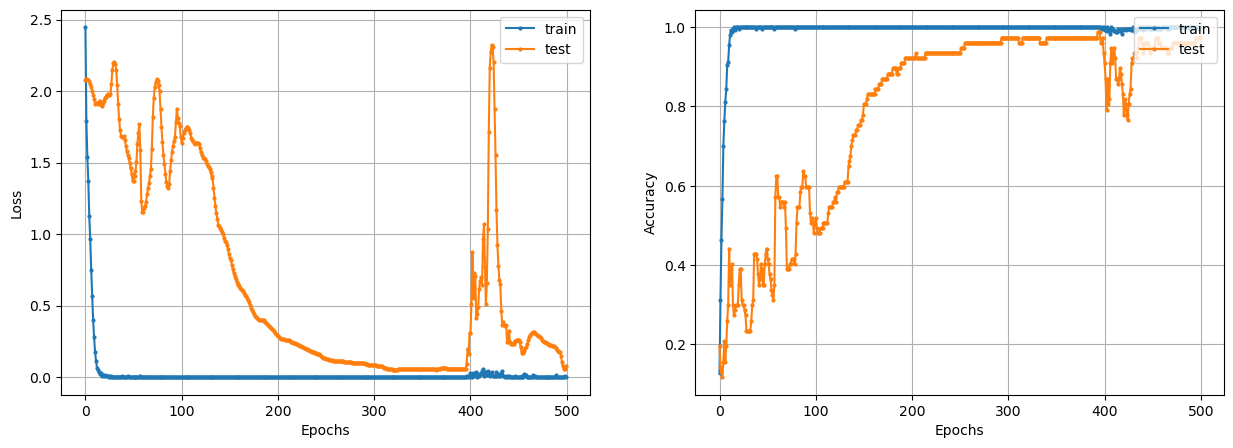

0.9870129823684692 0.05324931442737579
Start subject 1, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


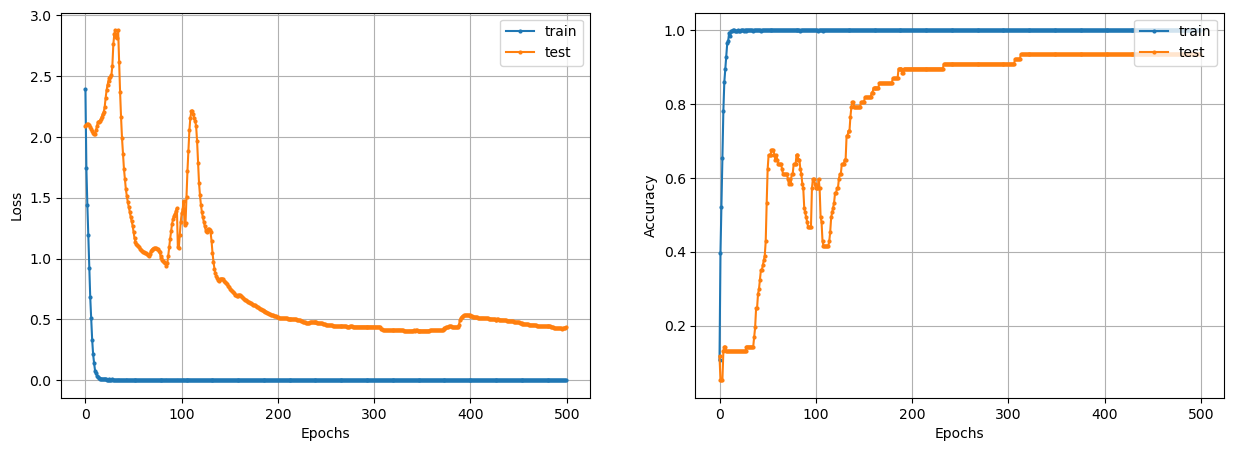

0.9350649118423462 0.4057811498641968
Start subject 1, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


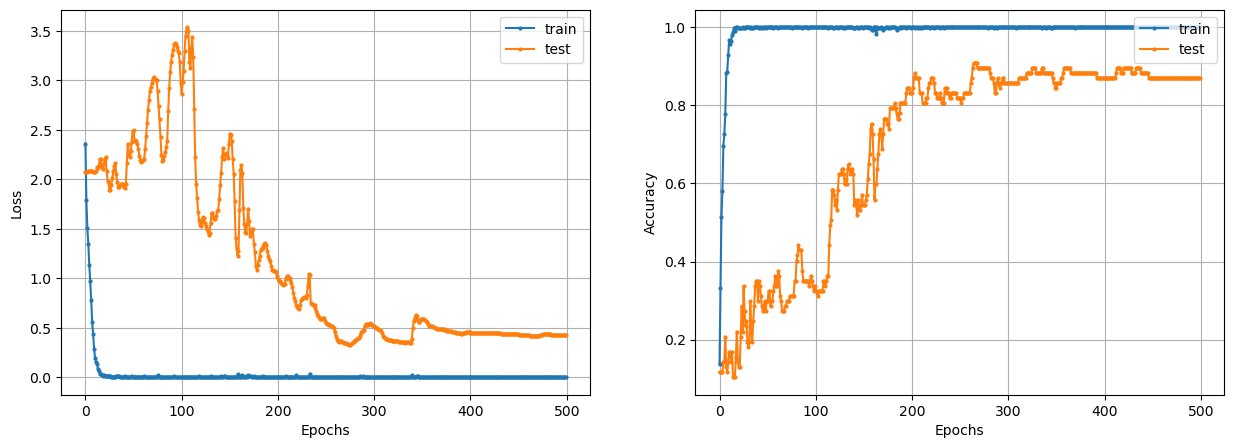

0.9090909361839294 0.32399266958236694
Start subject 1, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


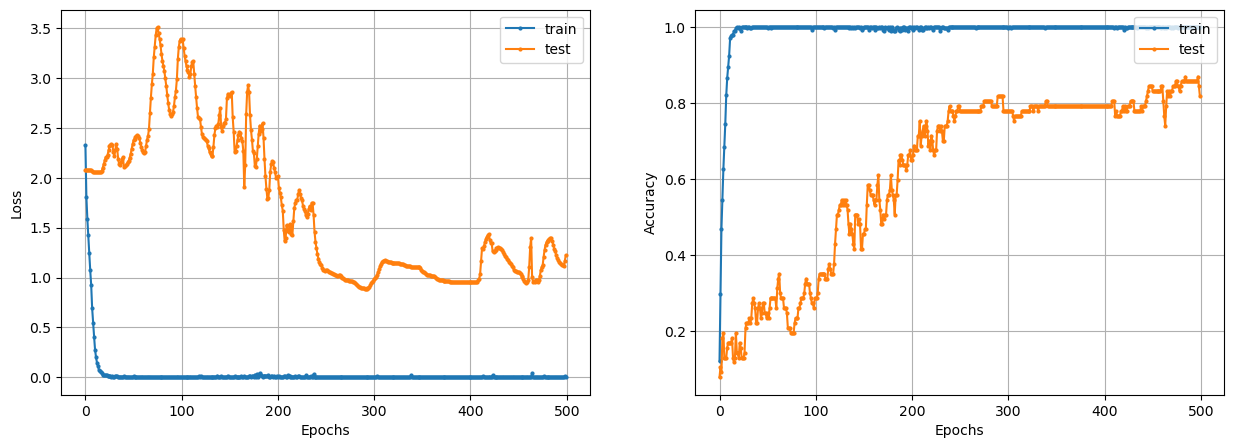

0.8701298832893372 0.8843639492988586
Start subject 1, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


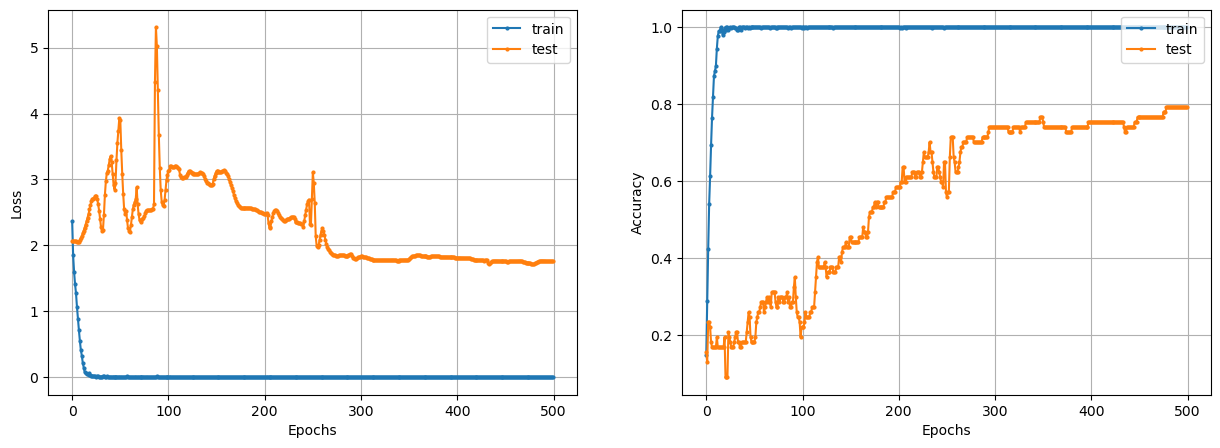

0.7922077775001526 1.7168186902999878
Start subject 2, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


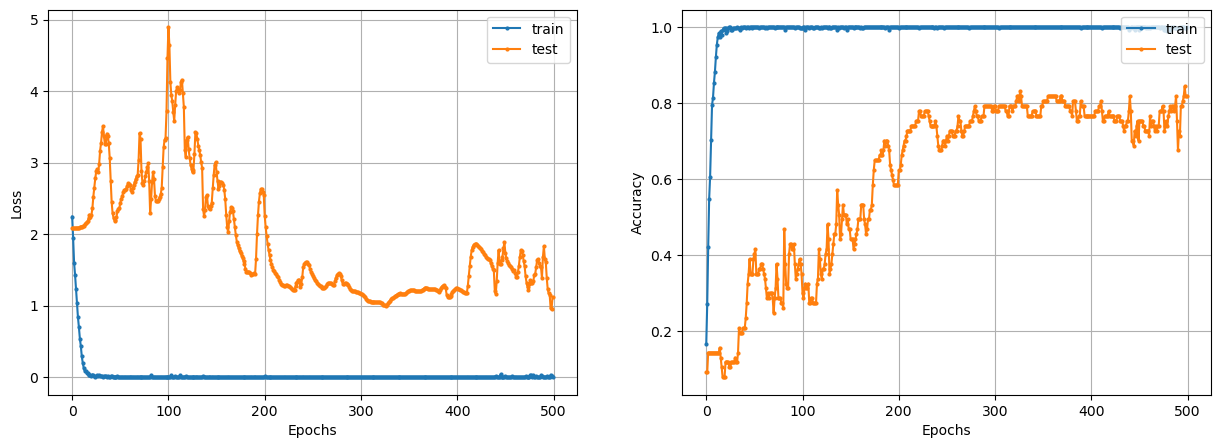

0.8441558480262756 0.9584254622459412
Start subject 2, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


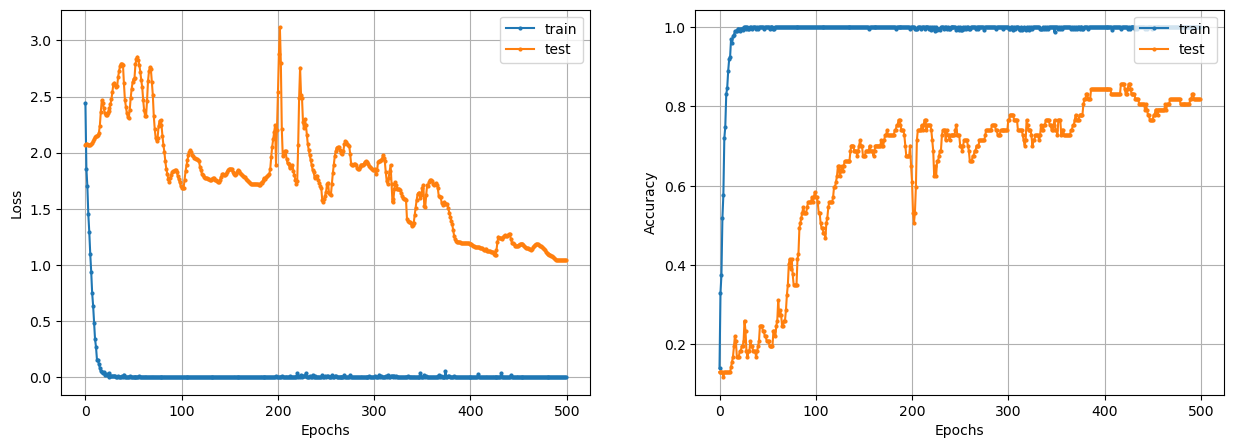

0.8571428656578064 1.040389060974121
Start subject 2, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


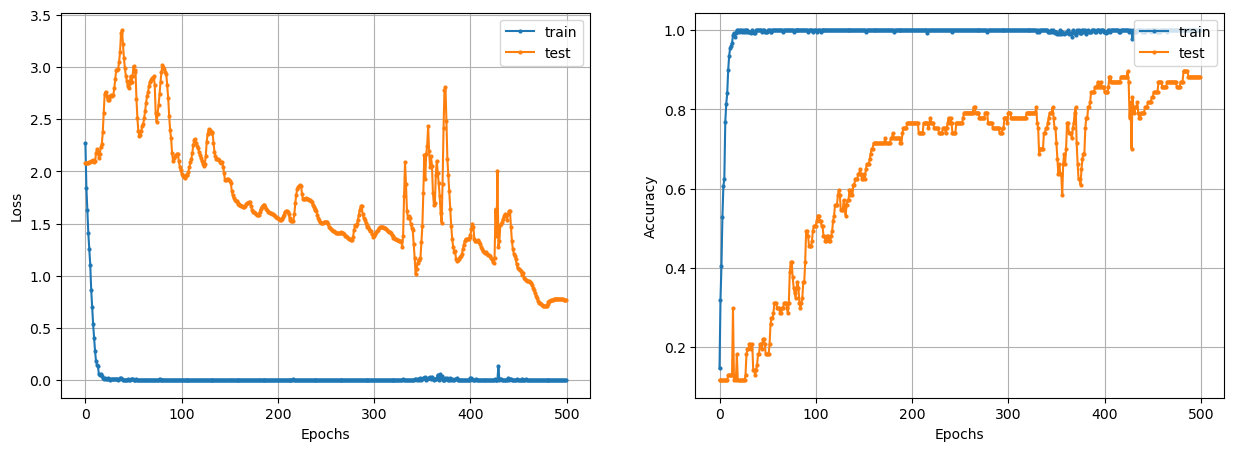

0.8961039185523987 0.7098214626312256
Start subject 2, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


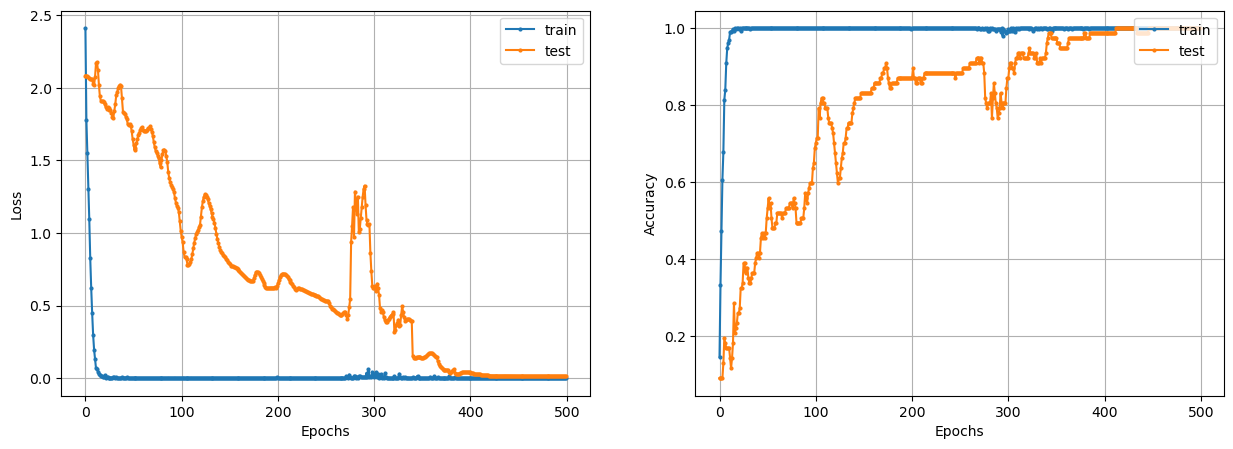

1.0 0.013471047393977642
Start subject 2, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


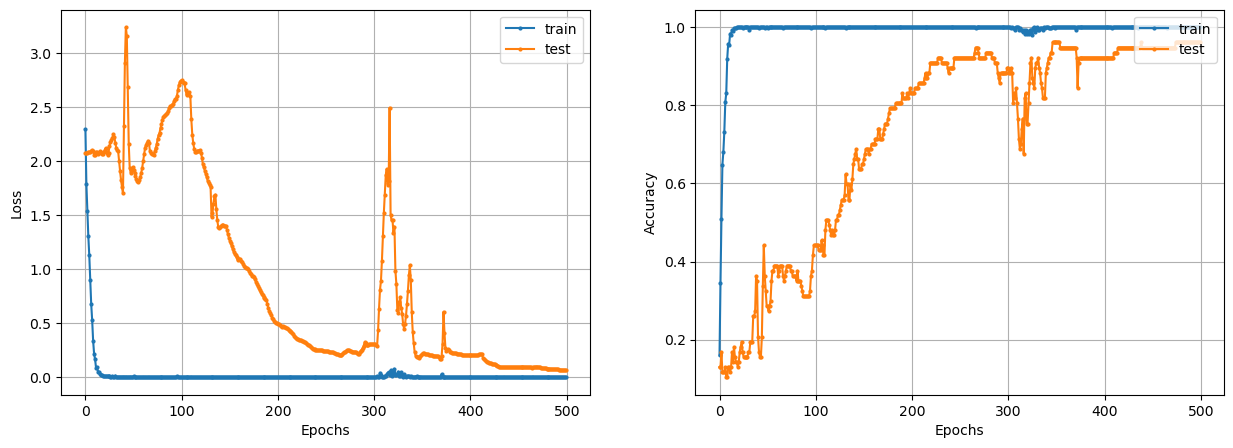

0.9610389471054077 0.06684708595275879
Start subject 2, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


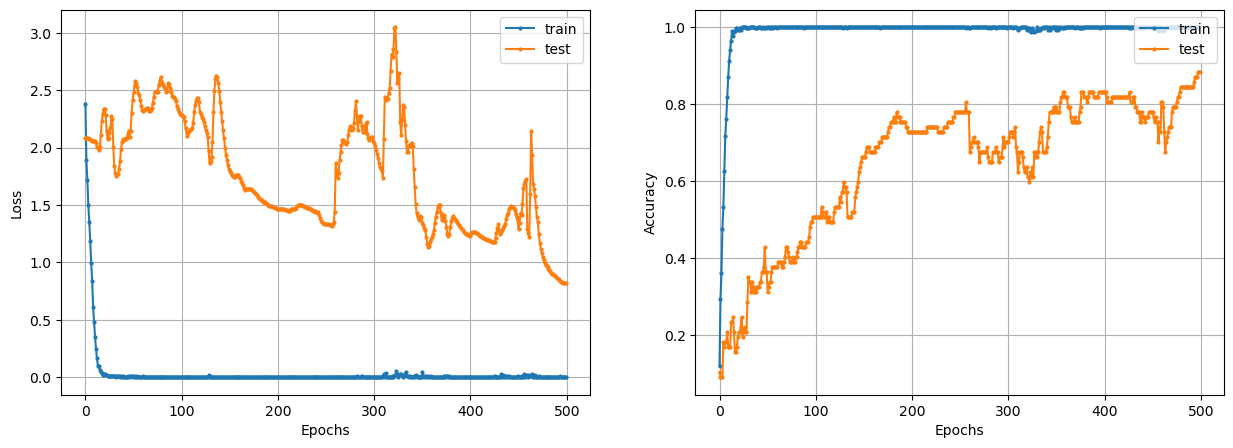

0.8831169009208679 0.8188124299049377
Start subject 2, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


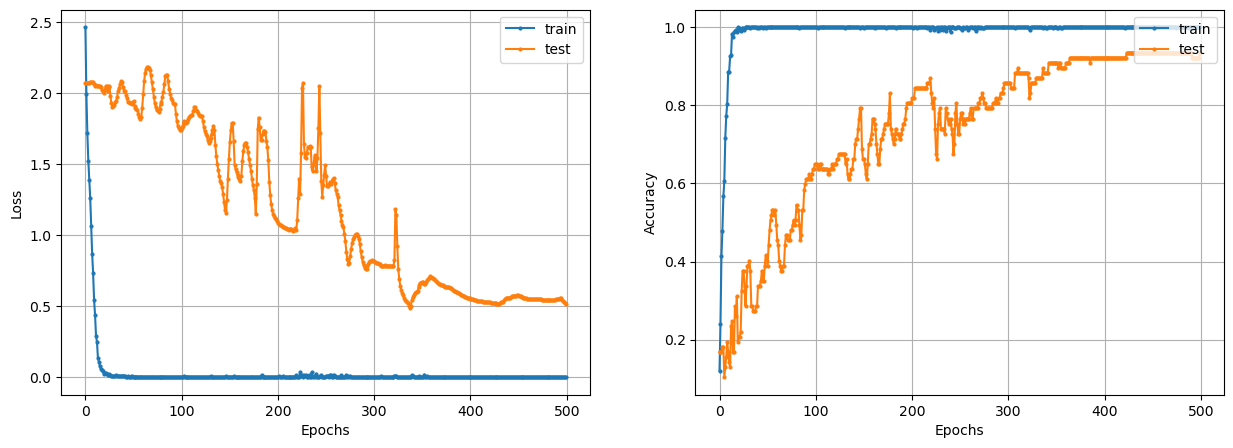

0.9350649118423462 0.4904194176197052
Start subject 2, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


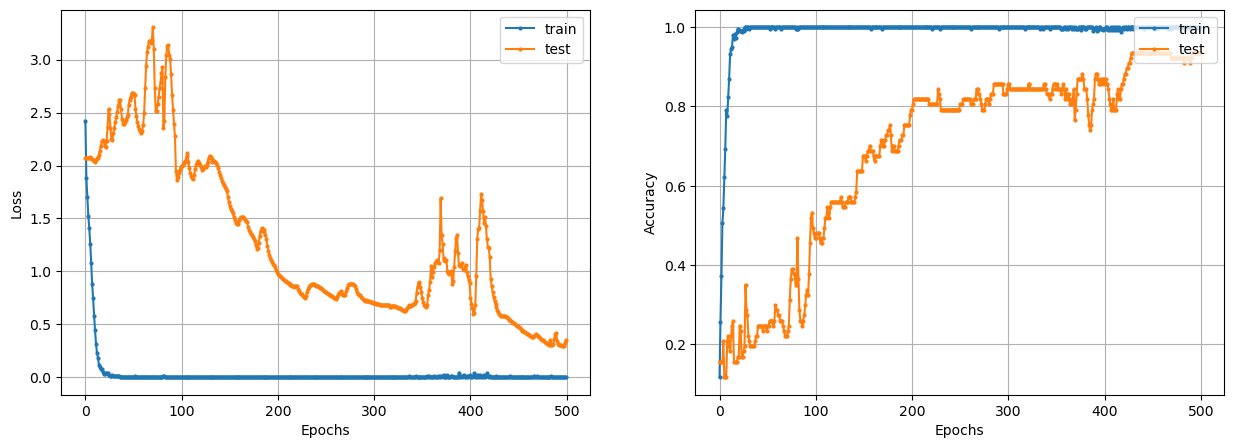

0.9350649118423462 0.29462510347366333
Start subject 3, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


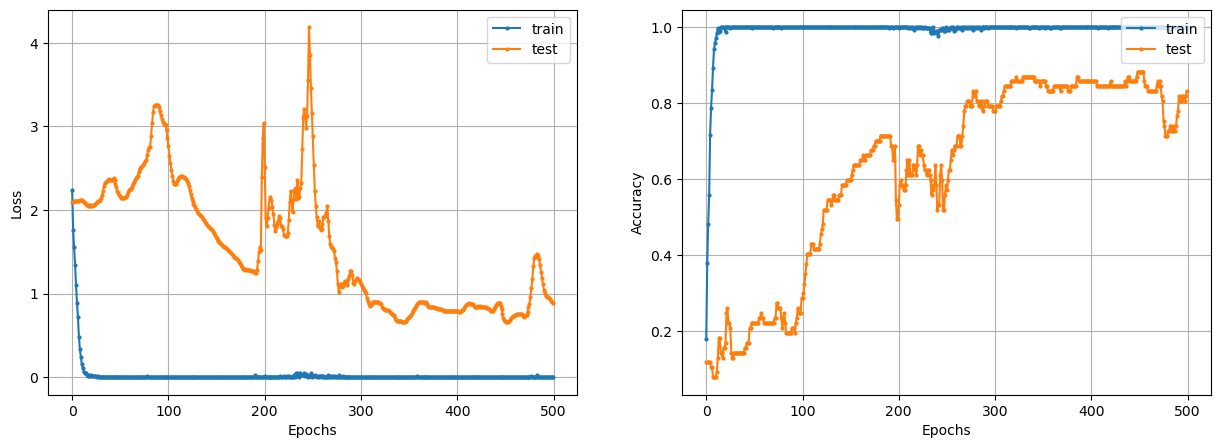

0.8831169009208679 0.6550754904747009
Start subject 3, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


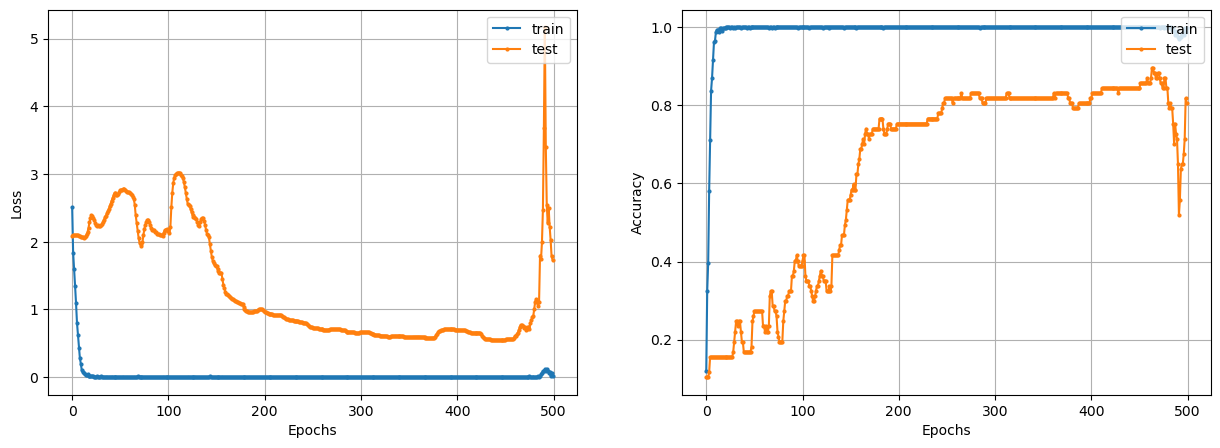

0.8961039185523987 0.547380805015564
Start subject 3, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


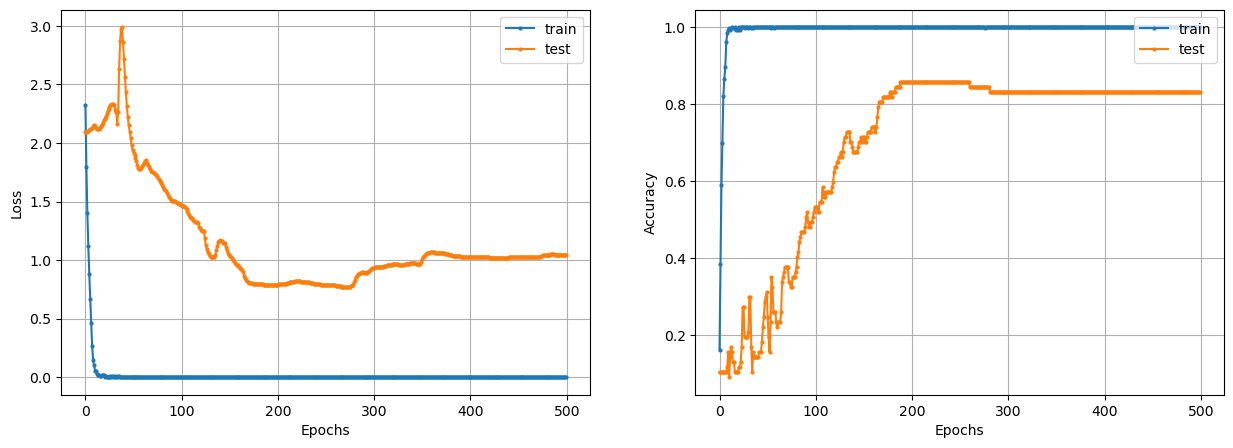

0.8571428656578064 0.7668117880821228
Start subject 3, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


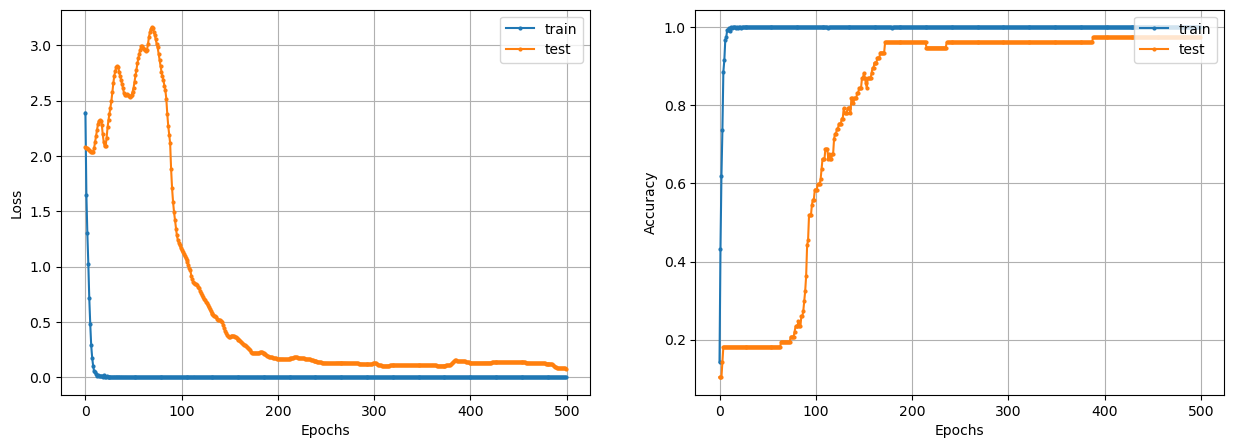

0.9740259647369385 0.07865313440561295
Start subject 3, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


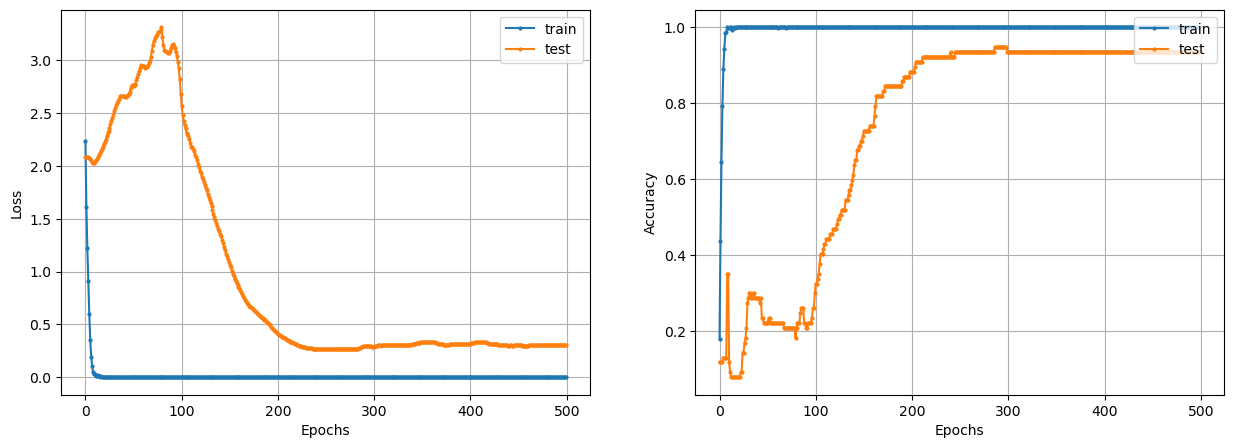

0.948051929473877 0.2630409002304077
Start subject 3, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


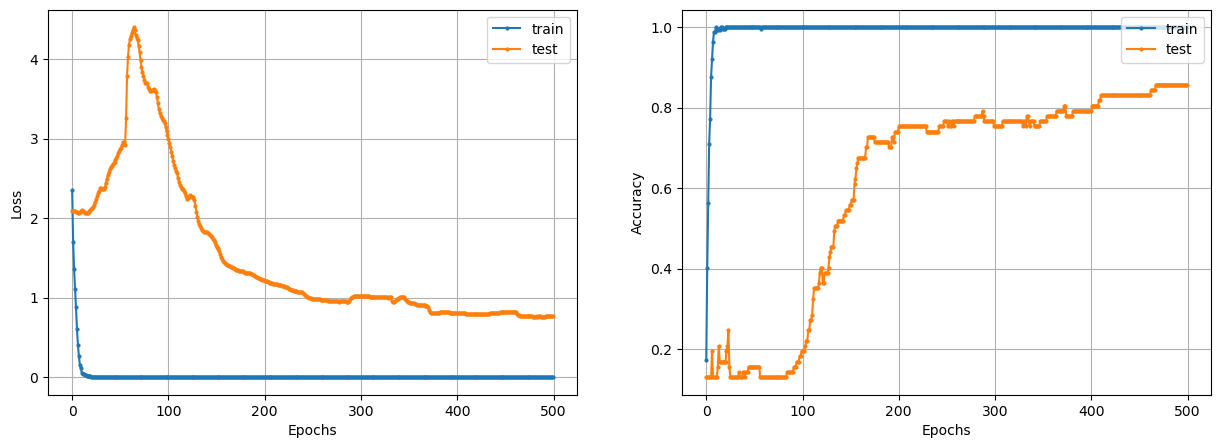

0.8571428656578064 0.7626448273658752
Start subject 3, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


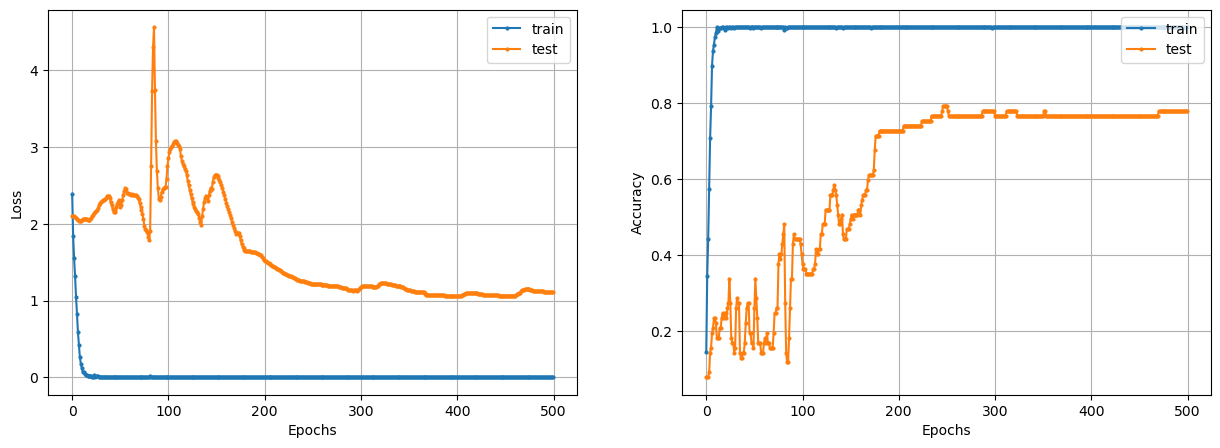

0.7922077775001526 1.0527479648590088
Start subject 3, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


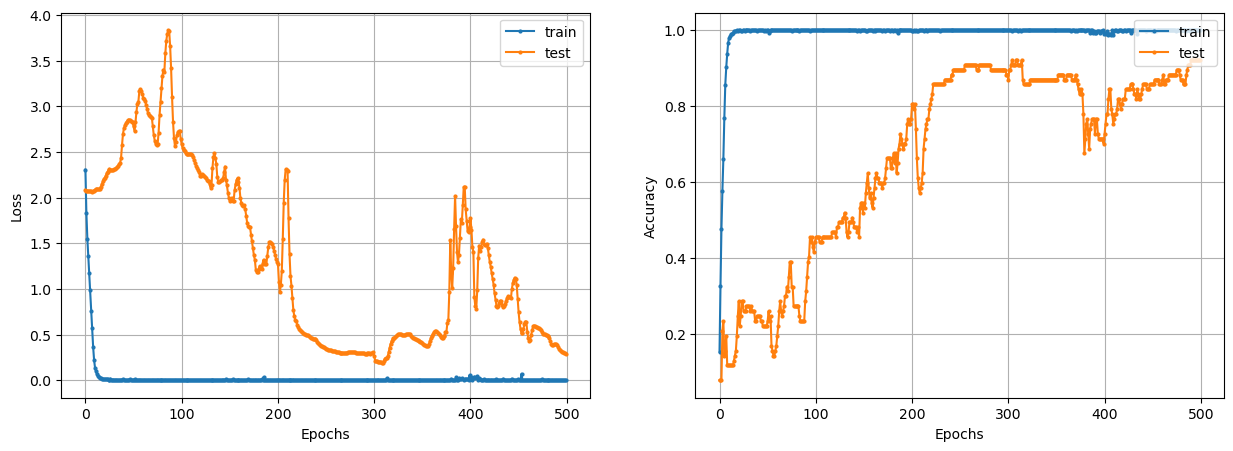

0.9220778942108154 0.18520982563495636
Start subject 4, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


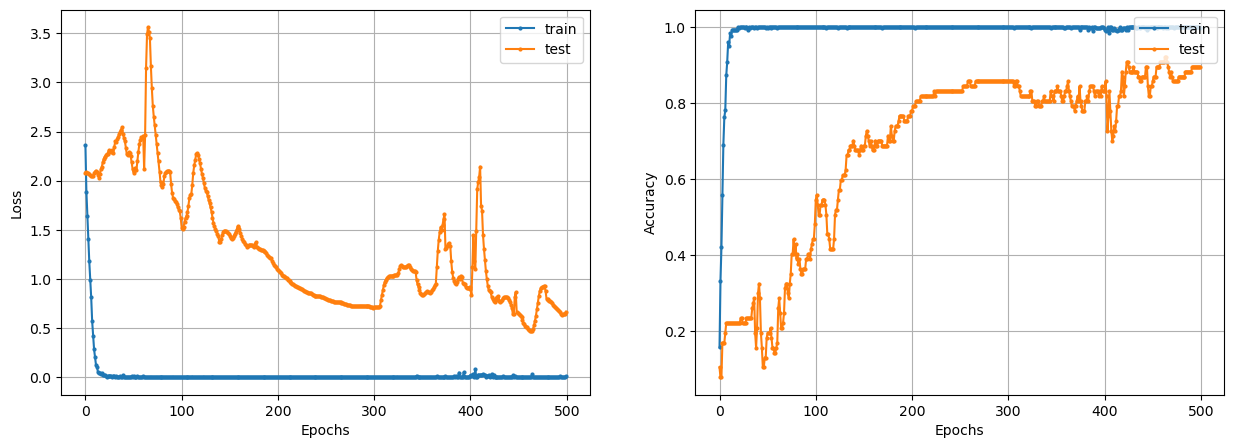

0.9220778942108154 0.46575838327407837
Start subject 4, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


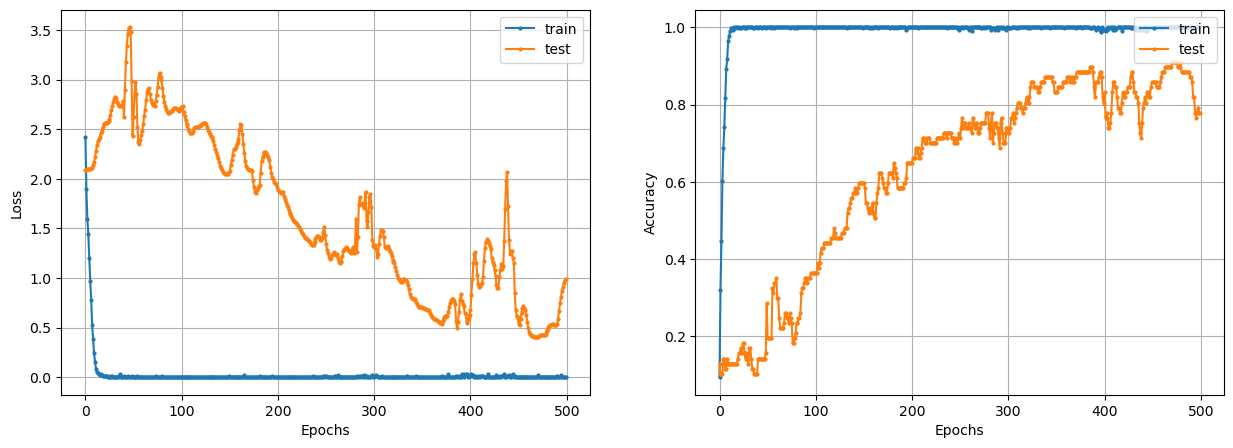

0.9090909361839294 0.40124809741973877
Start subject 4, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


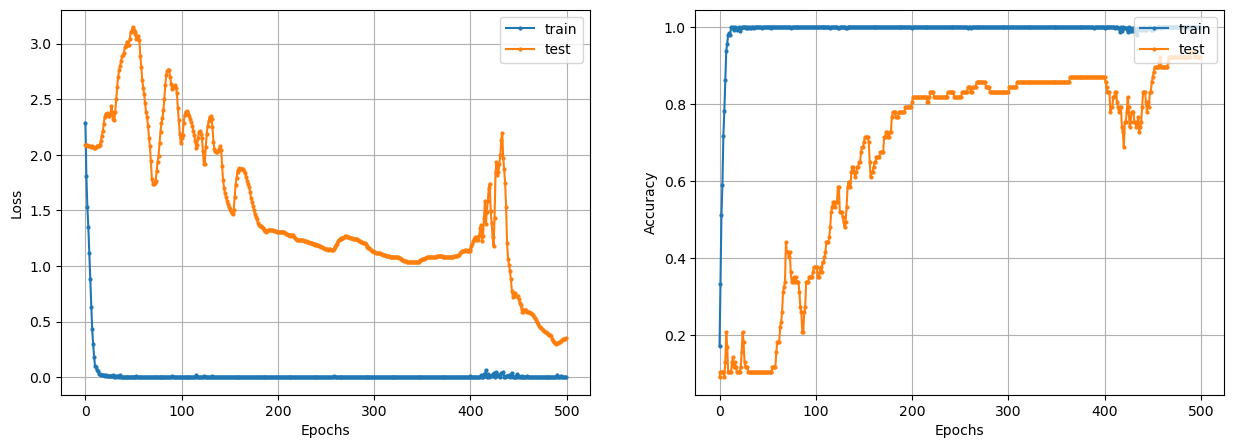

0.9350649118423462 0.3002180755138397
Start subject 4, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


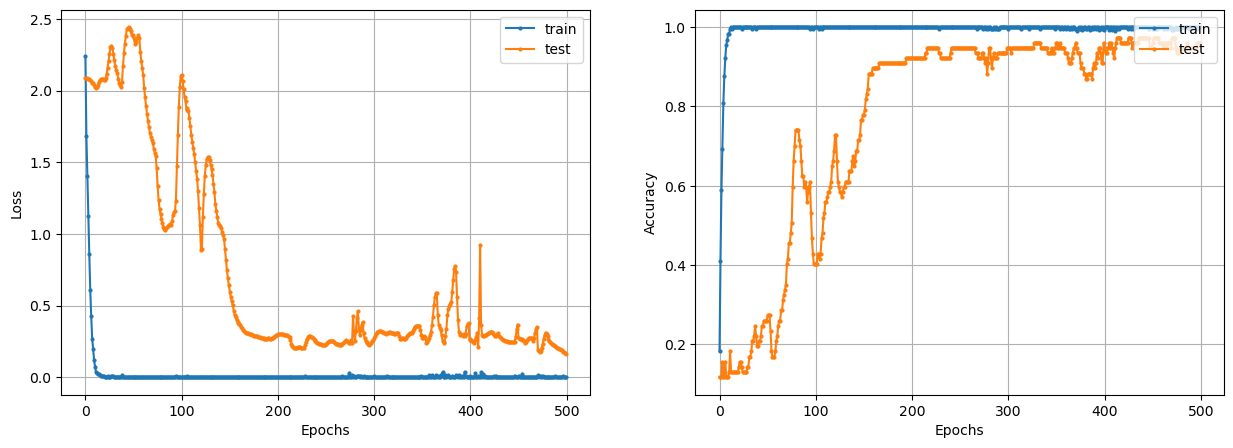

0.9740259647369385 0.1633024960756302
Start subject 4, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


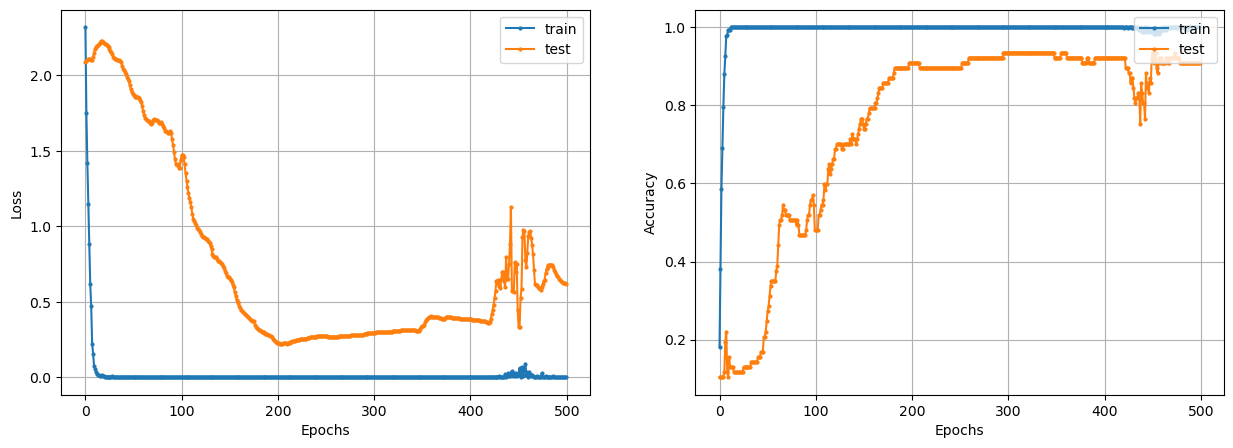

0.9350649118423462 0.2219383865594864
Start subject 4, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


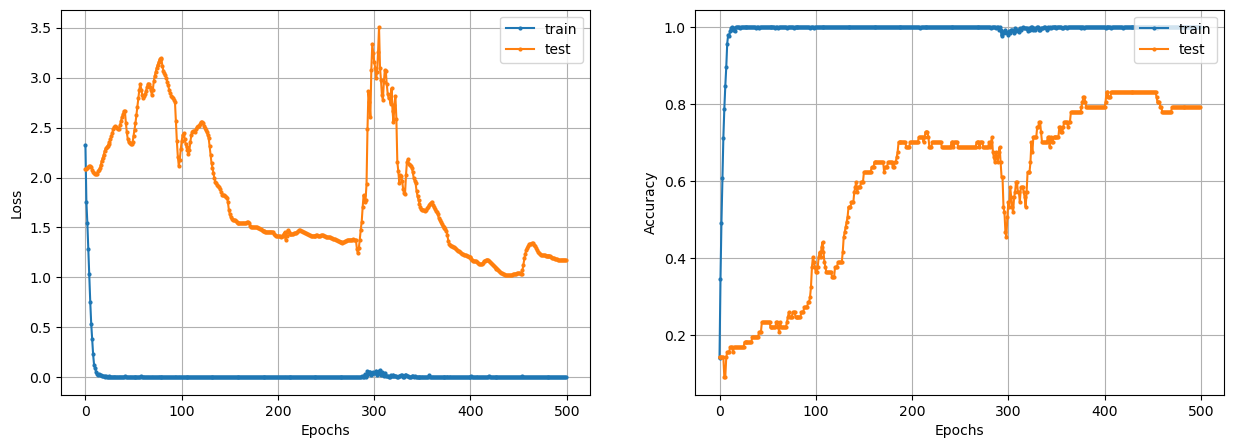

0.8311688303947449 1.0212920904159546
Start subject 4, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


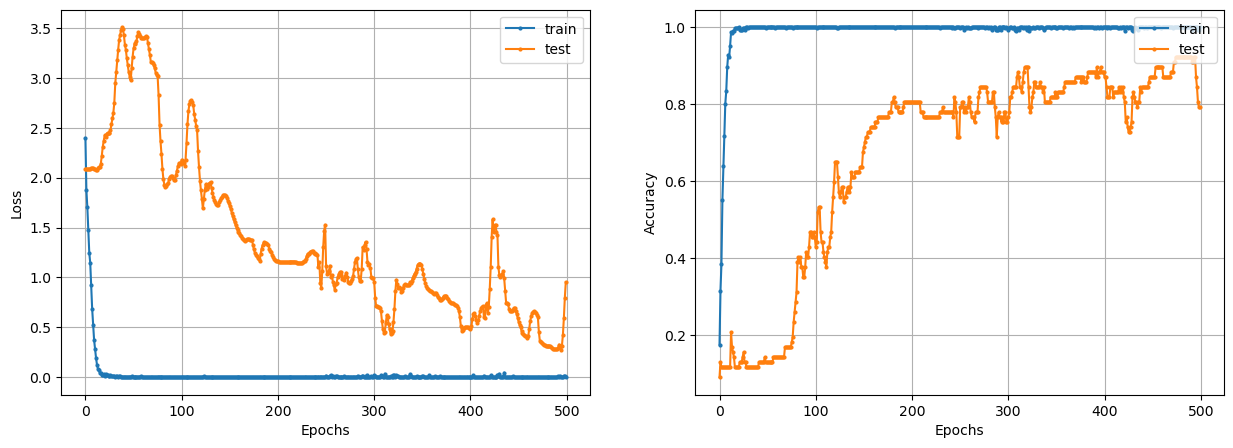

0.9220778942108154 0.2739771008491516
Start subject 4, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


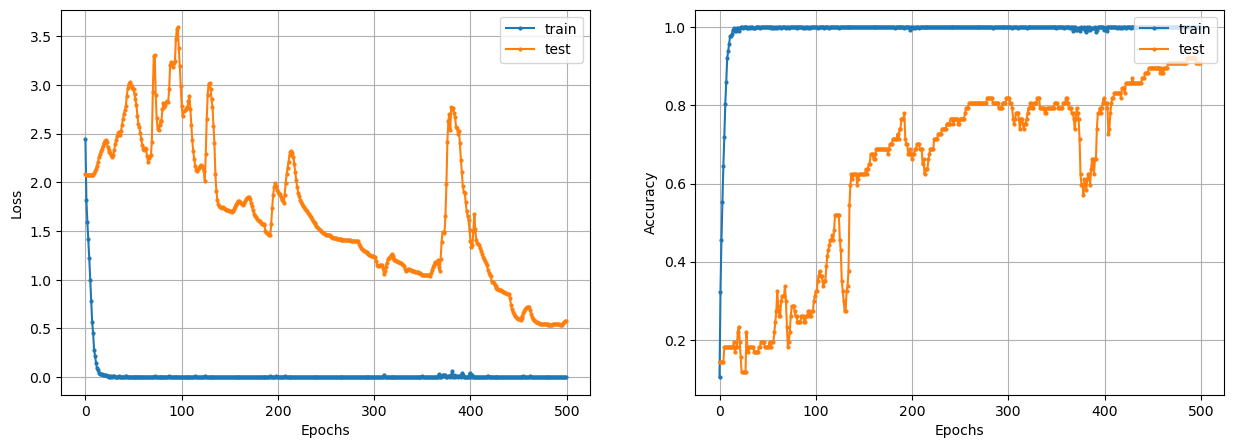

0.9220778942108154 0.5362535715103149
Start subject 5, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


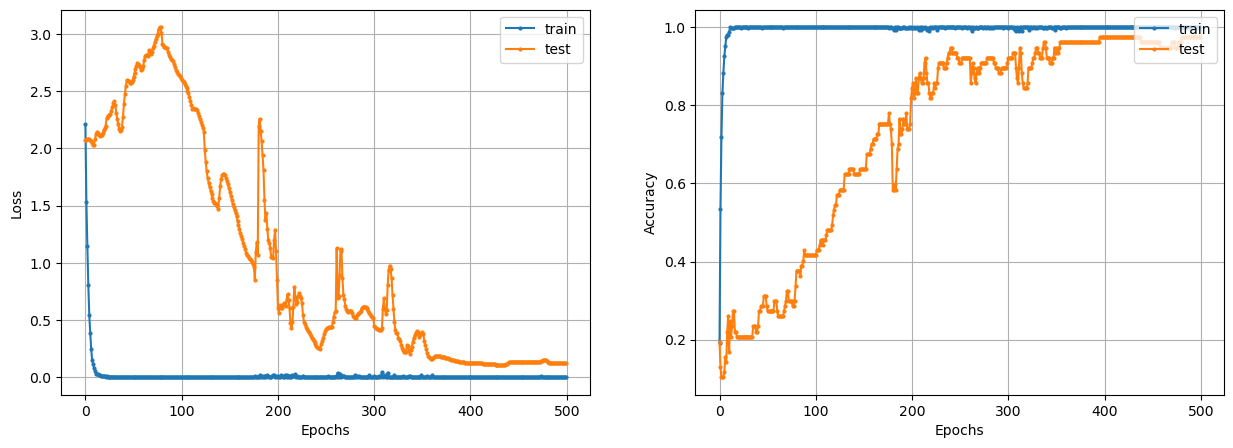

0.9740259647369385 0.10633019357919693
Start subject 5, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


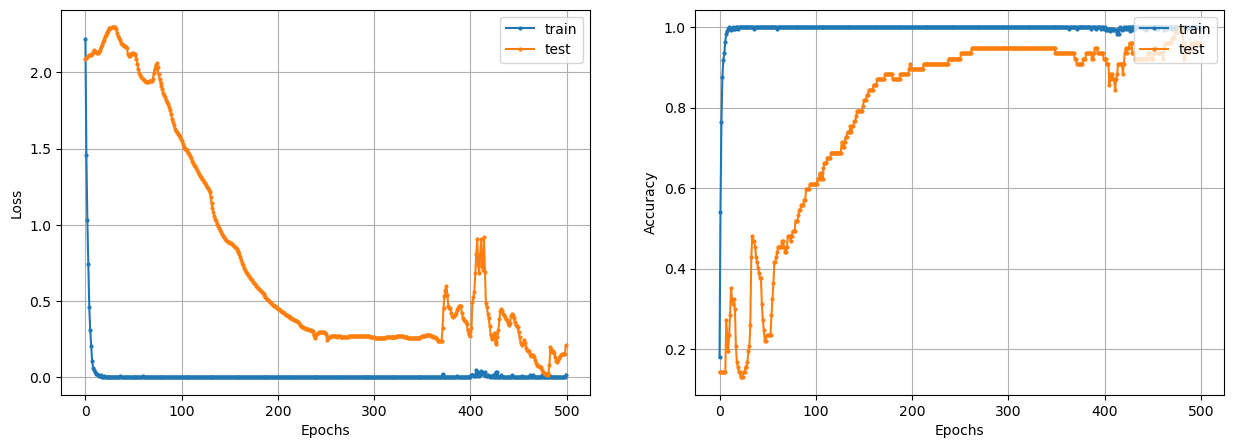

1.0 0.015632230788469315
Start subject 5, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


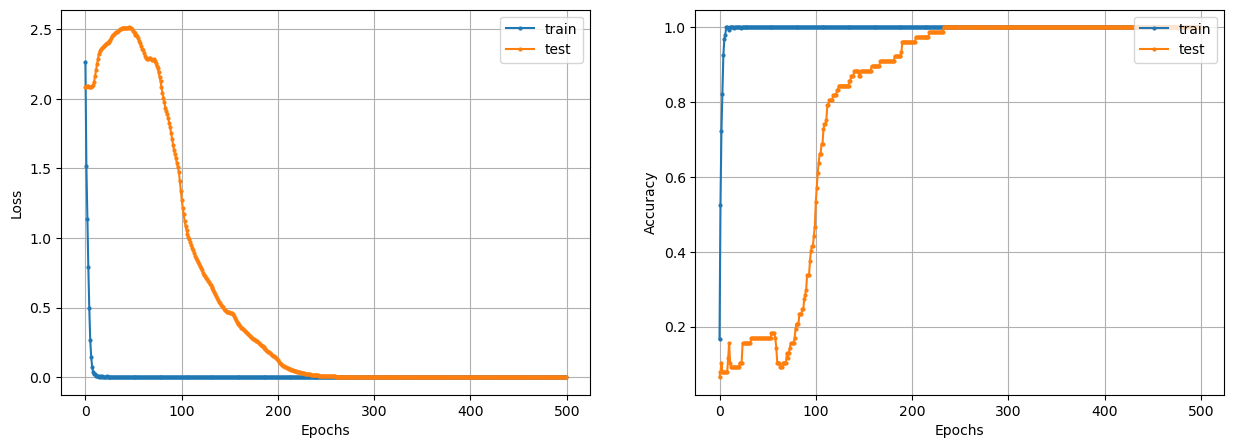

1.0 0.0010055870516225696
Start subject 5, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


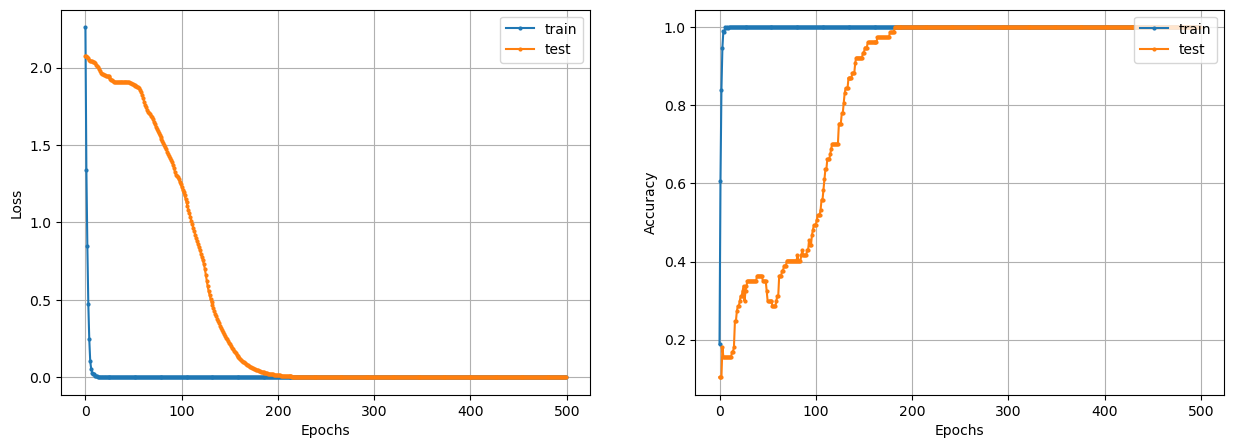

1.0 0.00030344430706463754
Start subject 5, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


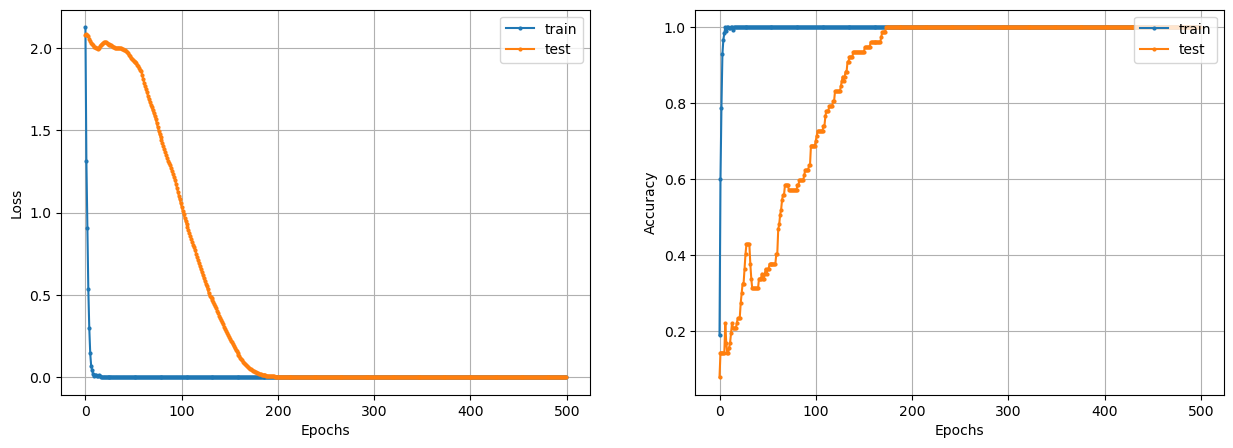

1.0 4.149561209487729e-05
Start subject 5, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


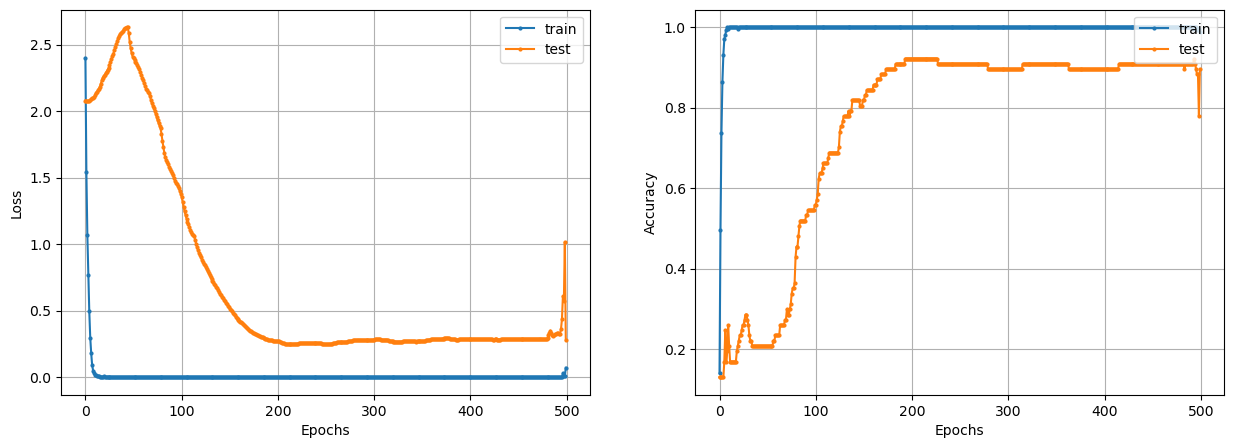

0.9220778942108154 0.24836809933185577
Start subject 5, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


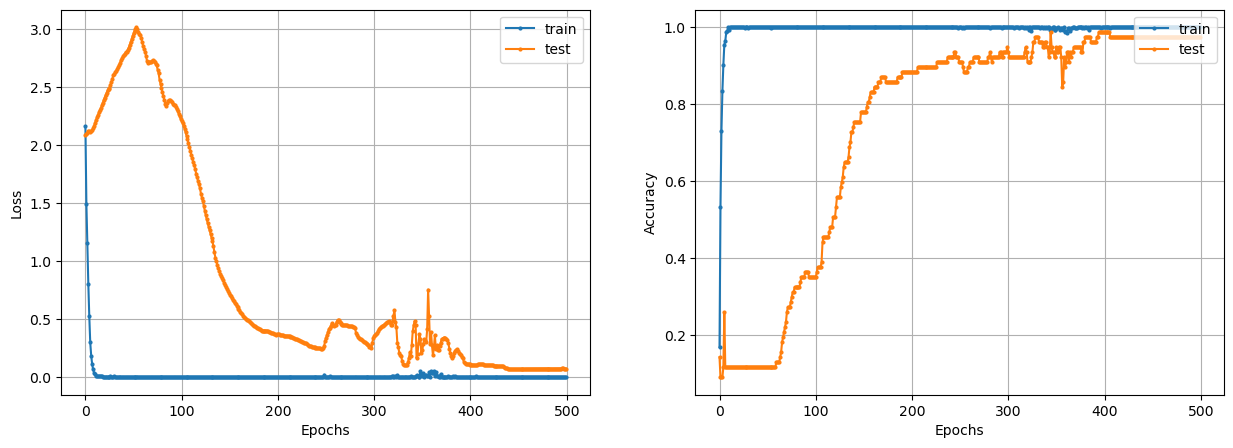

0.9870129823684692 0.06958355009555817
Start subject 5, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


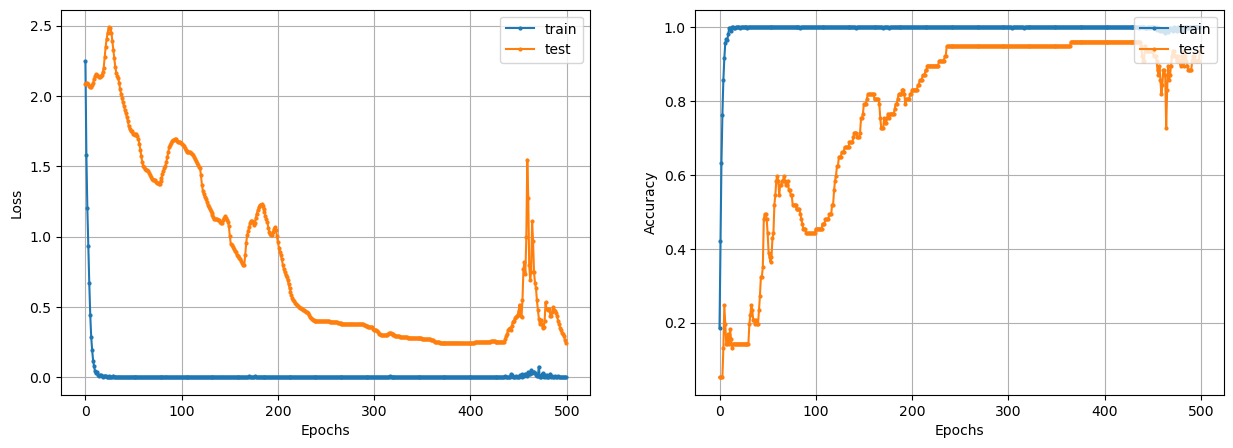

0.9610389471054077 0.2414695918560028
Start subject 6, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


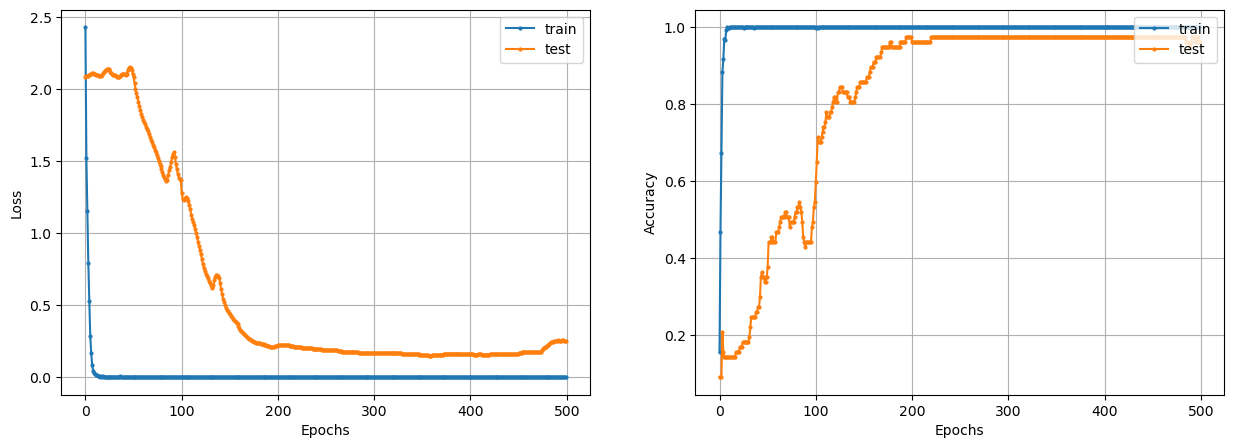

0.9740259647369385 0.15073201060295105
Start subject 6, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


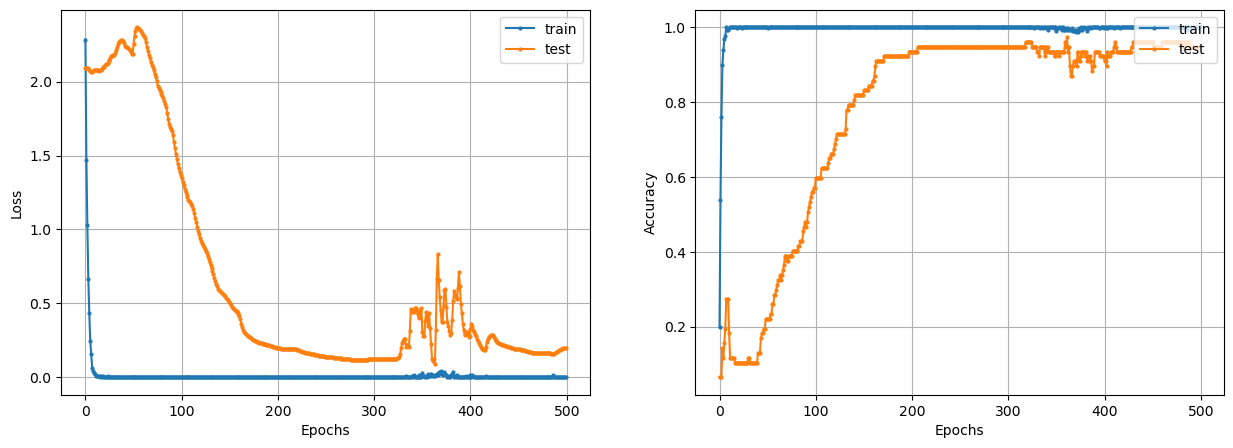

0.9740259647369385 0.08723946660757065
Start subject 6, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


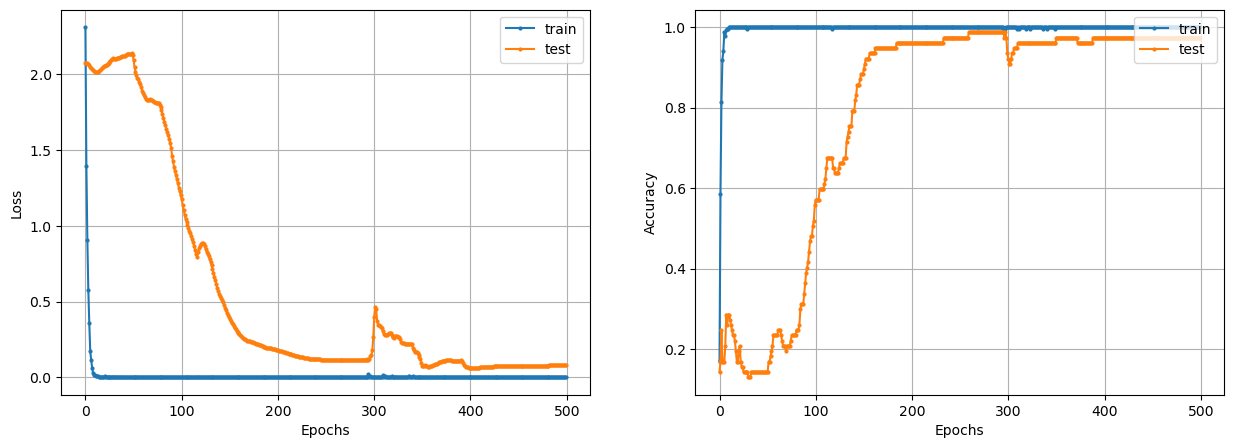

0.9870129823684692 0.060427505522966385
Start subject 6, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


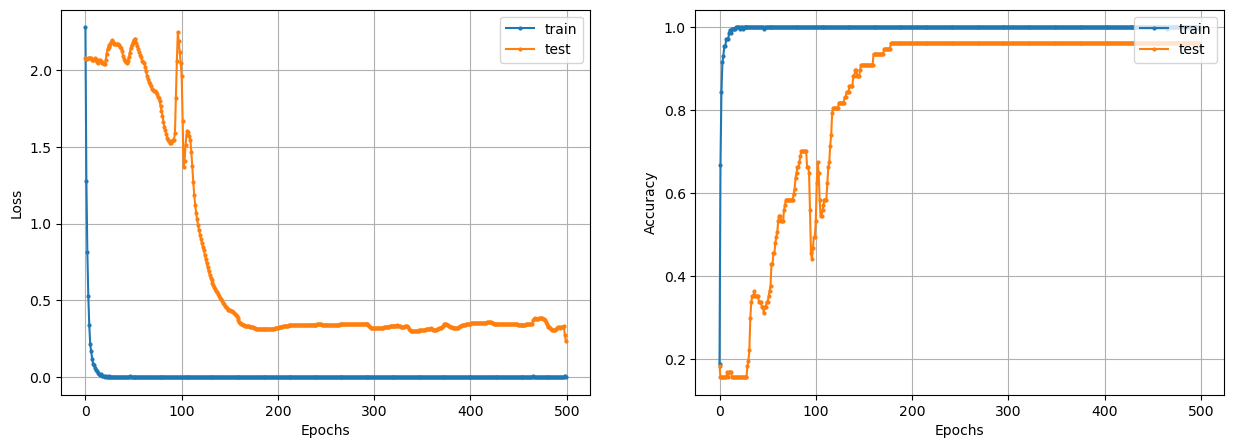

0.9610389471054077 0.23639756441116333
Start subject 6, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


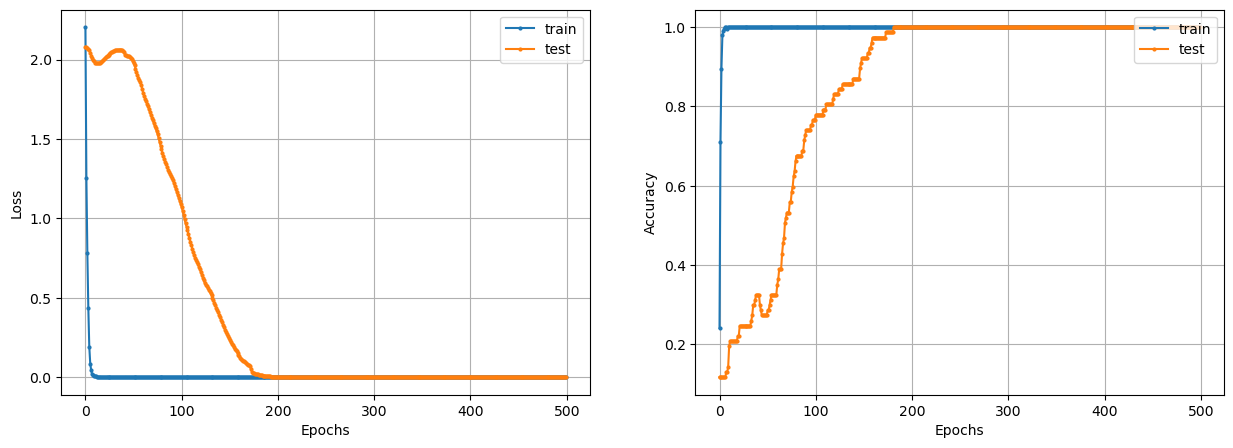

1.0 1.7498230590717867e-05
Start subject 6, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


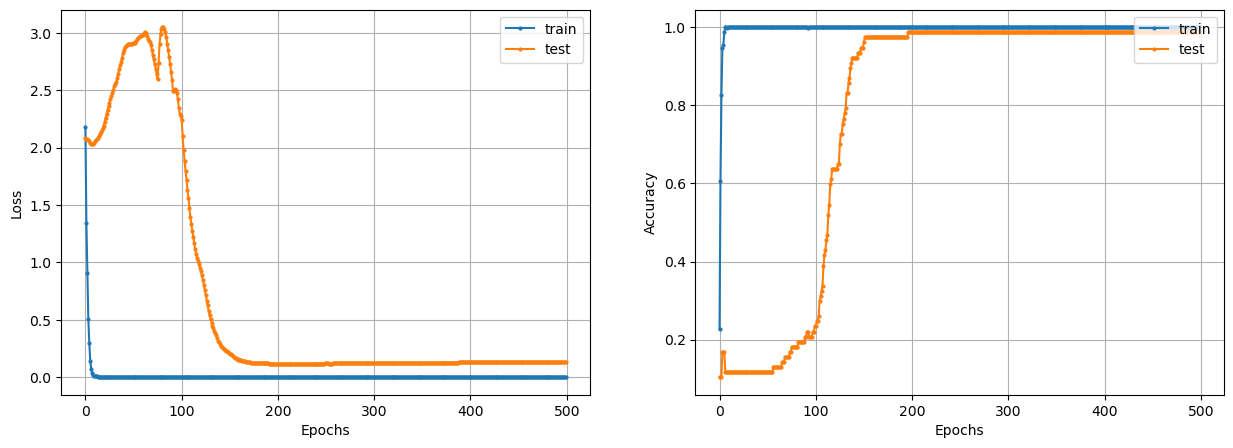

0.9870129823684692 0.1113627552986145
Start subject 6, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


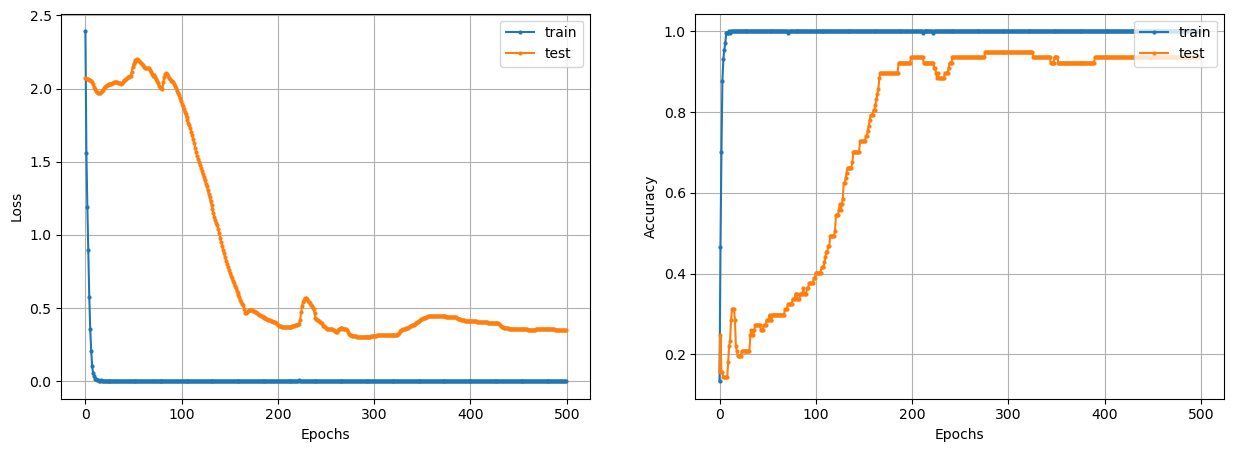

0.948051929473877 0.3026973307132721
Start subject 6, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


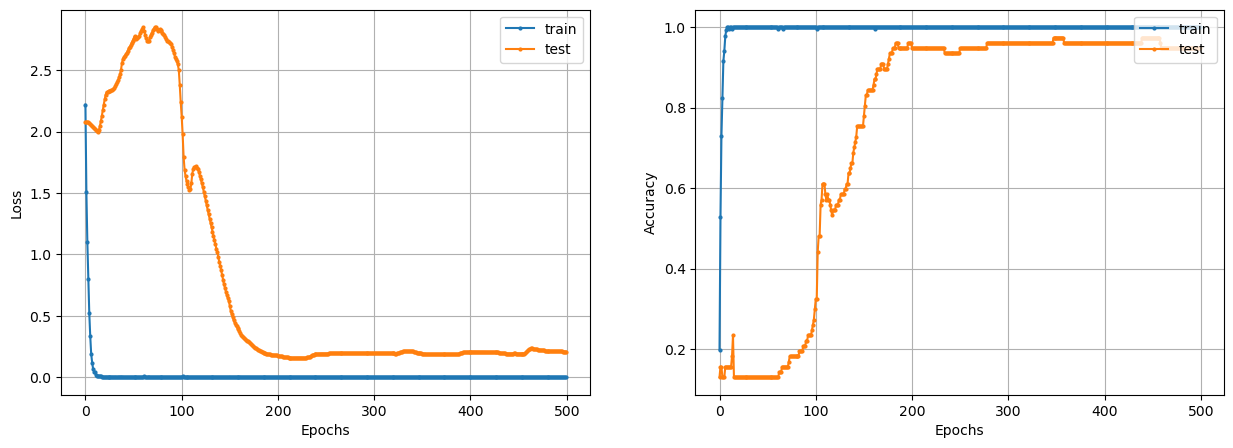

0.9740259647369385 0.15750892460346222
Start subject 7, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


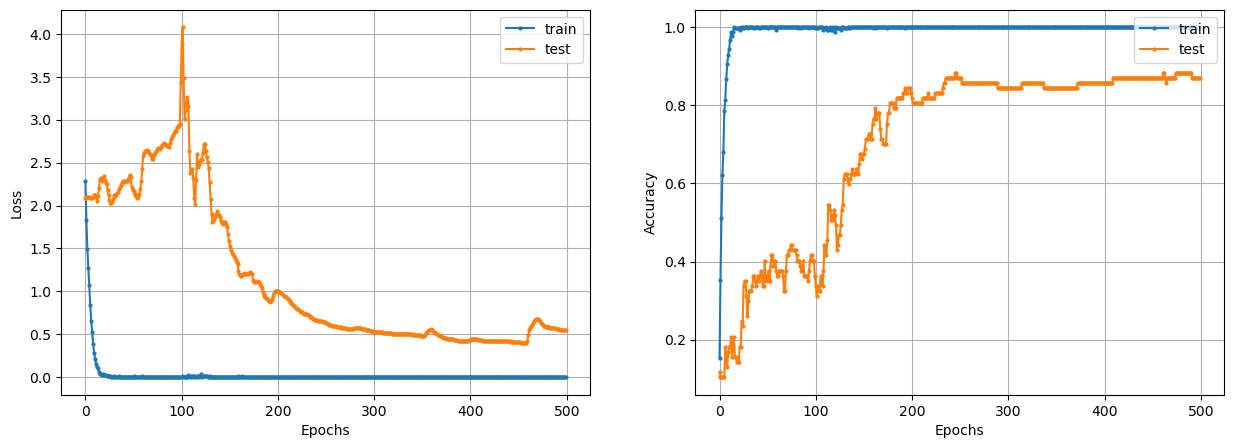

0.8831169009208679 0.39931774139404297
Start subject 7, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


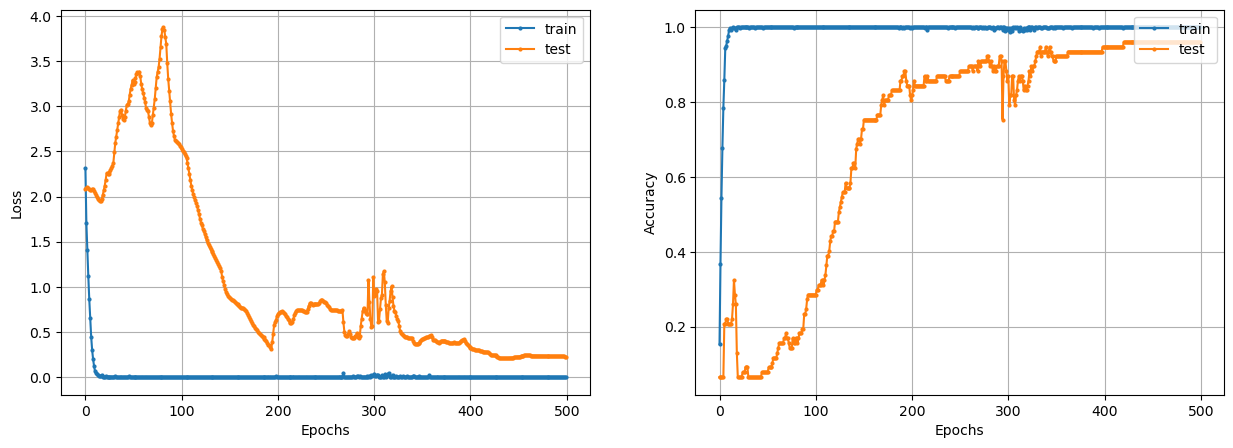

0.9610389471054077 0.2105836272239685
Start subject 7, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


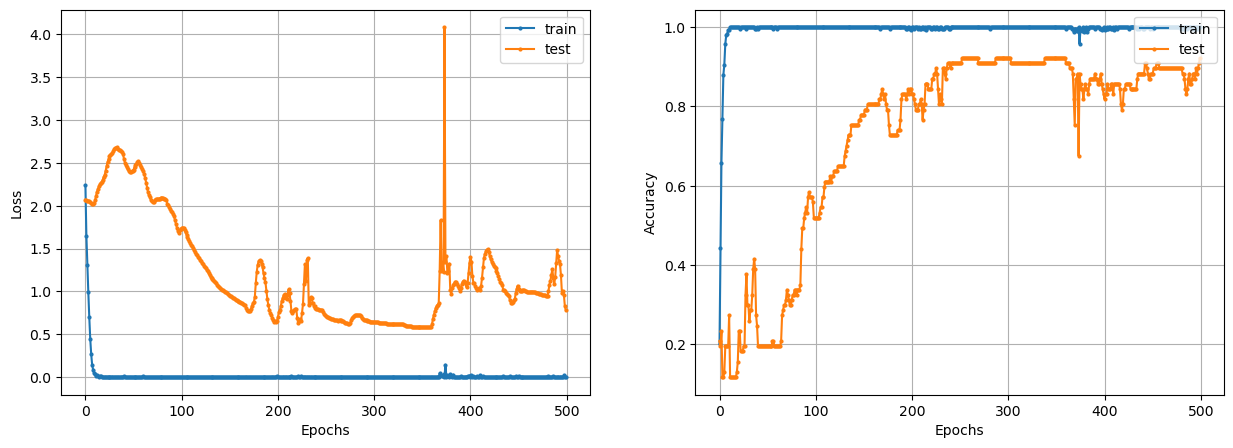

0.9220778942108154 0.5843783020973206
Start subject 7, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


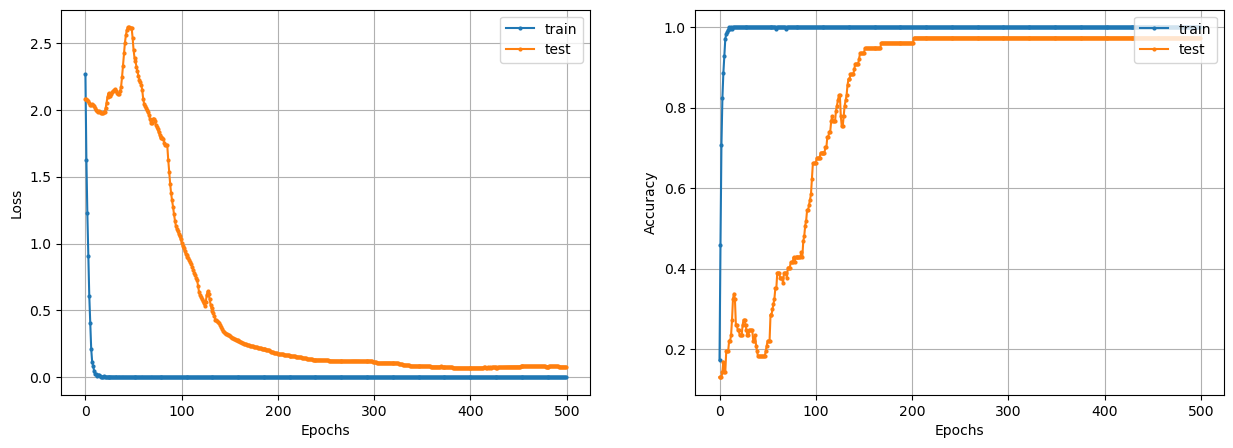

0.9740259647369385 0.07063159346580505
Start subject 7, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


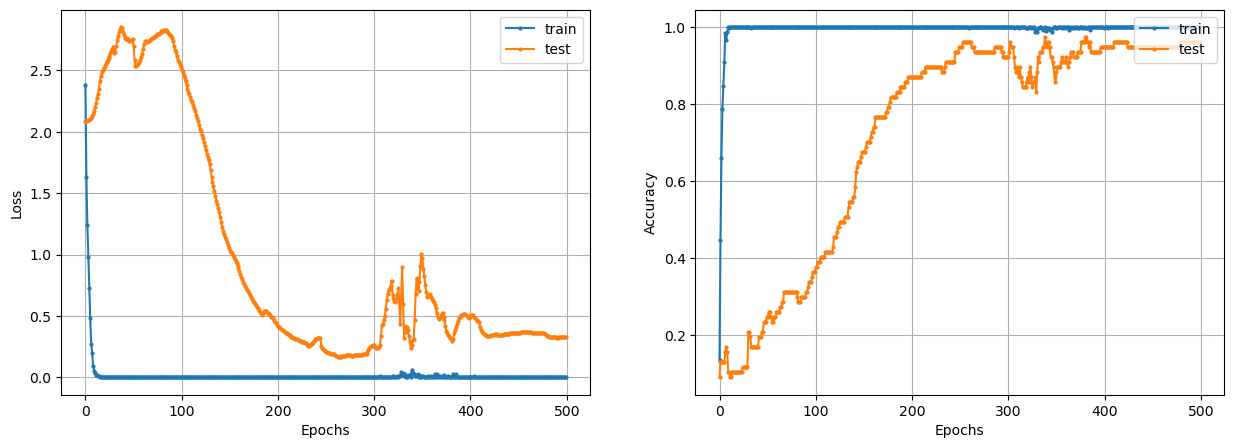

0.9740259647369385 0.1666433960199356
Start subject 7, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


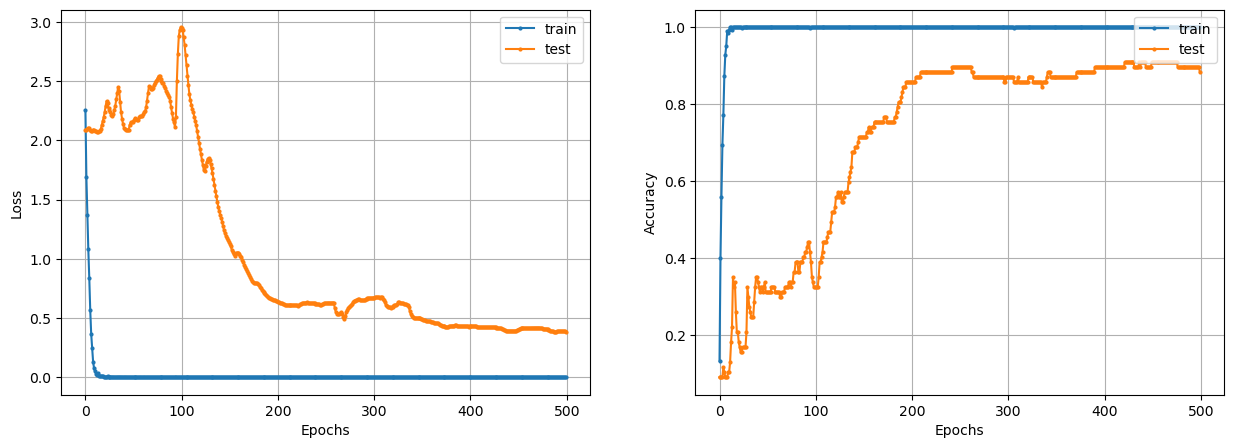

0.9090909361839294 0.3851727247238159
Start subject 7, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


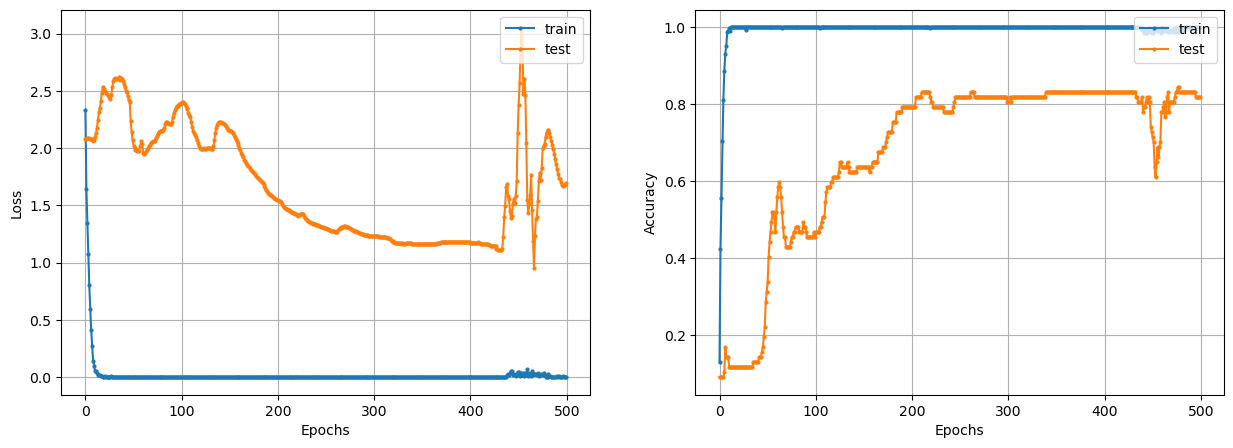

0.8441558480262756 0.9537983536720276
Start subject 7, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


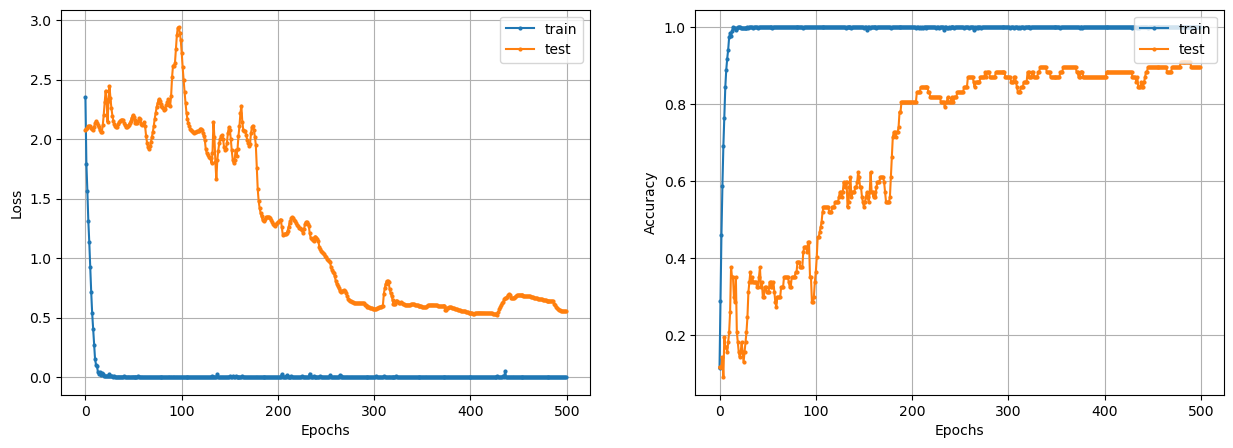

0.9090909361839294 0.5256009697914124
Start subject 8, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


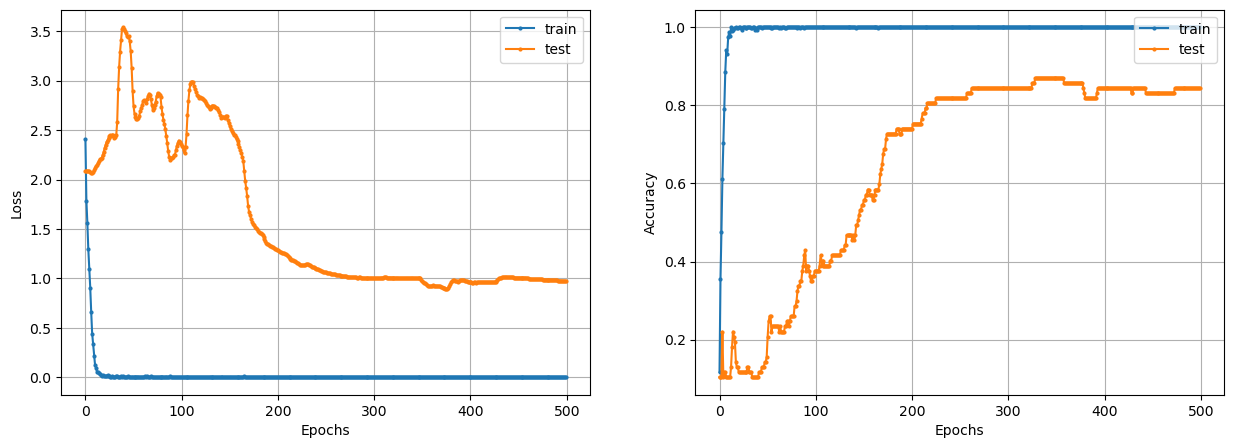

0.8701298832893372 0.8892809152603149
Start subject 8, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


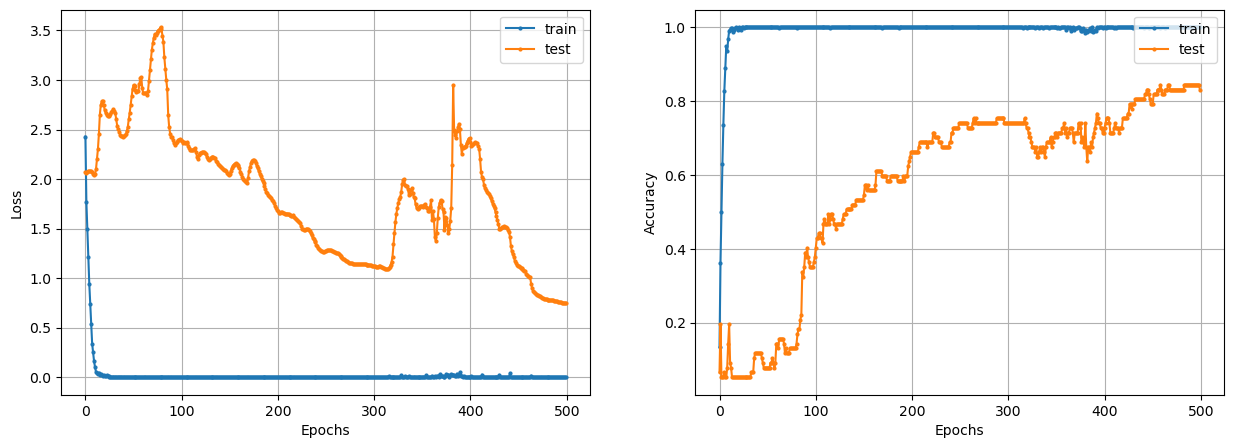

0.8441558480262756 0.7505016326904297
Start subject 8, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


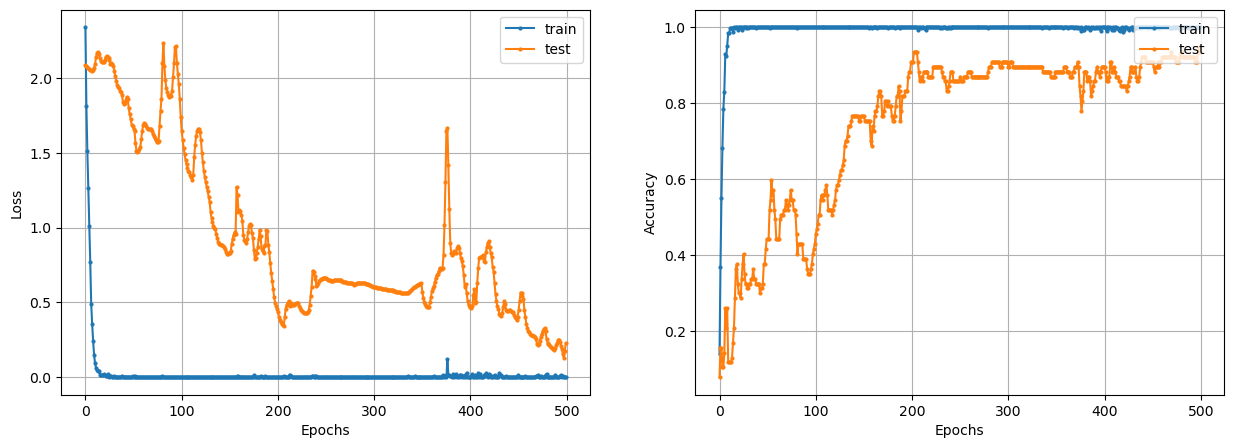

0.948051929473877 0.13024641573429108
Start subject 8, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


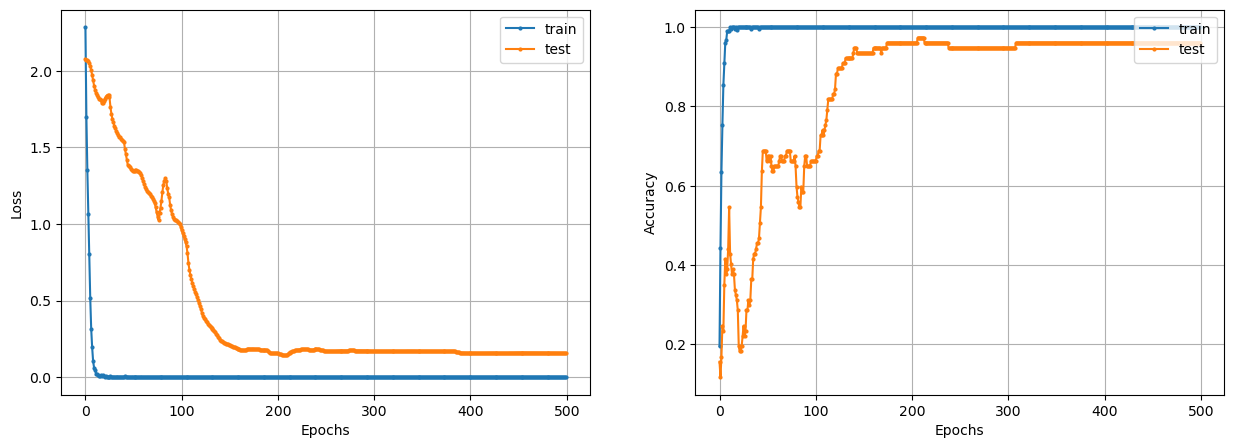

0.9740259647369385 0.14294709265232086
Start subject 8, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


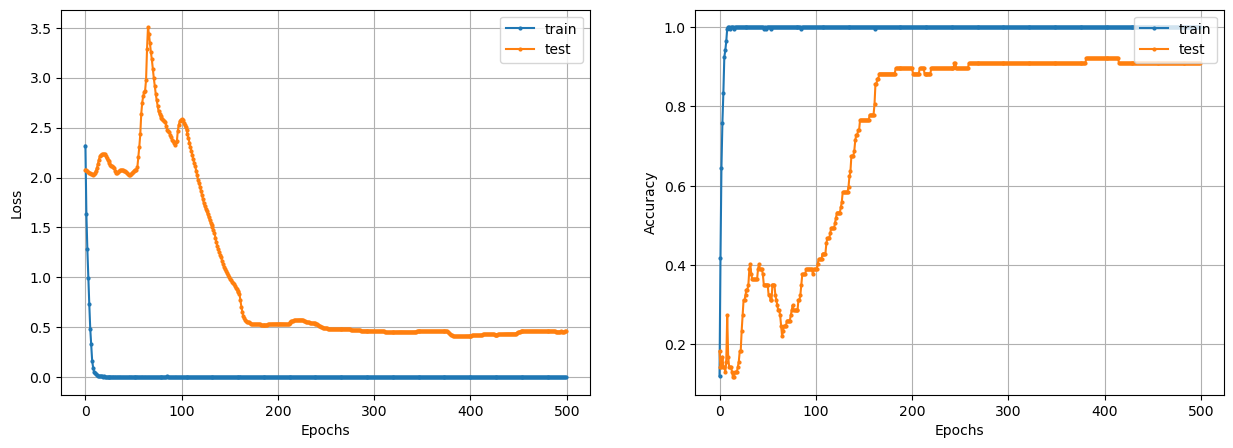

0.9220778942108154 0.4096960425376892
Start subject 8, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


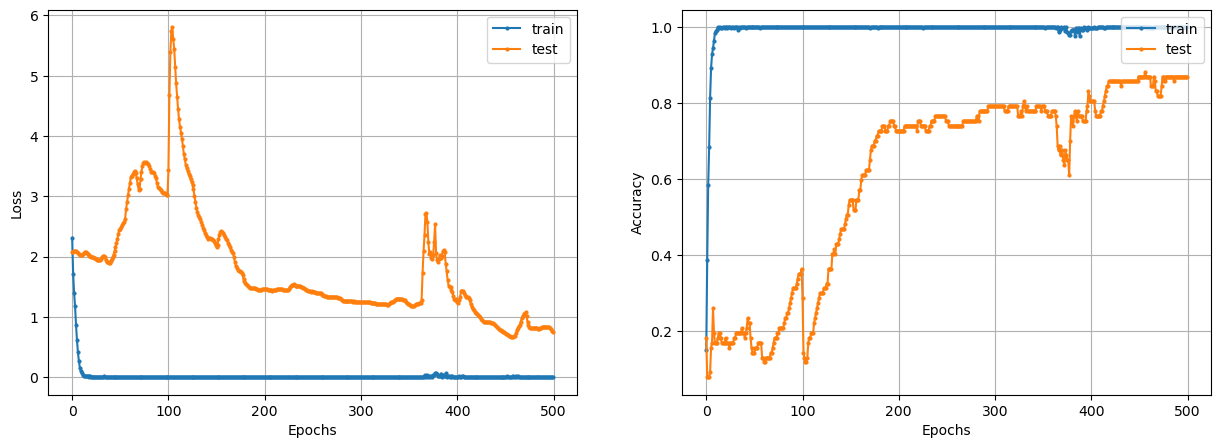

0.8831169009208679 0.6627726554870605
Start subject 8, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


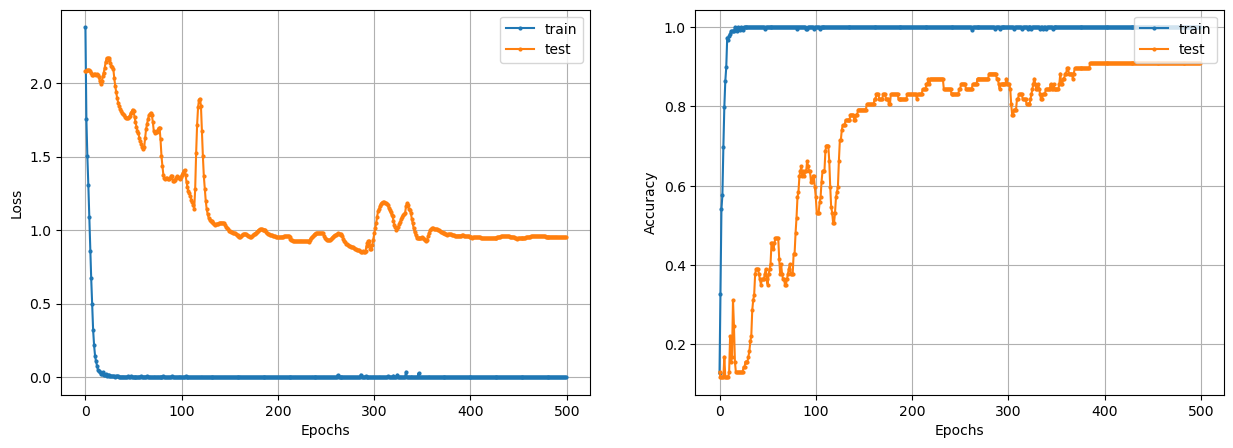

0.9090909361839294 0.8510853052139282
Start subject 8, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


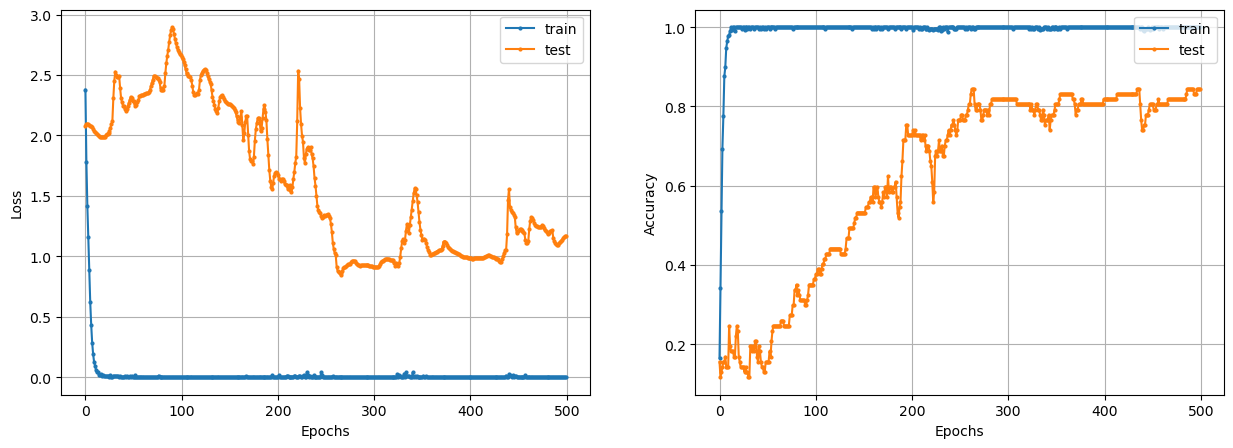

0.8441558480262756 0.8483463525772095
Start subject 9, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


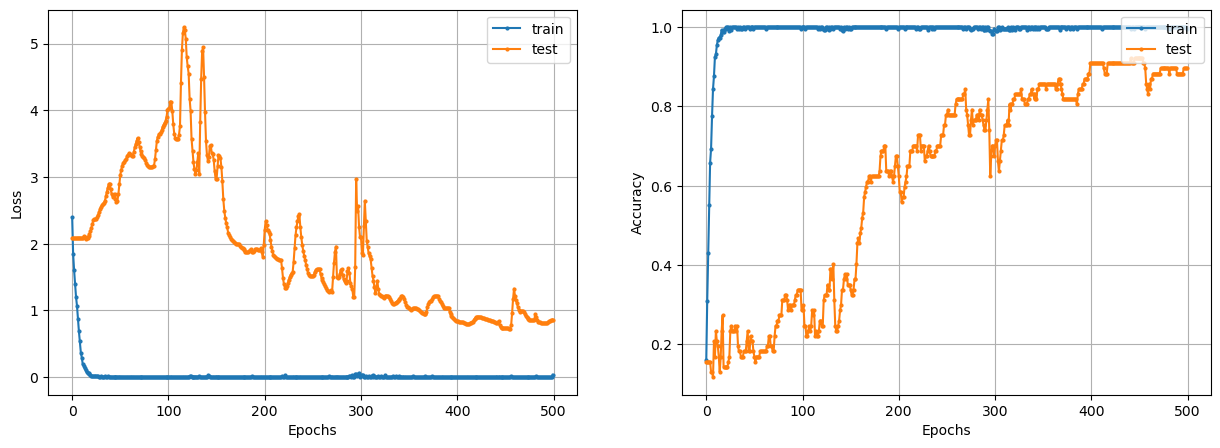

0.9220778942108154 0.7237623929977417
Start subject 9, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


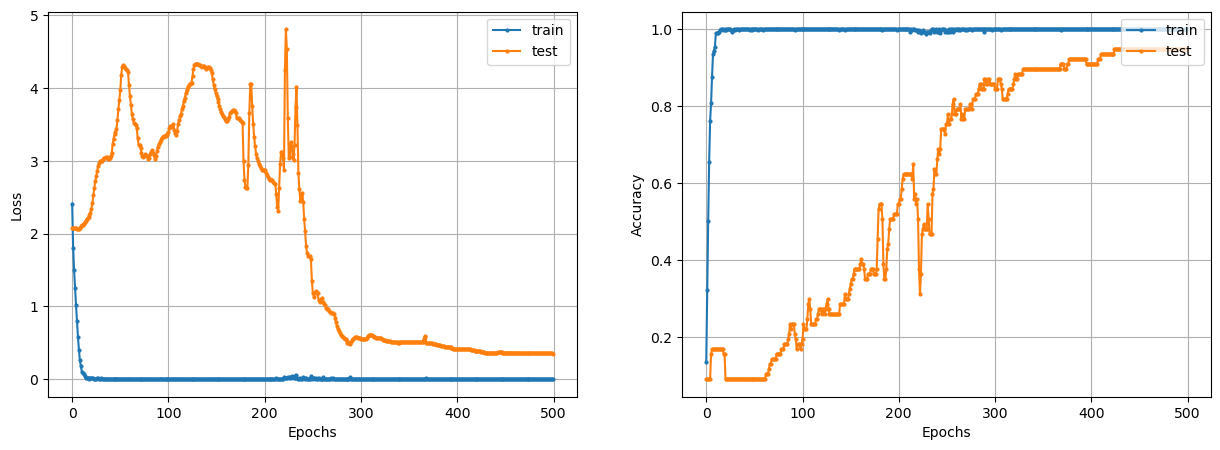

0.948051929473877 0.35317888855934143
Start subject 9, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


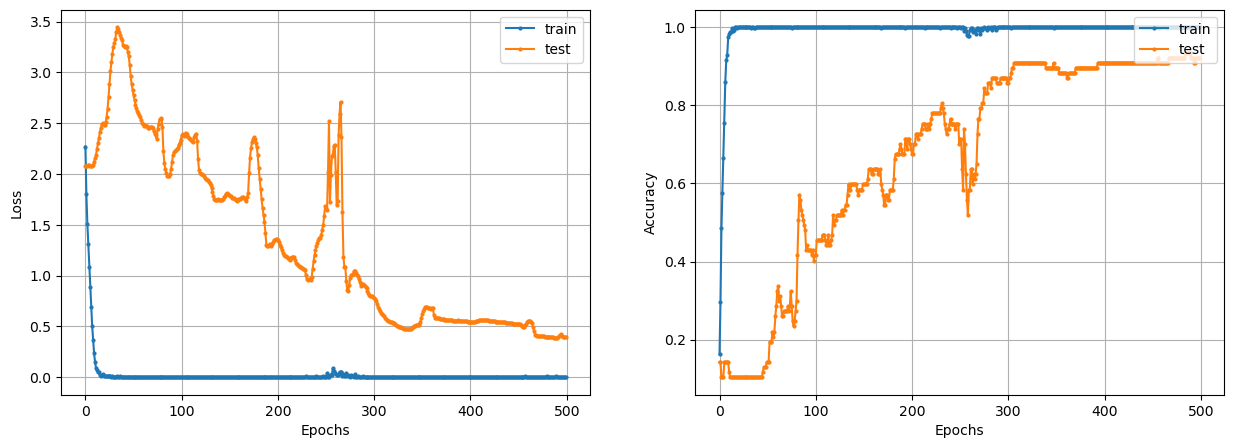

0.9350649118423462 0.3837536871433258
Start subject 9, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


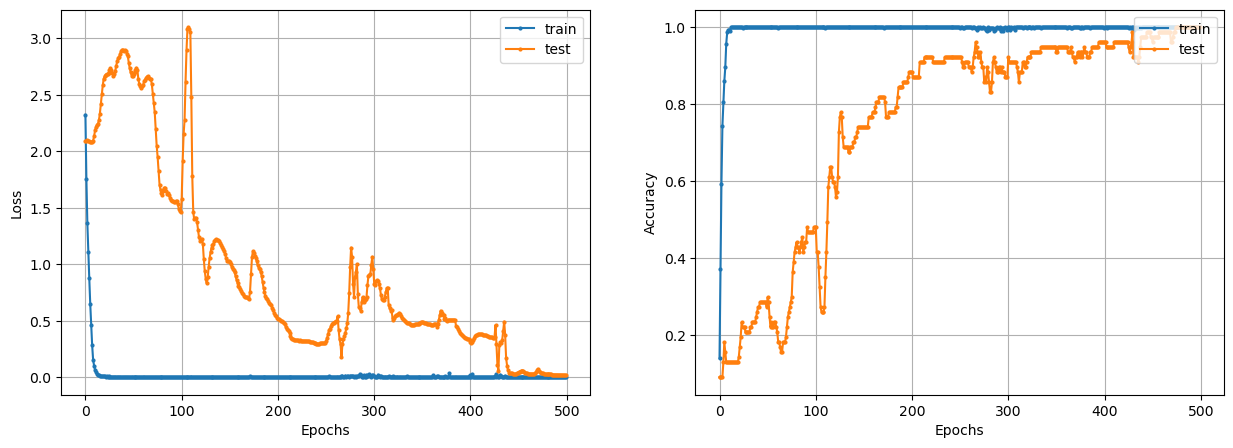

1.0 0.019589988514780998
Start subject 9, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


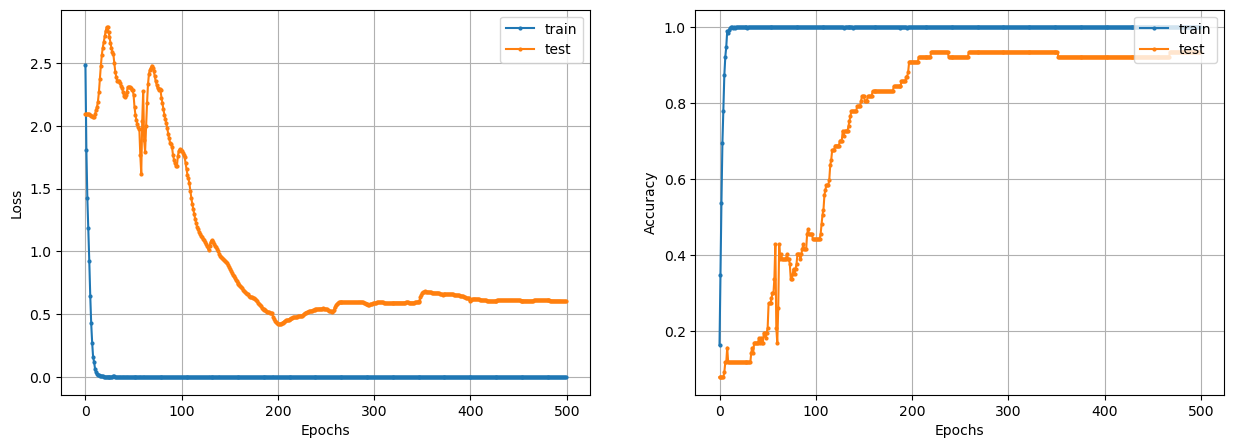

0.9350649118423462 0.42509645223617554
Start subject 9, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


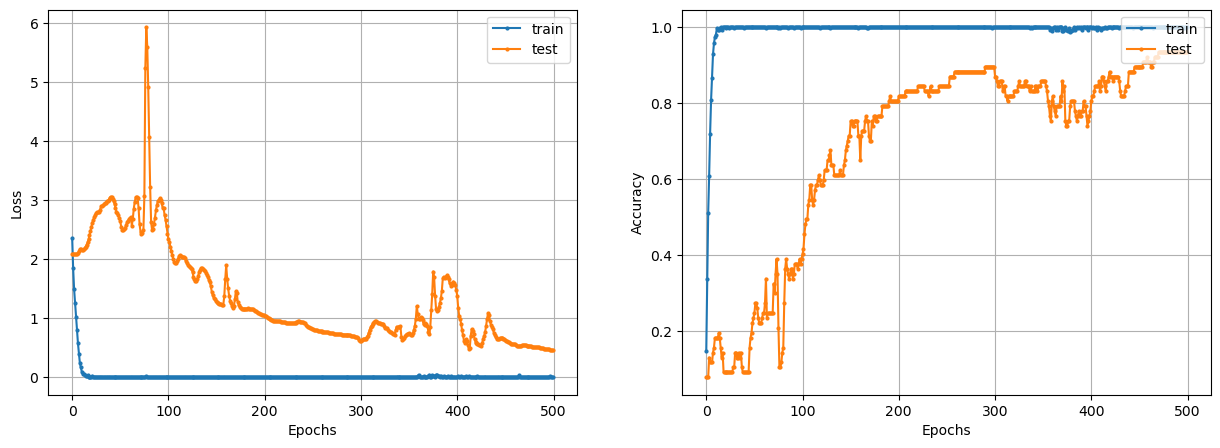

0.9350649118423462 0.4560210406780243
Start subject 9, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


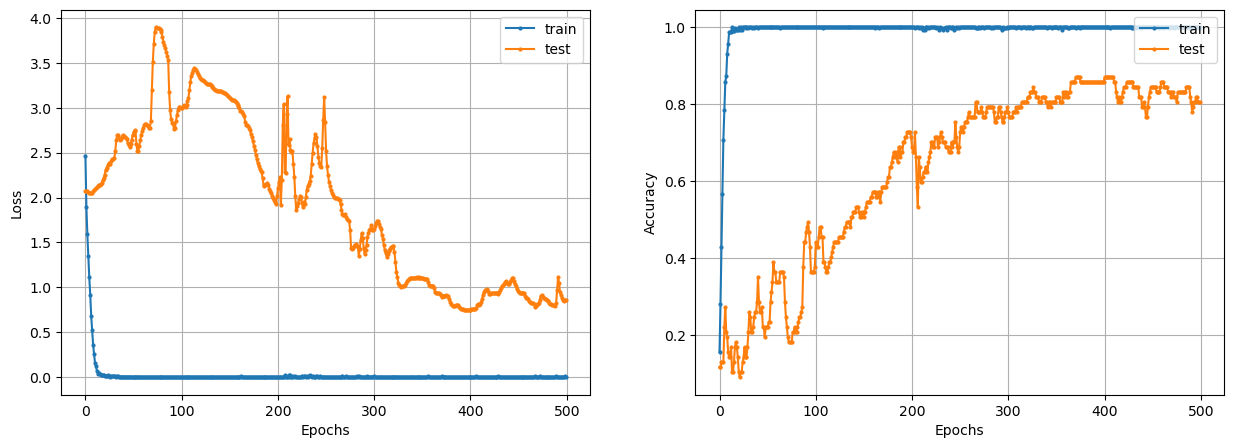

0.8701298832893372 0.7507646679878235
Start subject 9, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


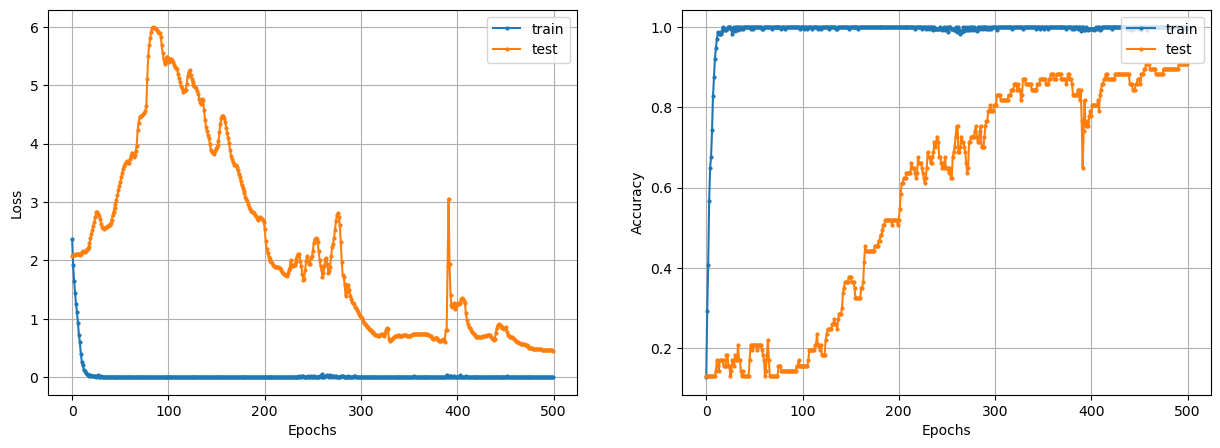

0.9090909361839294 0.4570980668067932
Start subject 10, Len: 16




FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/hml76/Desktop/UMN/Research seminar contents/1 paper__GNN/CapgMyo/CapgMyo_GAT_NEW/Data/DB_B_preproceesed/dbb-preprocessed-010/0010-001-001.mat'

In [14]:
pat = './performance_eval/'

for subject in range(1,11):
    for no_sen in range(8):
        LST_sensor = []
        for i in range(128):
            if i%8 == no_sen:
                LST_sensor.append(i)
        
        print("Start subject {}, Len: {}\n======================================================\n\n".format(subject, len(LST_sensor)))
        df = build_df(LST_sensor, subject)
        graph, graph_info, x_train, y_train = build_graph_works_larger_than_16(df, LST_sensor)
        #draw_graph(graph)
        
        gnn_model = build_gnn_model(graph_info, num_classes, hidden_units, dropout_rate)

        val = gnn_model.fit(x=x_train, y=y_train, epochs=500, batch_size=batch_size, validation_split=0.2,
                            #callbacks=[lr_scheduler,early_stopping],
                            verbose = 0)
        
        plot(val)
        
        ACC = val.history['val_acc']
        LOSS = val.history['val_loss']
        print(np.max(ACC), np.min(LOSS))
        pd.DataFrame(ACC).to_csv(pat+'S{}/val_acc_missing_sensors_7_Row{}.csv'.format(subject, no_sen))
        pd.DataFrame(LOSS).to_csv(pat+'S{}/val_loss_missing_sensors_7_Row{}.csv'.format(subject, no_sen))

Start subject 1, Len: 15


Edges shape: (2, 3201)      Nodes shape: (360, 1000)


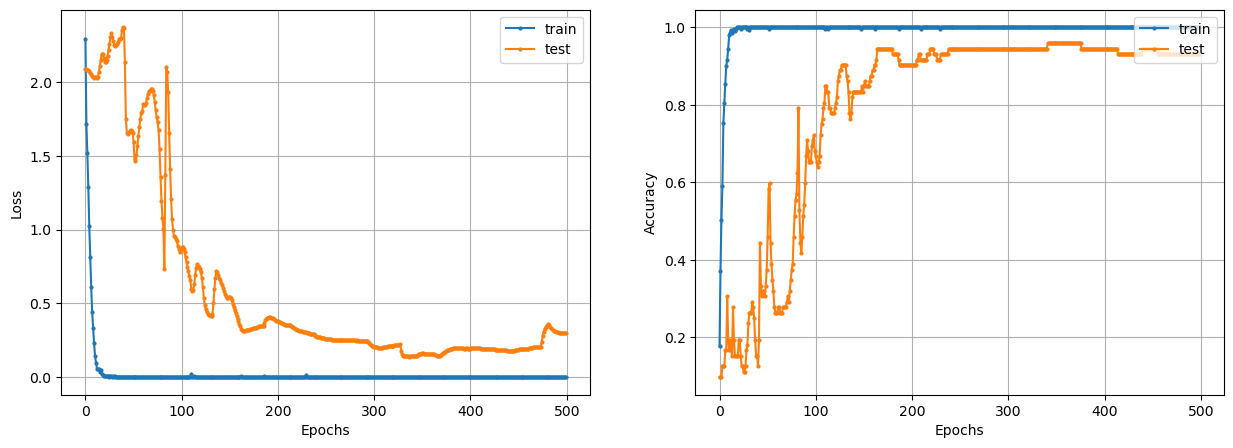

0.9583333134651184 0.139974445104599
Start subject 1, Len: 14


Edges shape: (2, 2914)      Nodes shape: (336, 1000)


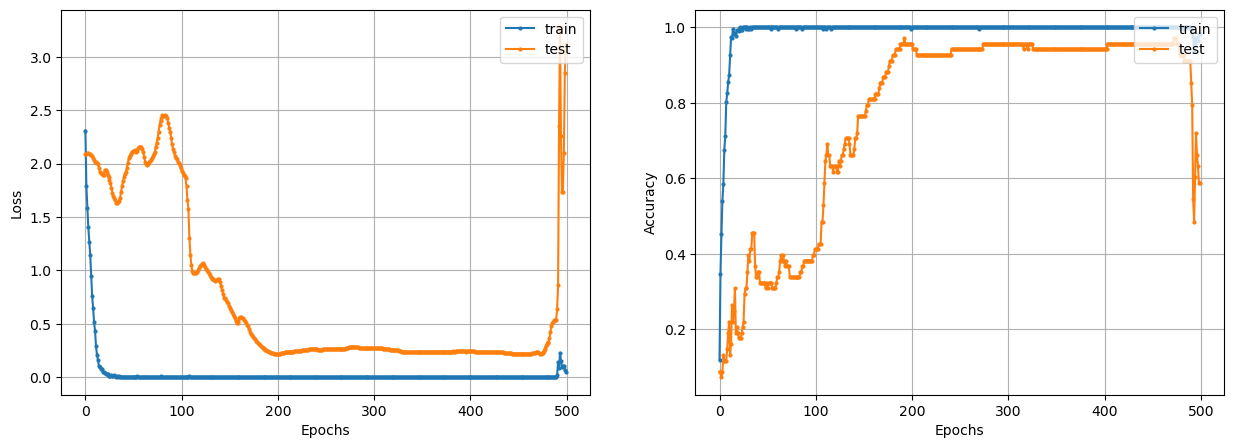

0.970588207244873 0.21548207104206085
Start subject 1, Len: 13


Edges shape: (2, 2627)      Nodes shape: (312, 1000)


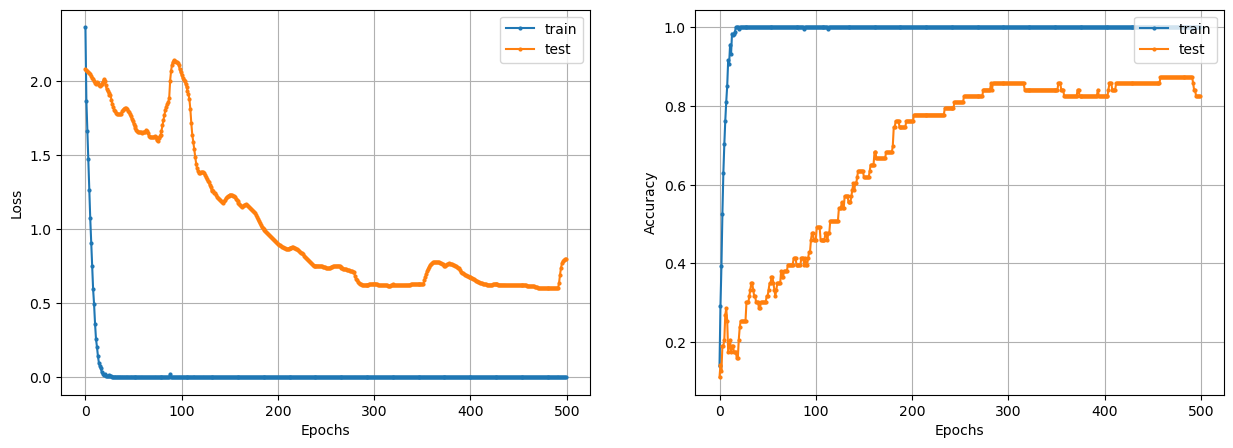

0.8730158805847168 0.6009803414344788
Start subject 1, Len: 12


Edges shape: (2, 2412)      Nodes shape: (288, 1000)


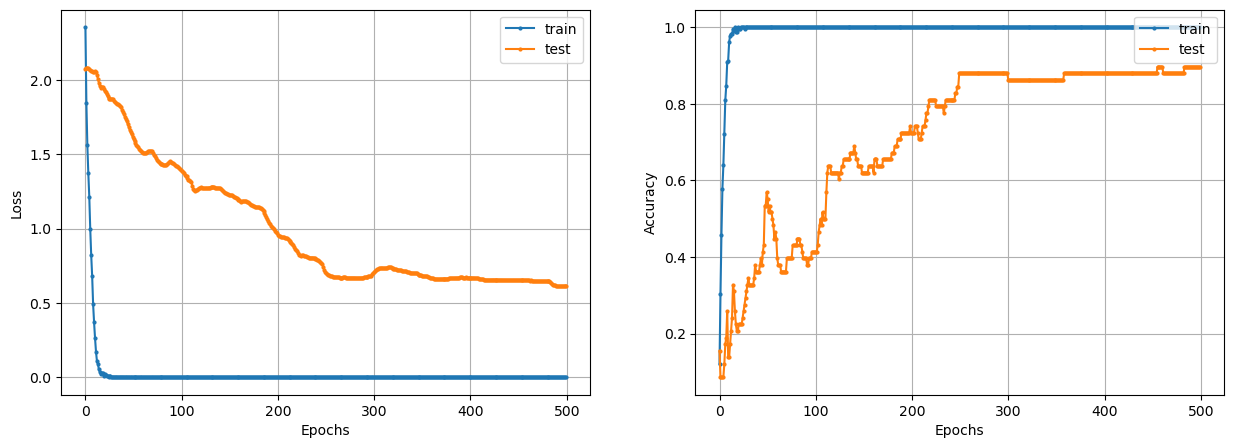

0.8965517282485962 0.6115734577178955
Start subject 1, Len: 11


Edges shape: (2, 2197)      Nodes shape: (264, 1000)


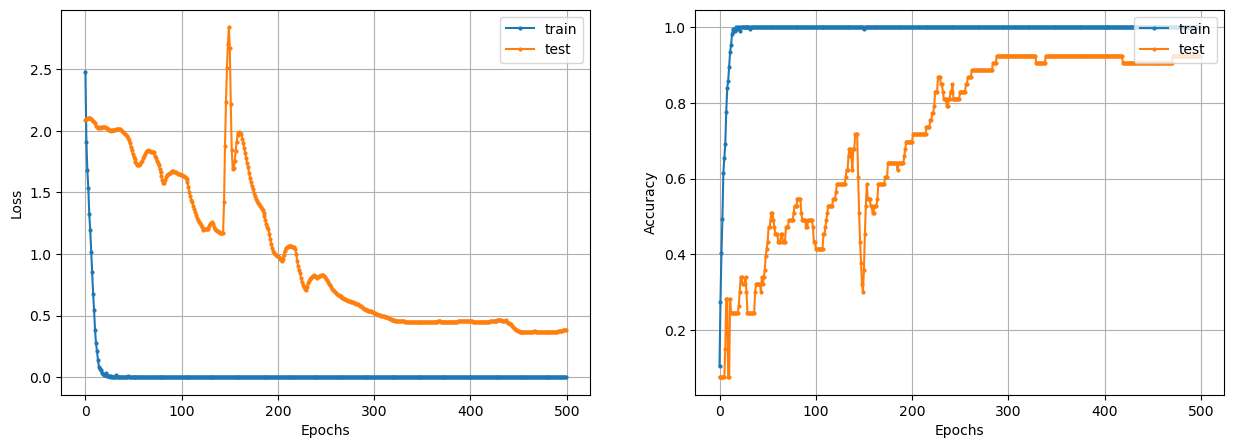

0.9245283007621765 0.36363476514816284
Start subject 1, Len: 10


Edges shape: (2, 2054)      Nodes shape: (240, 1000)


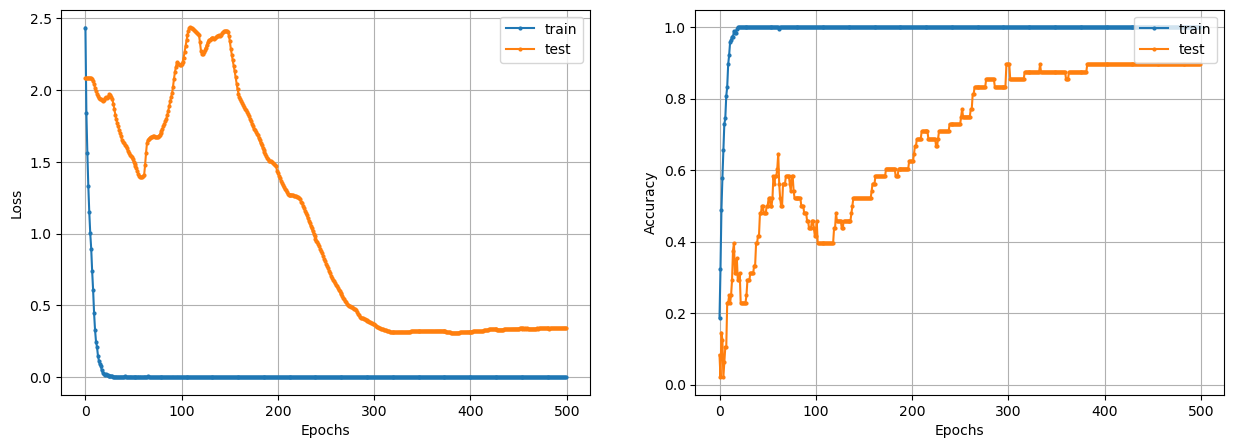

0.8958333134651184 0.30924153327941895
Start subject 1, Len: 9


Edges shape: (2, 1863)      Nodes shape: (216, 1000)


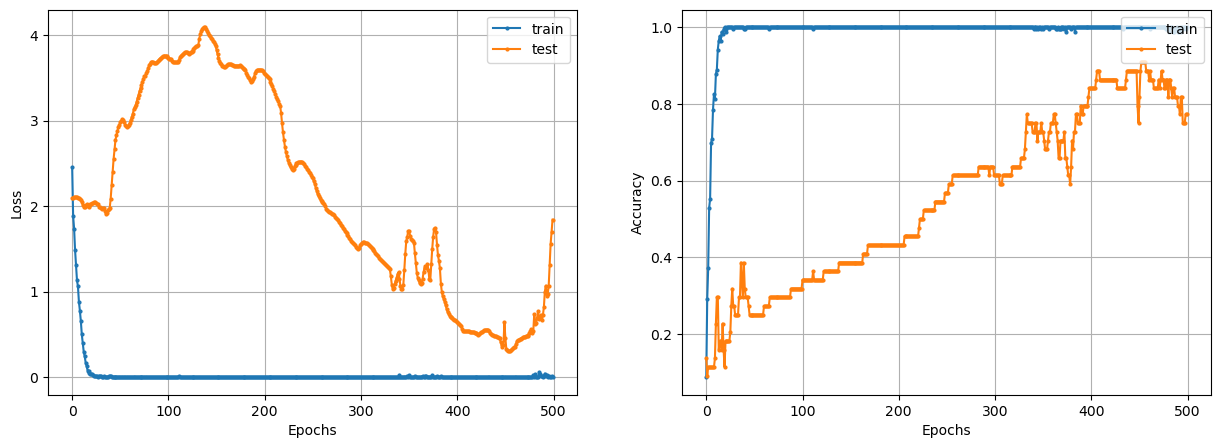

0.9090909361839294 0.3057975471019745
Start subject 1, Len: 8


Edges shape: (2, 1648)      Nodes shape: (192, 1000)


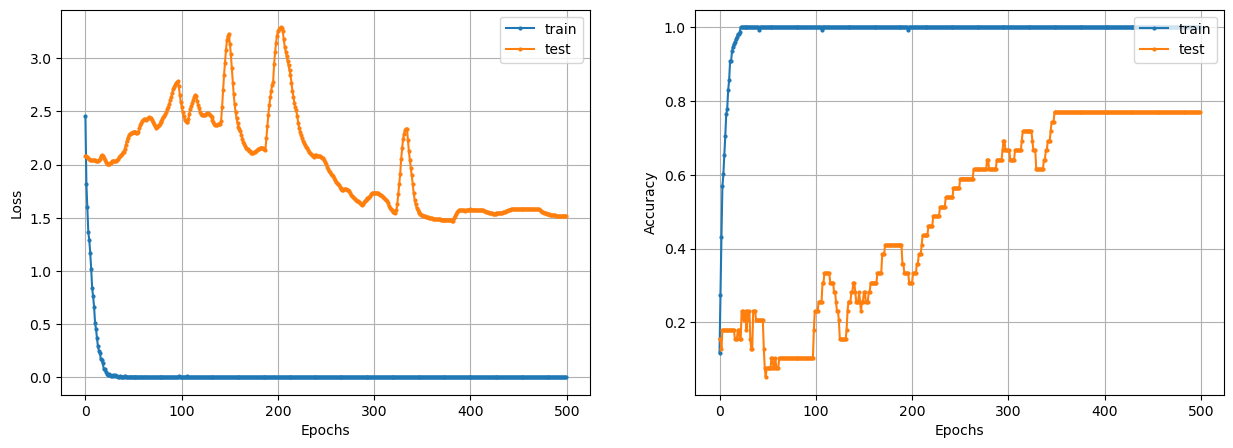

0.7692307829856873 1.4721640348434448
Start subject 1, Len: 7


Edges shape: (2, 1433)      Nodes shape: (168, 1000)


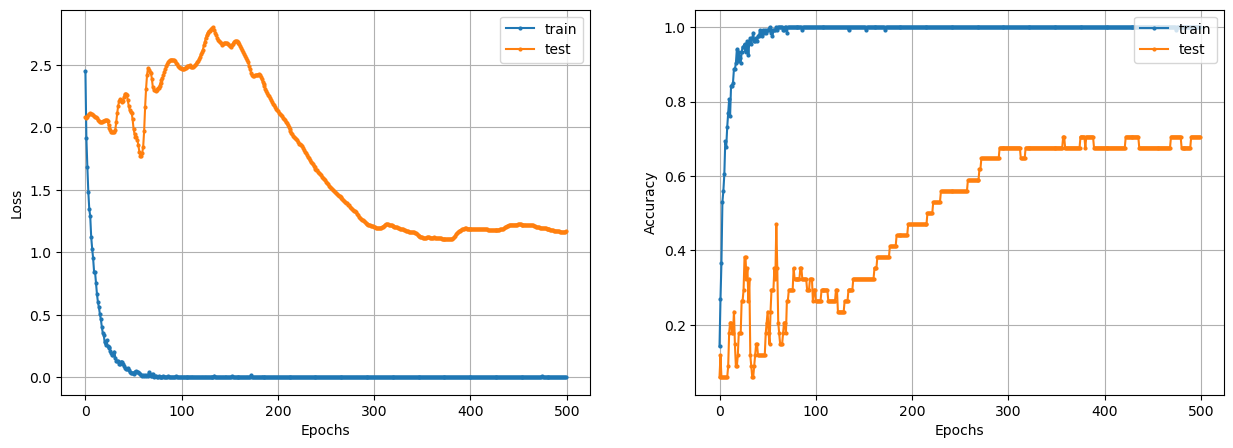

0.7058823704719543 1.1043692827224731
Start subject 1, Len: 6


Edges shape: (2, 1122)      Nodes shape: (144, 1000)


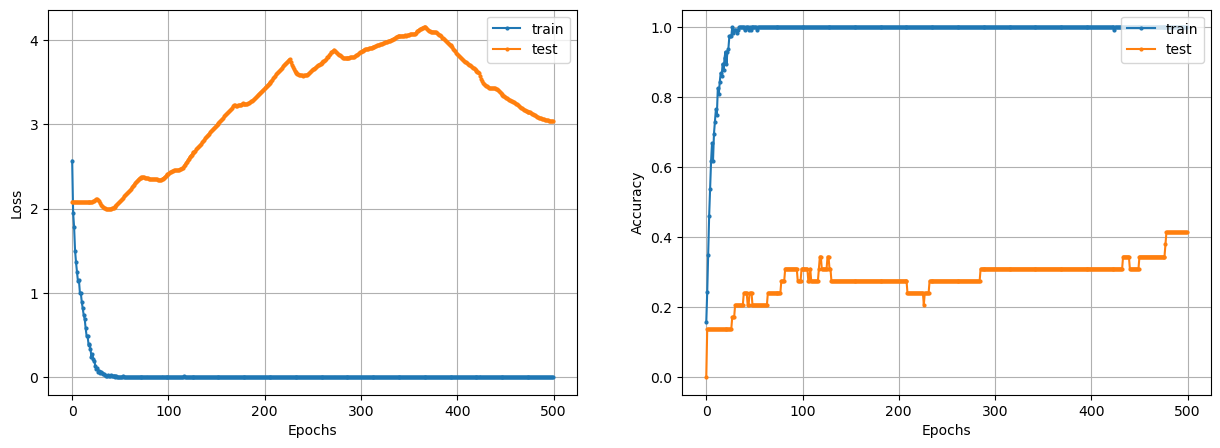

0.4137931168079376 1.9922053813934326
Start subject 1, Len: 5


Edges shape: (2, 907)      Nodes shape: (120, 1000)


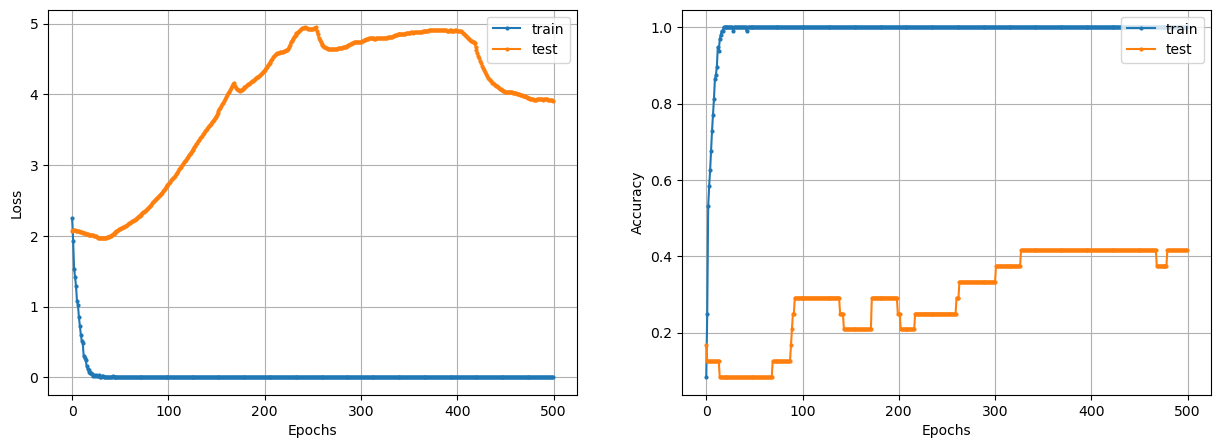

0.4166666567325592 1.9676367044448853
Start subject 1, Len: 4


Edges shape: (2, 692)      Nodes shape: (96, 1000)


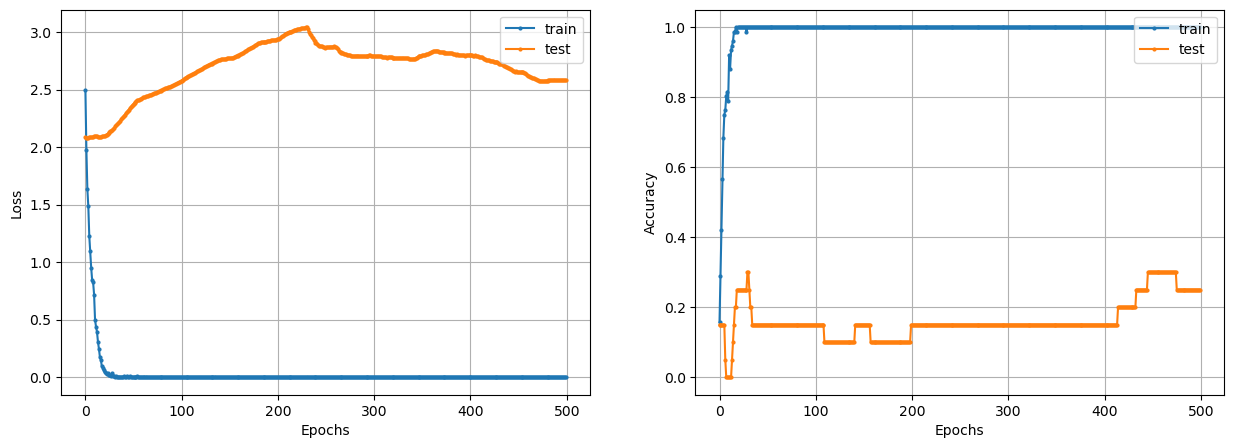

0.30000001192092896 2.0817861557006836
Start subject 1, Len: 3


Edges shape: (2, 477)      Nodes shape: (72, 1000)


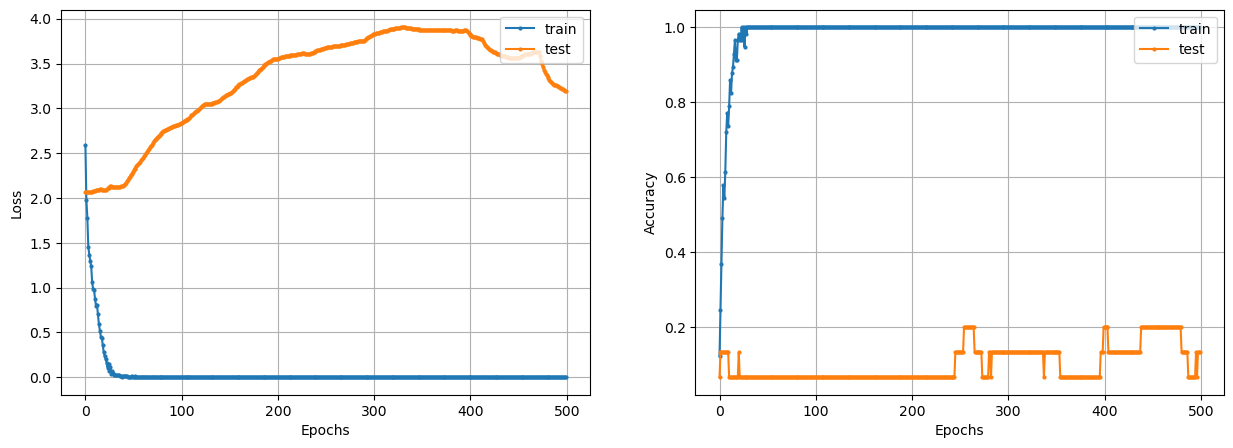

0.20000000298023224 2.062084436416626
Start subject 1, Len: 2


Edges shape: (2, 334)      Nodes shape: (48, 1000)


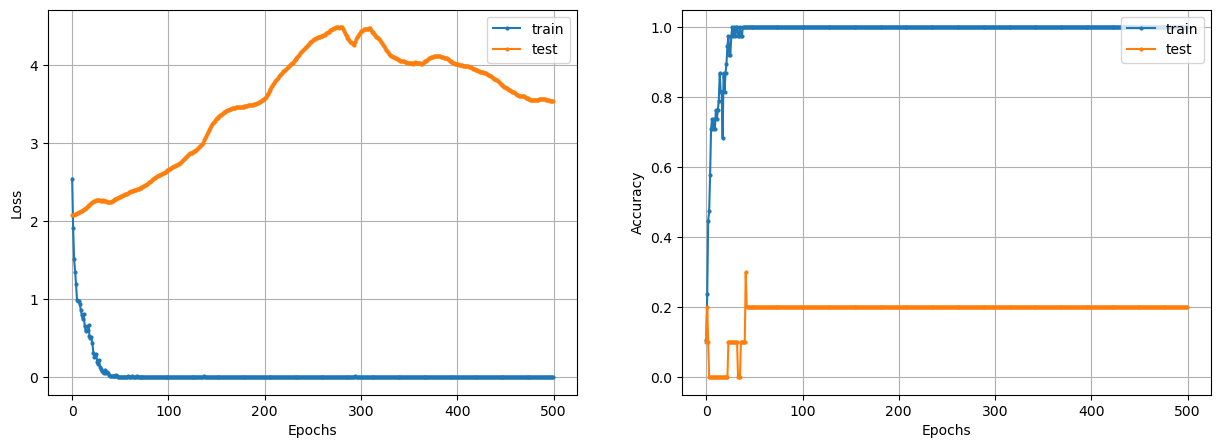

0.30000001192092896 2.071424722671509
Start subject 1, Len: 1


Edges shape: (2, 143)      Nodes shape: (24, 1000)


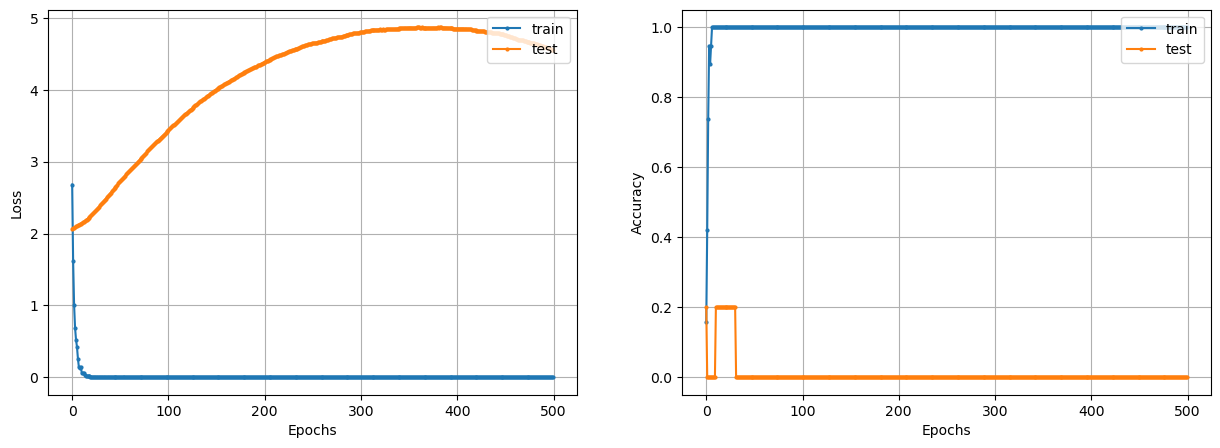

0.20000000298023224 2.062485456466675
Start subject 2, Len: 15


Edges shape: (2, 3201)      Nodes shape: (360, 1000)


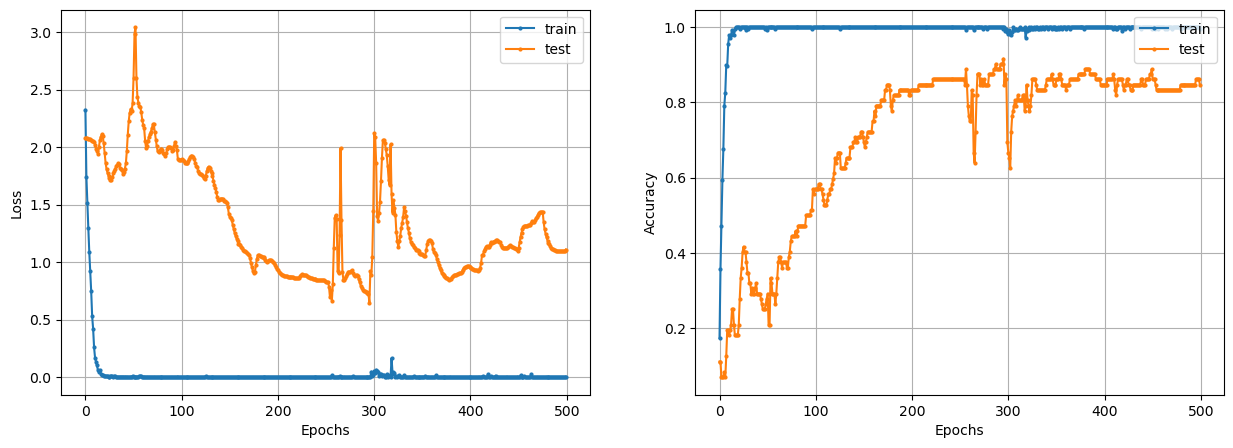

0.9166666865348816 0.6481558680534363
Start subject 2, Len: 14


Edges shape: (2, 2914)      Nodes shape: (336, 1000)


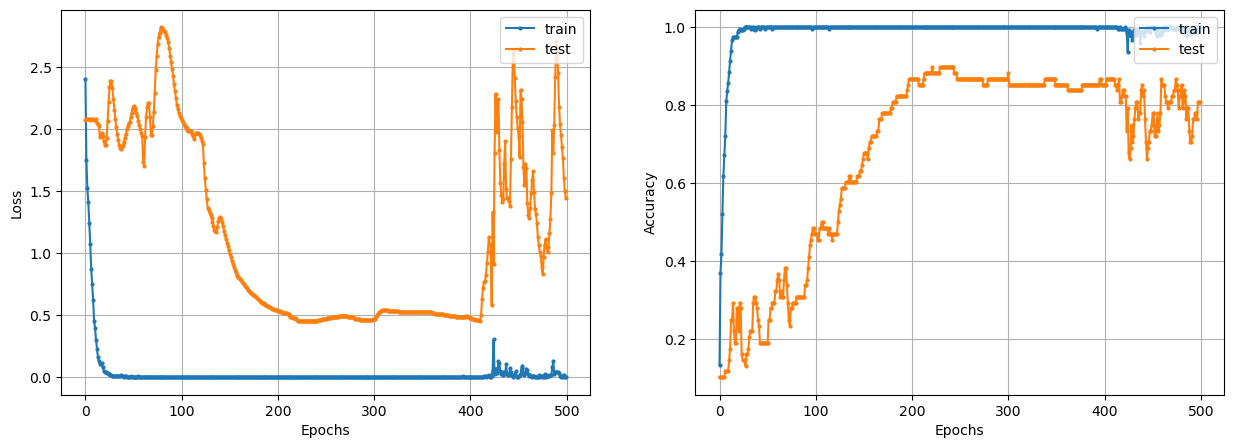

0.8970588445663452 0.4520008862018585
Start subject 2, Len: 13


Edges shape: (2, 2627)      Nodes shape: (312, 1000)


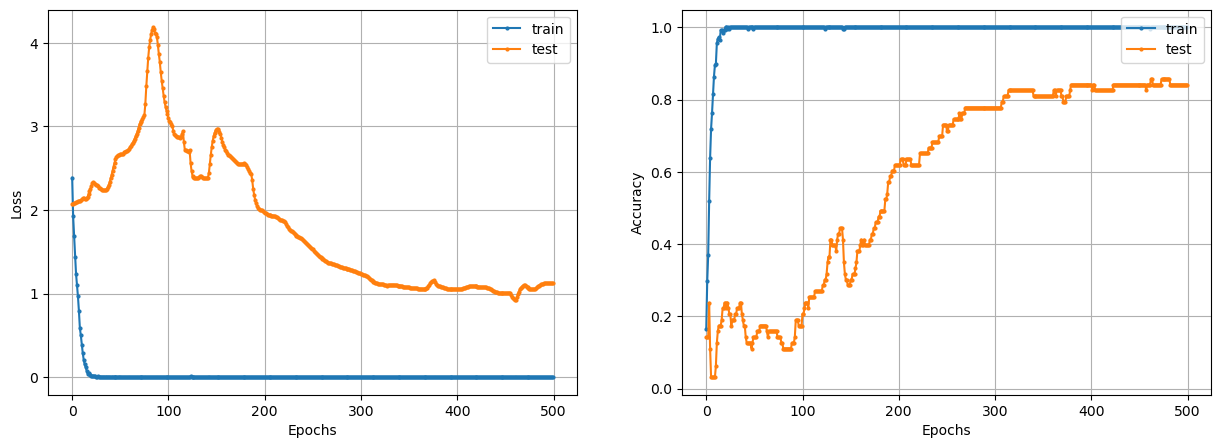

0.8571428656578064 0.921437680721283
Start subject 2, Len: 12


Edges shape: (2, 2412)      Nodes shape: (288, 1000)


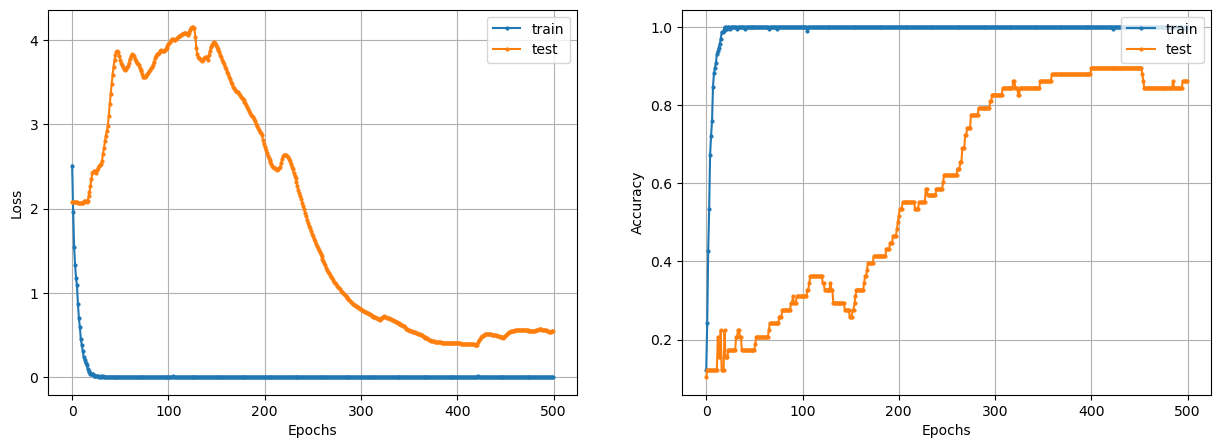

0.8965517282485962 0.38516077399253845
Start subject 2, Len: 11


Edges shape: (2, 2197)      Nodes shape: (264, 1000)


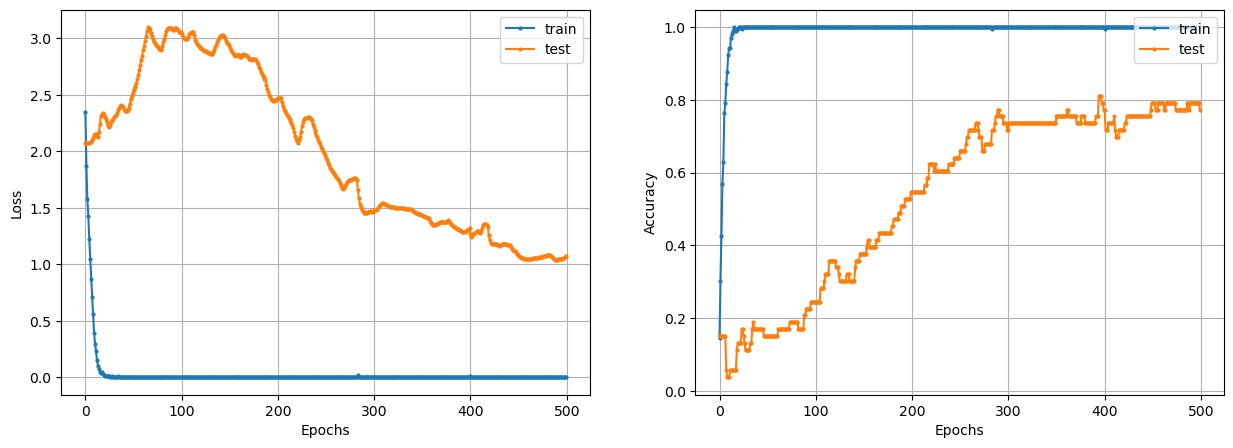

0.8113207817077637 1.0357441902160645
Start subject 2, Len: 10


Edges shape: (2, 2054)      Nodes shape: (240, 1000)


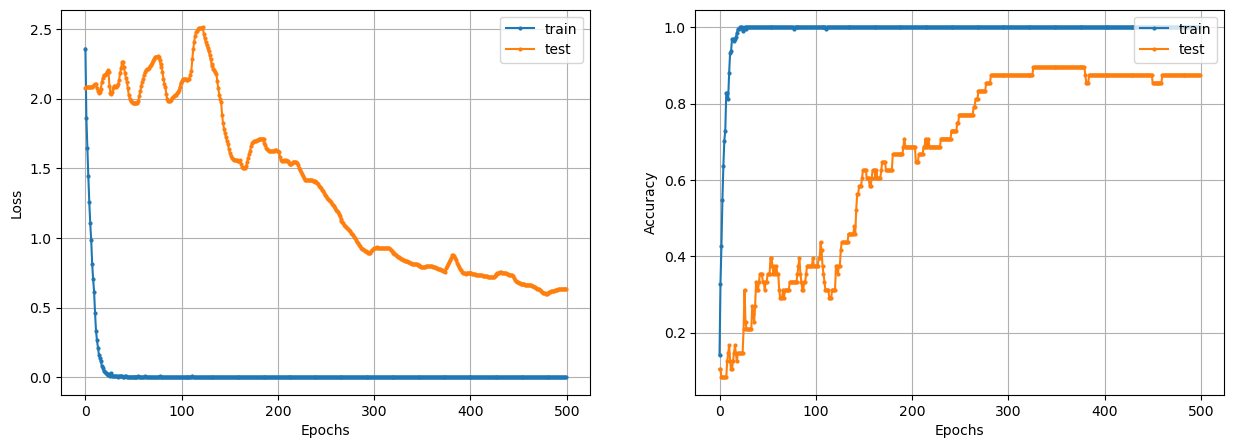

0.8958333134651184 0.5999500155448914
Start subject 2, Len: 9


Edges shape: (2, 1863)      Nodes shape: (216, 1000)


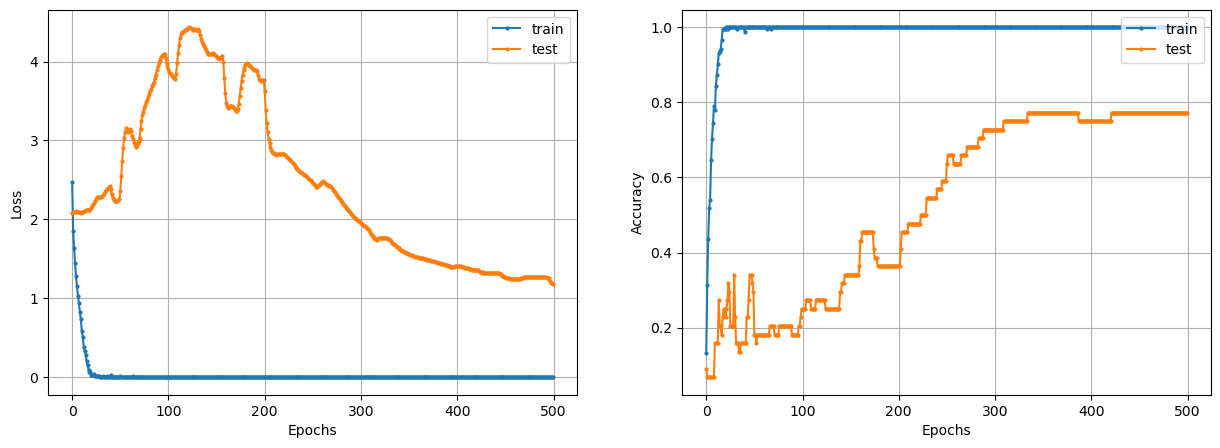

0.7727272510528564 1.1812676191329956
Start subject 2, Len: 8


Edges shape: (2, 1648)      Nodes shape: (192, 1000)


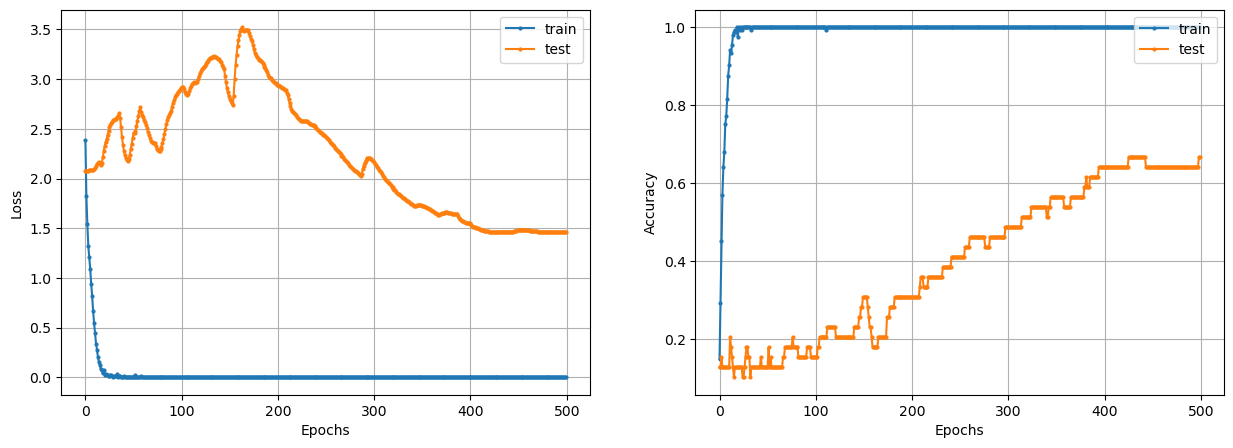

0.6666666865348816 1.4587503671646118
Start subject 2, Len: 7


Edges shape: (2, 1433)      Nodes shape: (168, 1000)


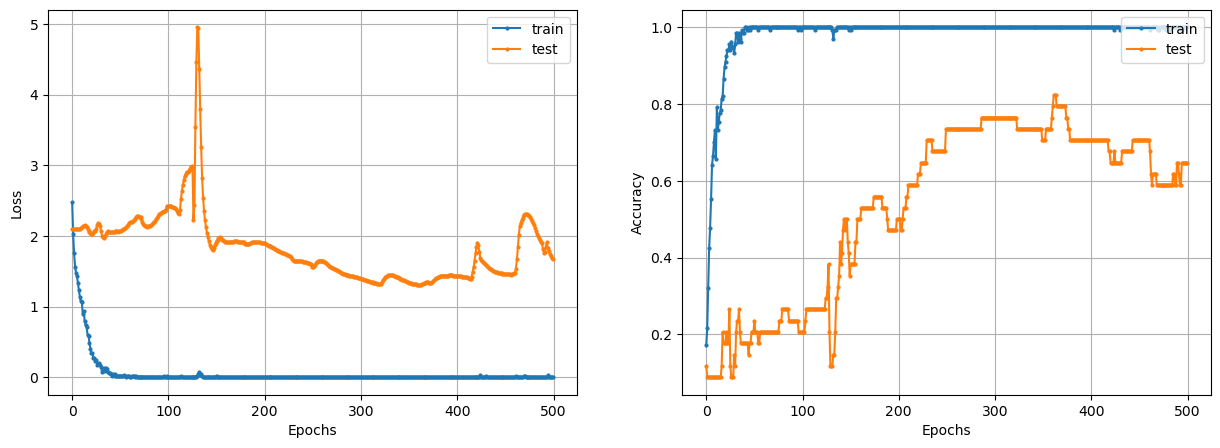

0.8235294222831726 1.300581455230713
Start subject 2, Len: 6


Edges shape: (2, 1122)      Nodes shape: (144, 1000)


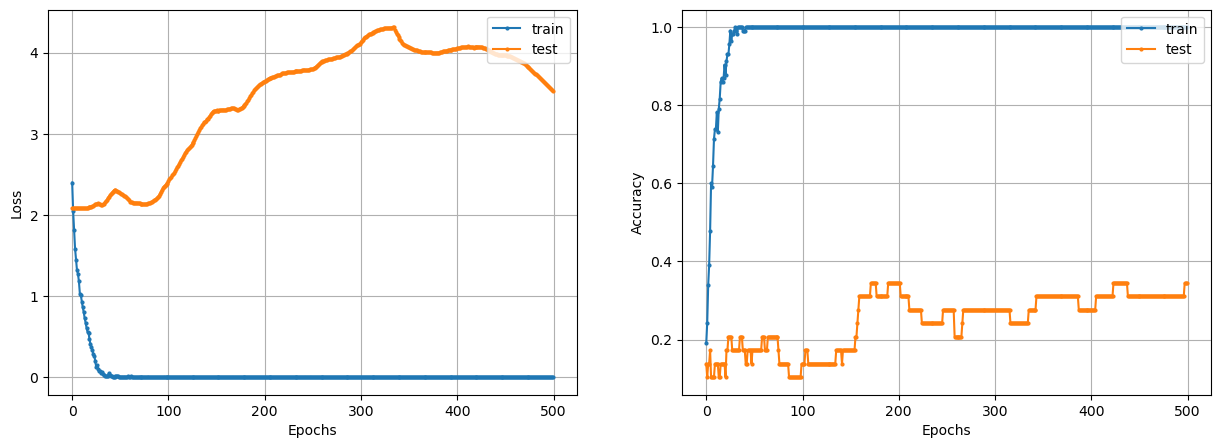

0.3448275923728943 2.0791208744049072
Start subject 2, Len: 5


Edges shape: (2, 907)      Nodes shape: (120, 1000)


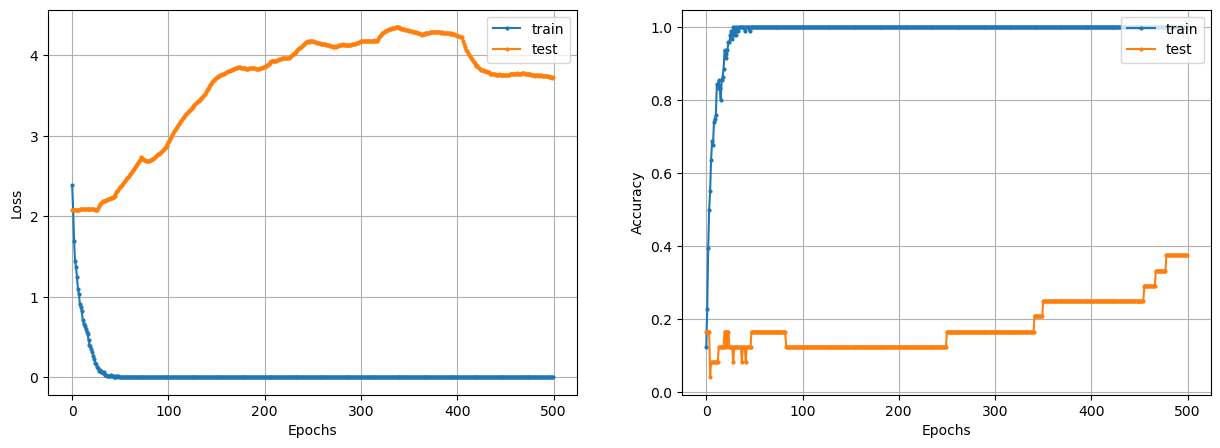

0.375 2.0780537128448486
Start subject 2, Len: 4


Edges shape: (2, 692)      Nodes shape: (96, 1000)


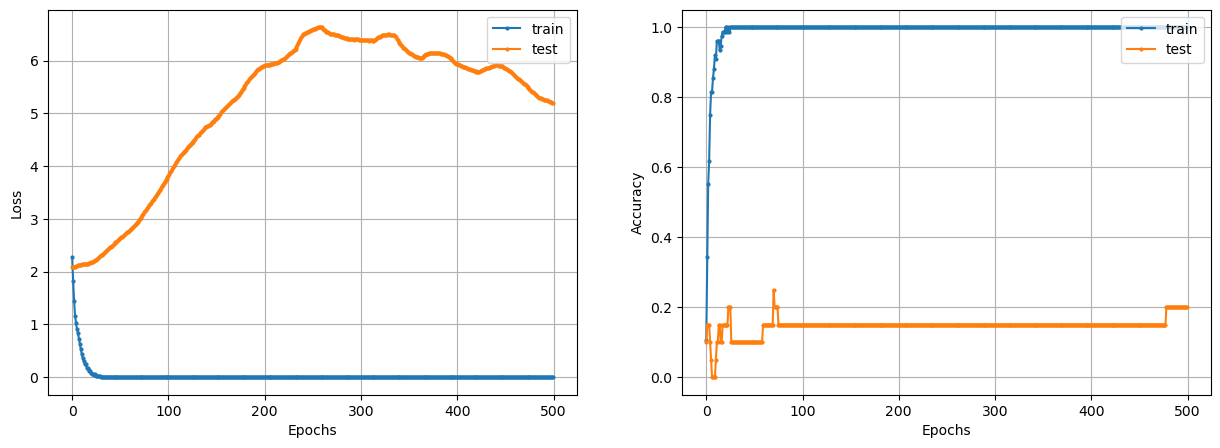

0.25 2.083810329437256
Start subject 2, Len: 3


Edges shape: (2, 477)      Nodes shape: (72, 1000)


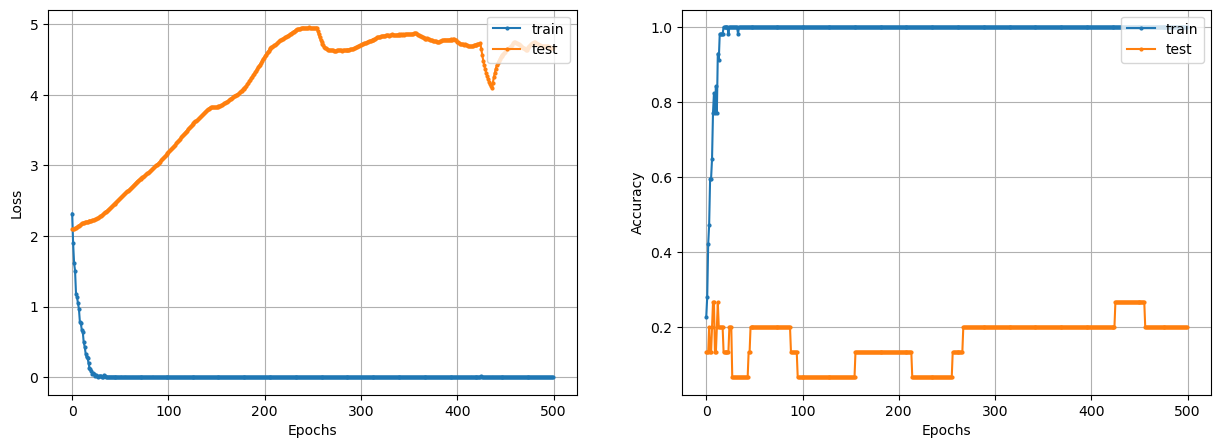

0.2666666805744171 2.095465660095215
Start subject 2, Len: 2


Edges shape: (2, 334)      Nodes shape: (48, 1000)


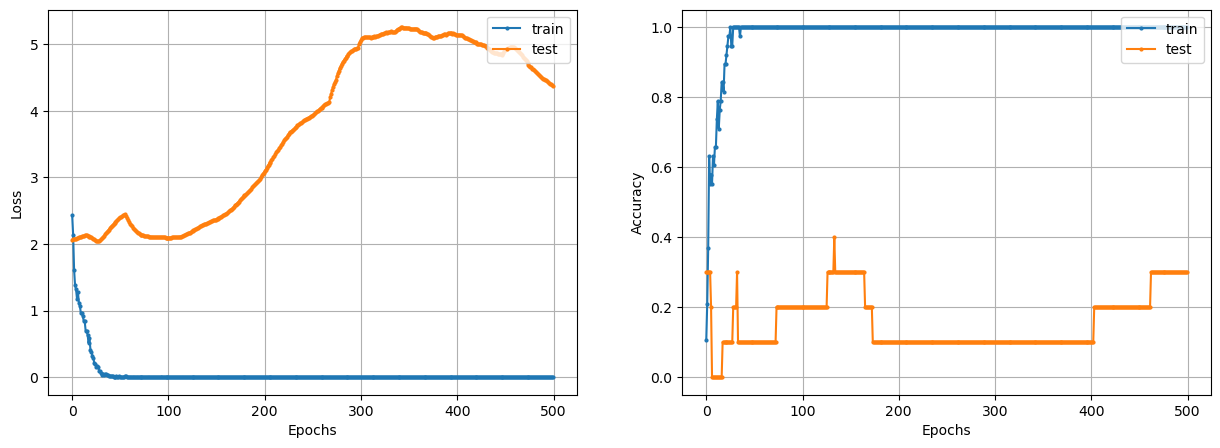

0.4000000059604645 2.0415515899658203
Start subject 2, Len: 1


Edges shape: (2, 143)      Nodes shape: (24, 1000)


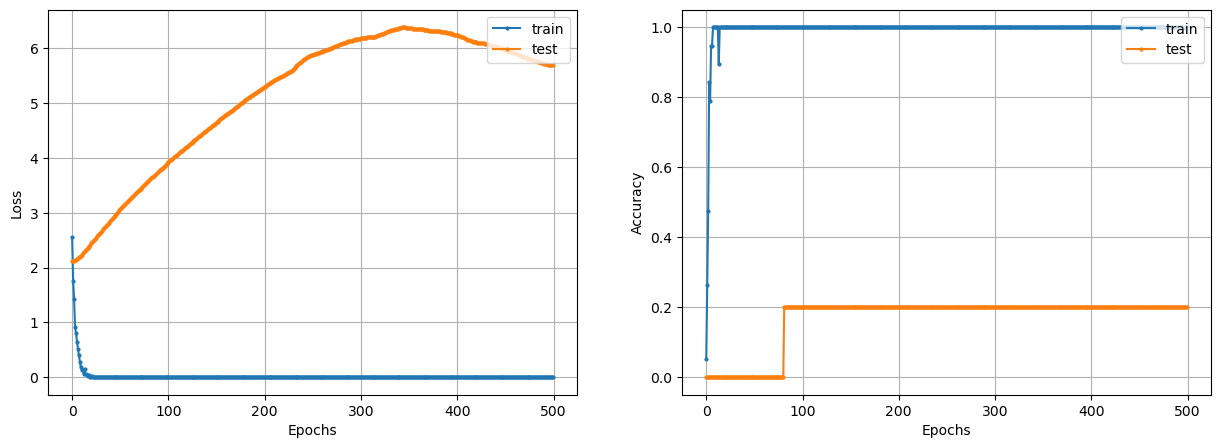

0.20000000298023224 2.1131198406219482
Start subject 3, Len: 15


Edges shape: (2, 3201)      Nodes shape: (360, 1000)


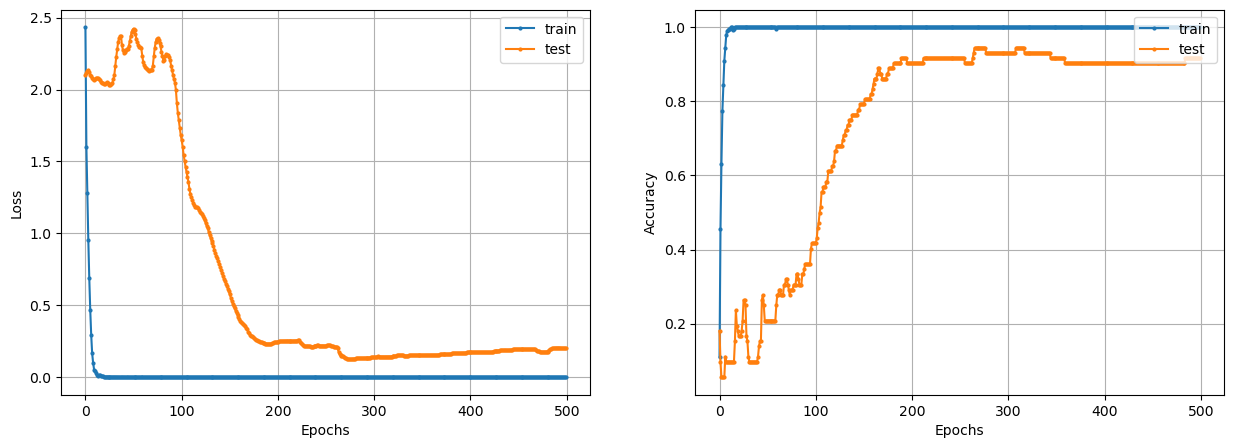

0.9444444179534912 0.1262807548046112
Start subject 3, Len: 14


Edges shape: (2, 2914)      Nodes shape: (336, 1000)


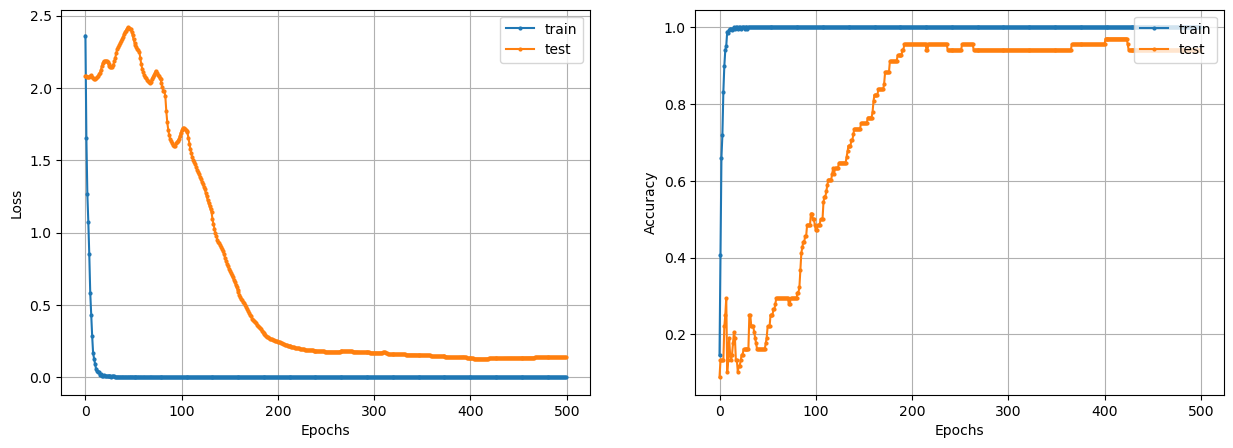

0.970588207244873 0.12746627628803253
Start subject 3, Len: 13


Edges shape: (2, 2627)      Nodes shape: (312, 1000)


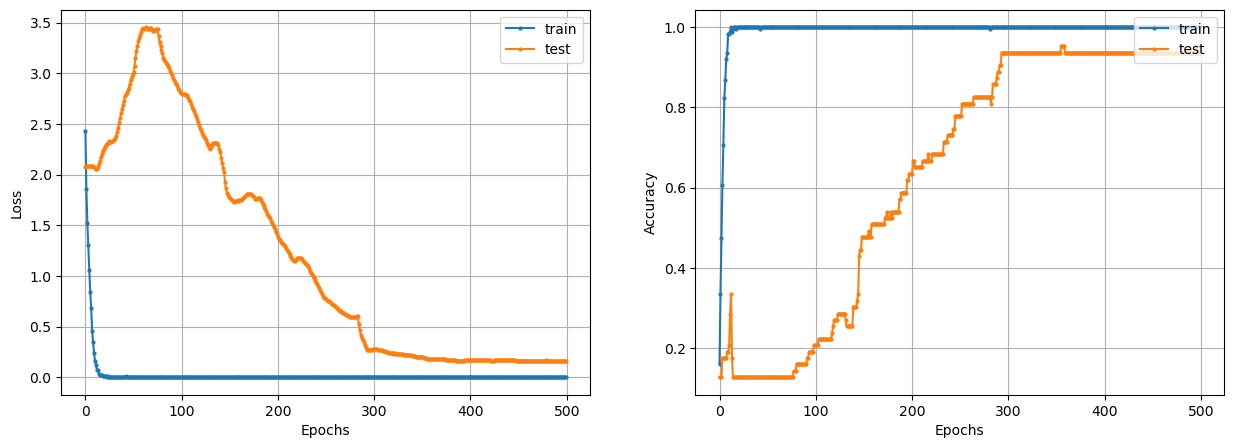

0.9523809552192688 0.15798215568065643
Start subject 3, Len: 12


Edges shape: (2, 2412)      Nodes shape: (288, 1000)


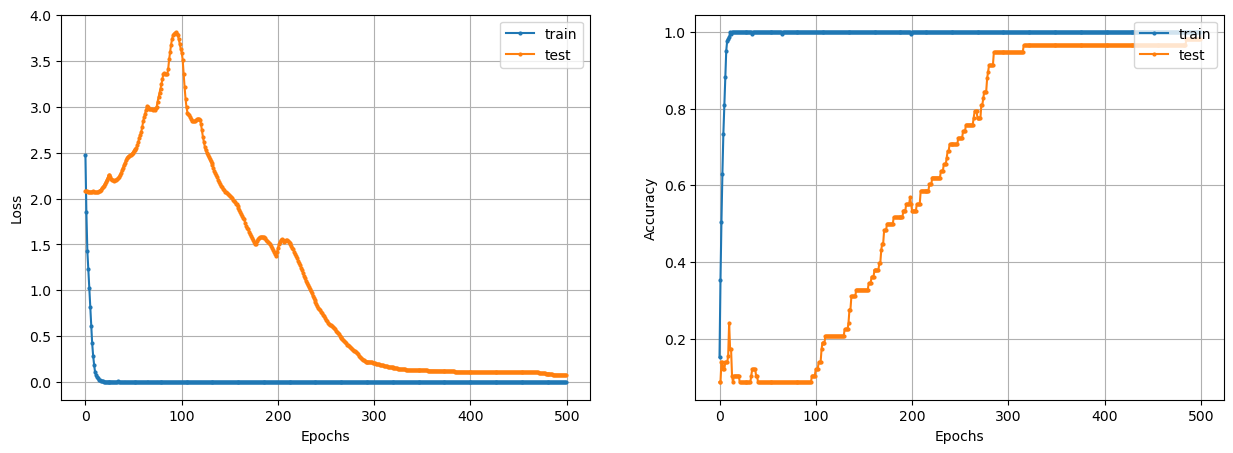

0.982758641242981 0.08057686686515808
Start subject 3, Len: 11


Edges shape: (2, 2197)      Nodes shape: (264, 1000)


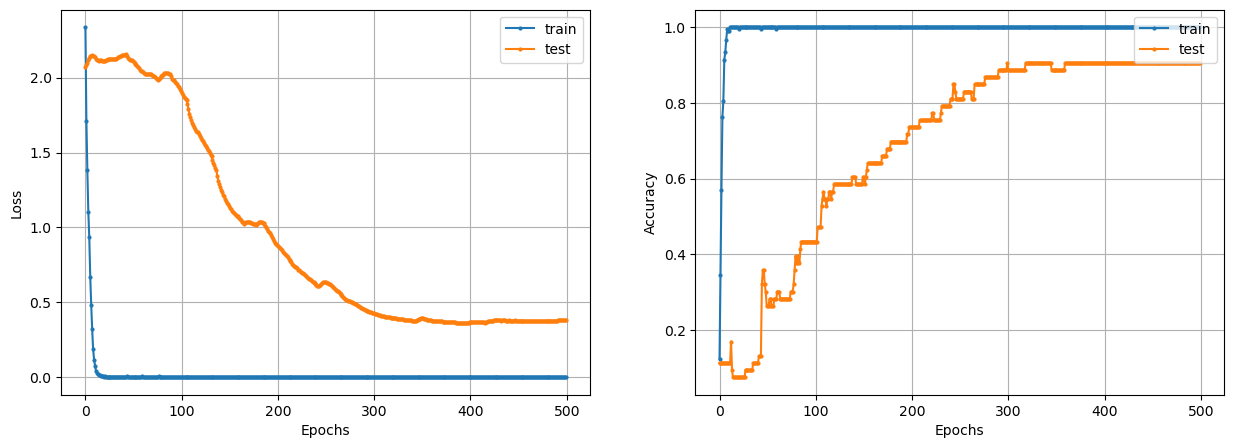

0.9056603908538818 0.3618256151676178
Start subject 3, Len: 10


Edges shape: (2, 2054)      Nodes shape: (240, 1000)


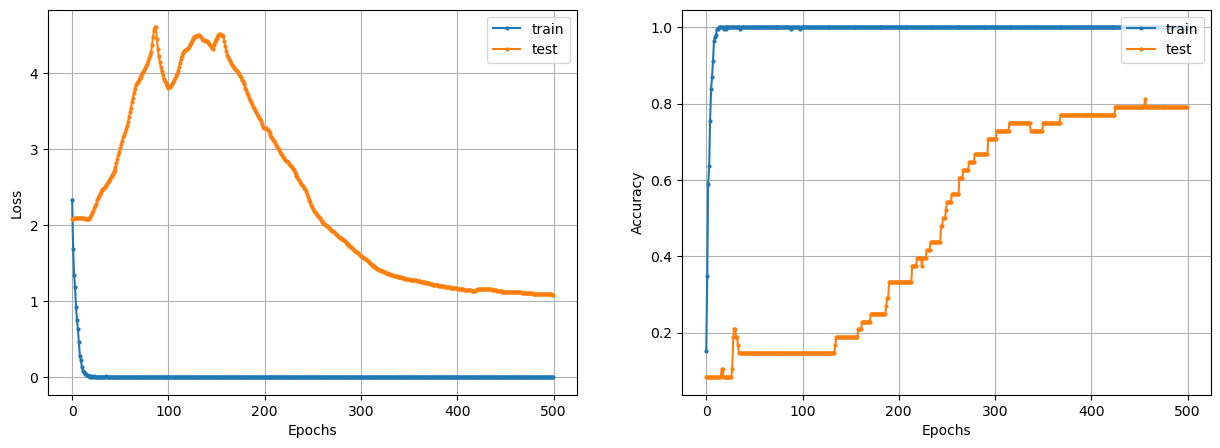

0.8125 1.0886569023132324
Start subject 3, Len: 9


Edges shape: (2, 1863)      Nodes shape: (216, 1000)


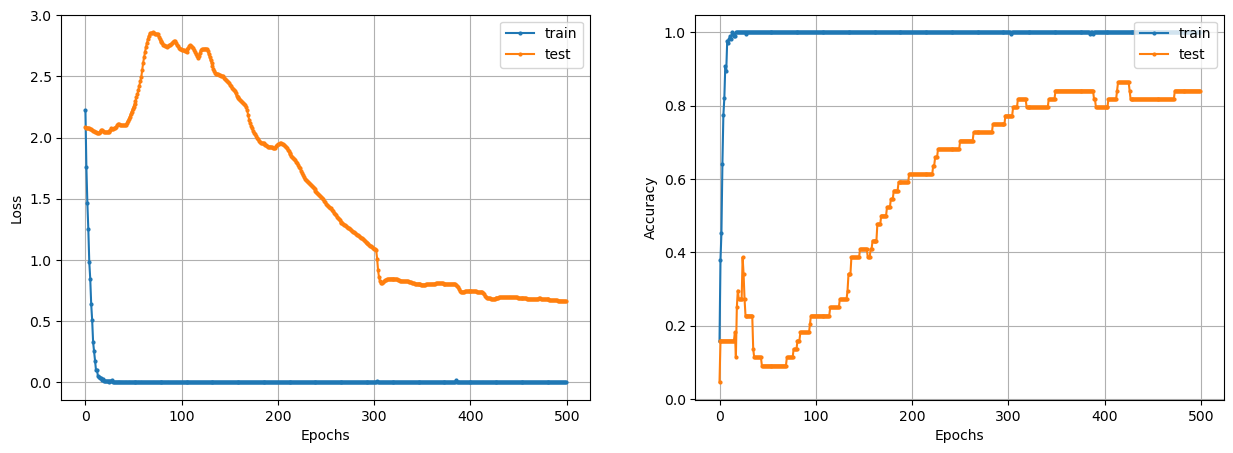

0.8636363744735718 0.6638990044593811
Start subject 3, Len: 8


Edges shape: (2, 1648)      Nodes shape: (192, 1000)


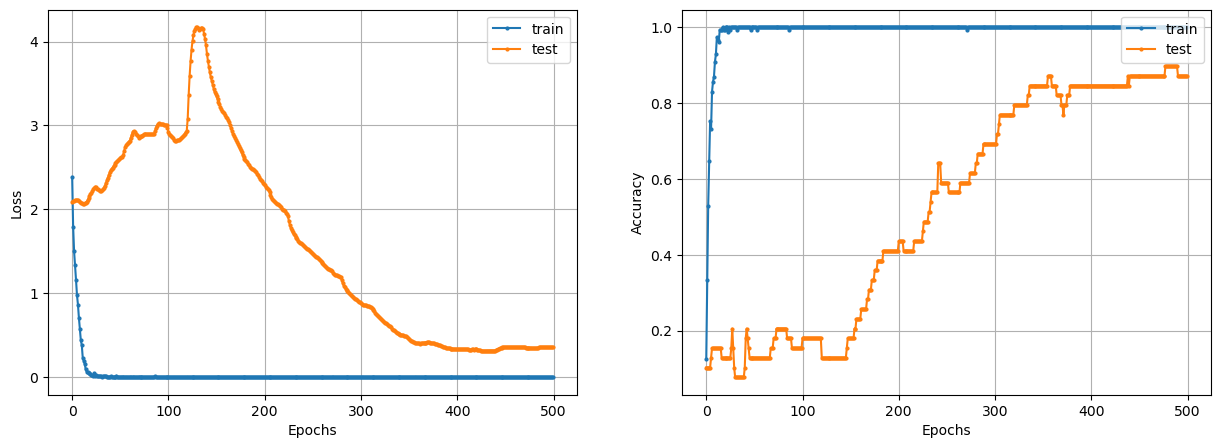

0.8974359035491943 0.3148997724056244
Start subject 3, Len: 7


Edges shape: (2, 1433)      Nodes shape: (168, 1000)


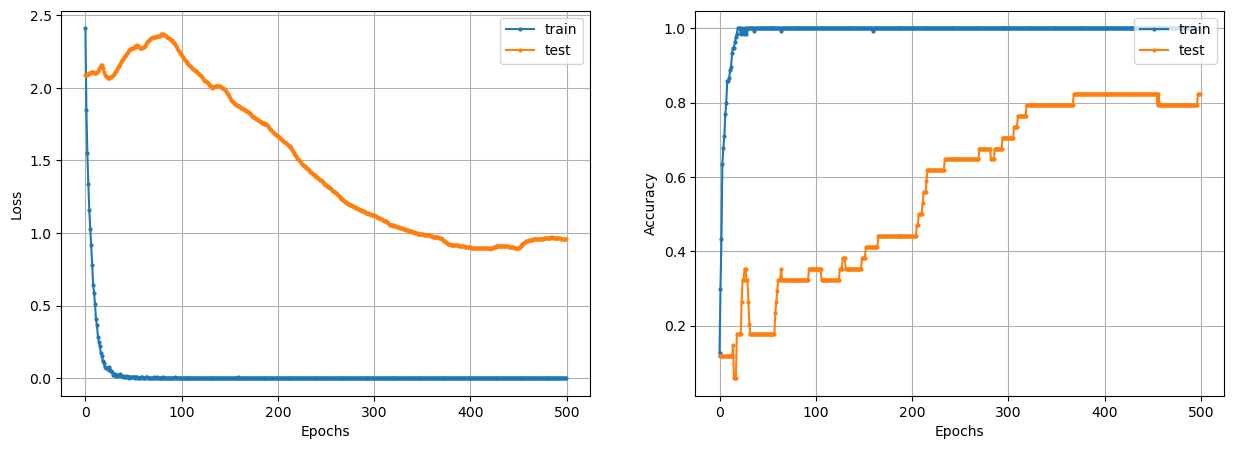

0.8235294222831726 0.8929184675216675
Start subject 3, Len: 6


Edges shape: (2, 1122)      Nodes shape: (144, 1000)


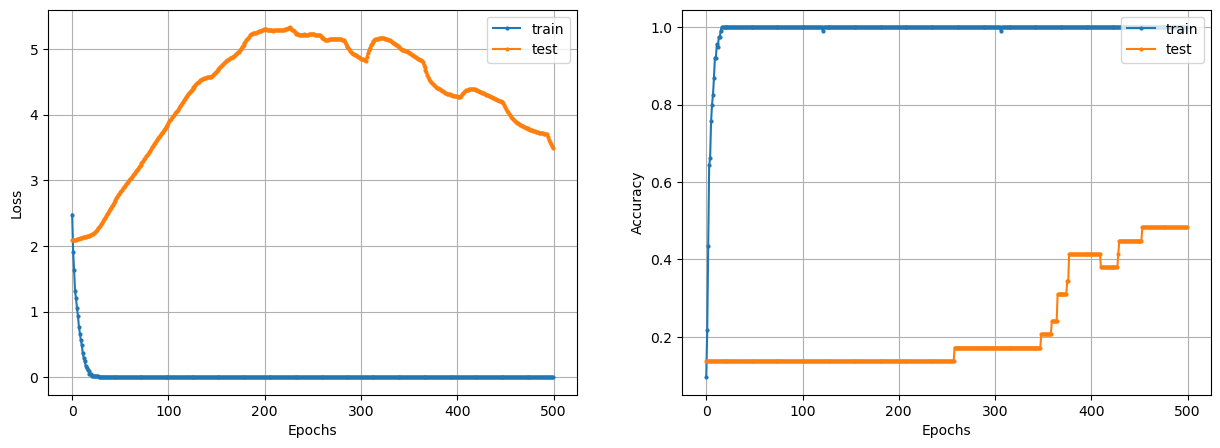

0.48275861144065857 2.084242105484009
Start subject 3, Len: 5


Edges shape: (2, 907)      Nodes shape: (120, 1000)


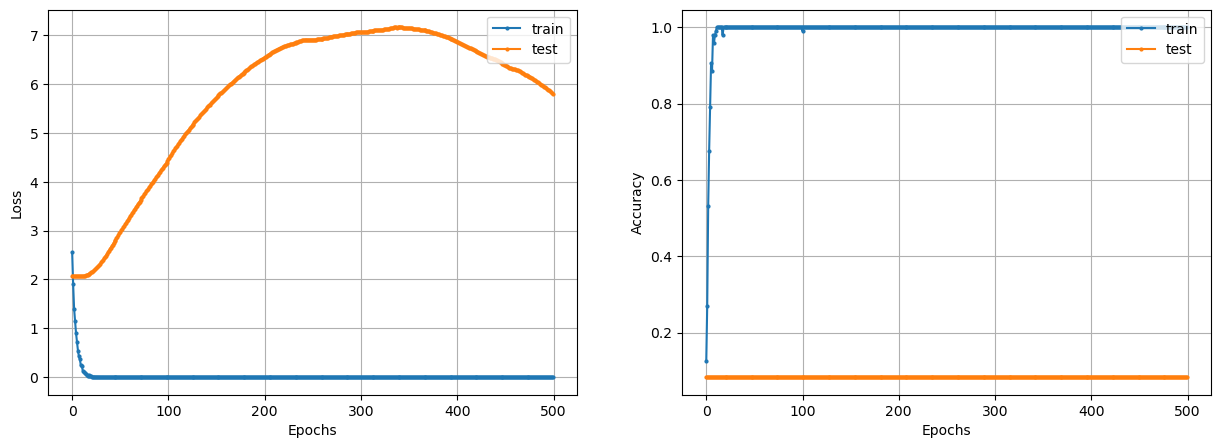

0.0833333358168602 2.064739227294922
Start subject 3, Len: 4


Edges shape: (2, 692)      Nodes shape: (96, 1000)


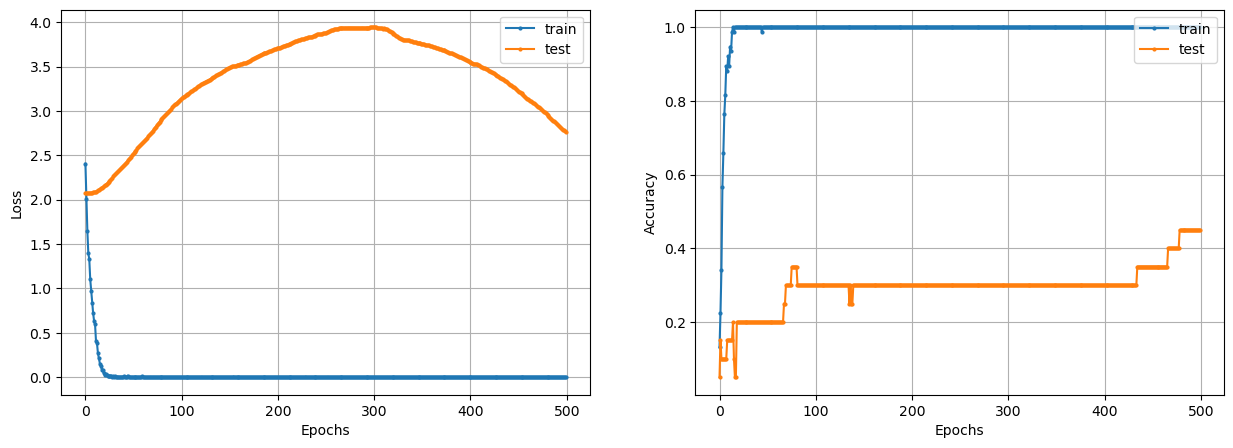

0.44999998807907104 2.074951648712158
Start subject 3, Len: 3


Edges shape: (2, 477)      Nodes shape: (72, 1000)


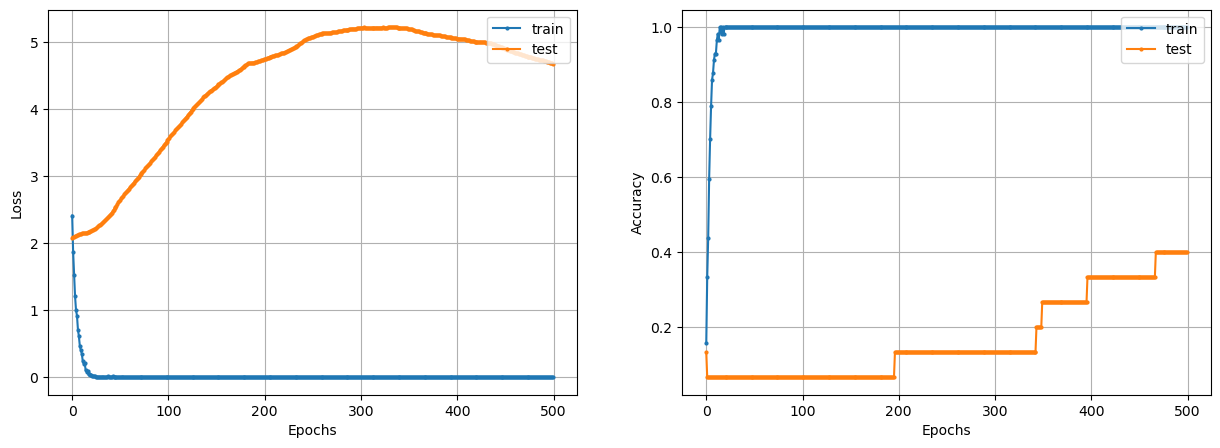

0.4000000059604645 2.0837719440460205
Start subject 3, Len: 2


Edges shape: (2, 334)      Nodes shape: (48, 1000)


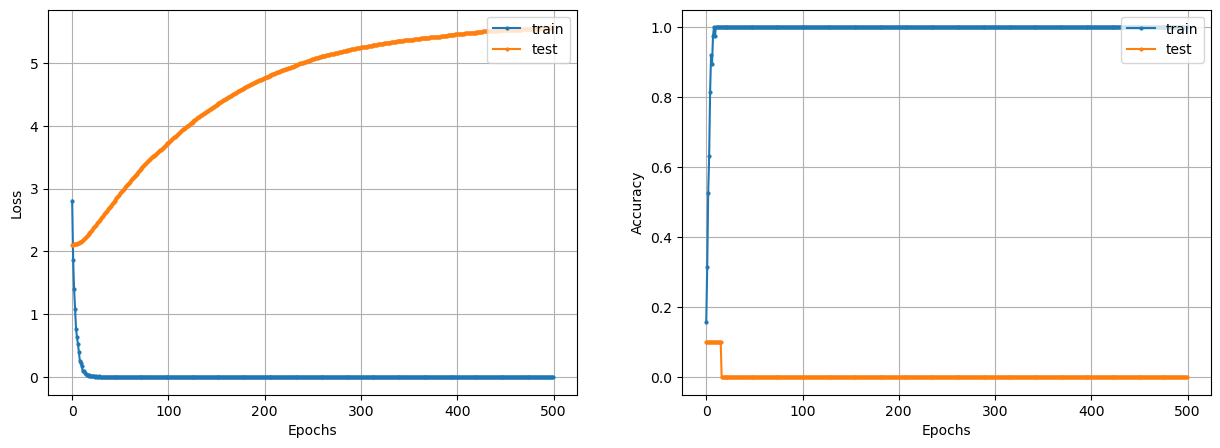

0.10000000149011612 2.1027944087982178
Start subject 3, Len: 1


Edges shape: (2, 143)      Nodes shape: (24, 1000)


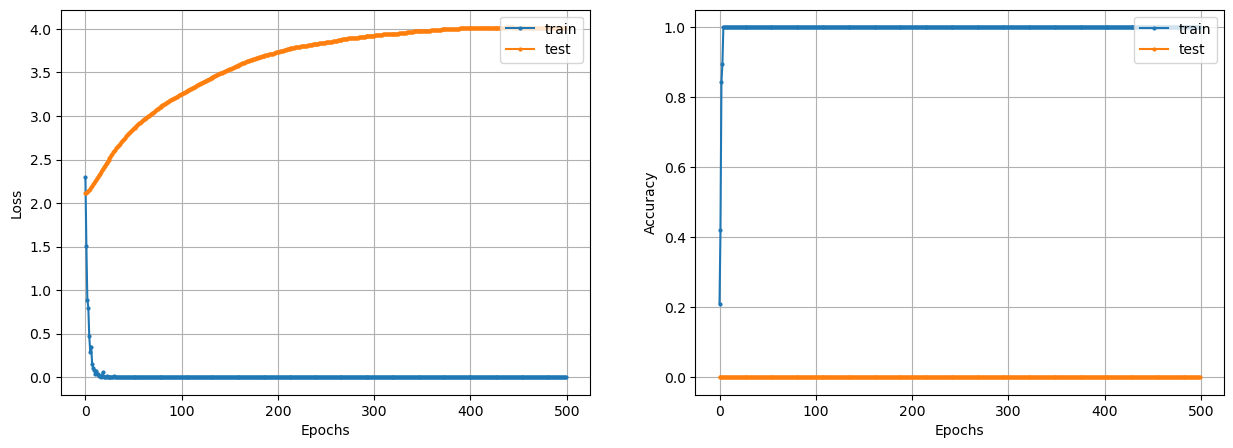

0.0 2.1112759113311768
Start subject 4, Len: 15


Edges shape: (2, 3201)      Nodes shape: (360, 1000)


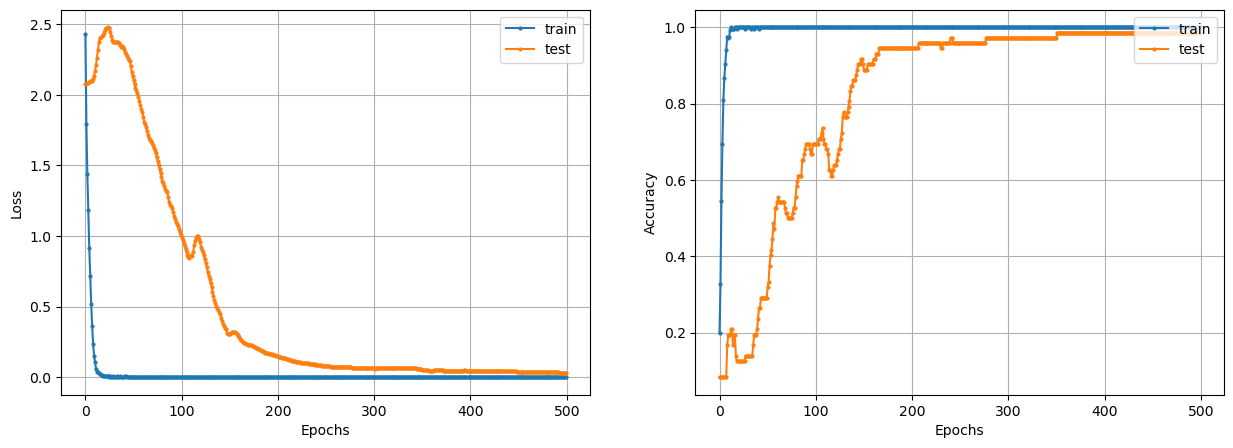

0.9861111044883728 0.03293182700872421
Start subject 4, Len: 14


Edges shape: (2, 2914)      Nodes shape: (336, 1000)


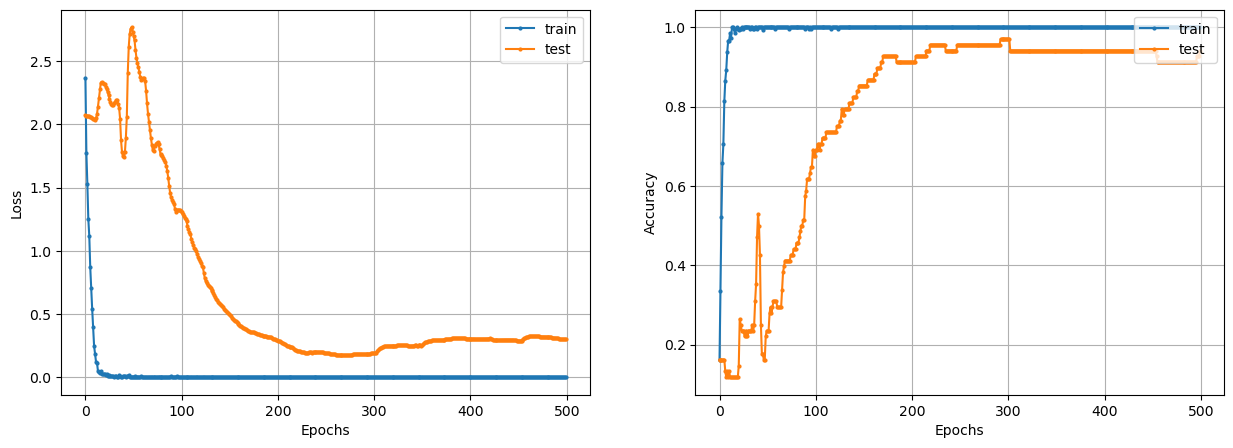

0.970588207244873 0.17284253239631653
Start subject 4, Len: 13


Edges shape: (2, 2627)      Nodes shape: (312, 1000)


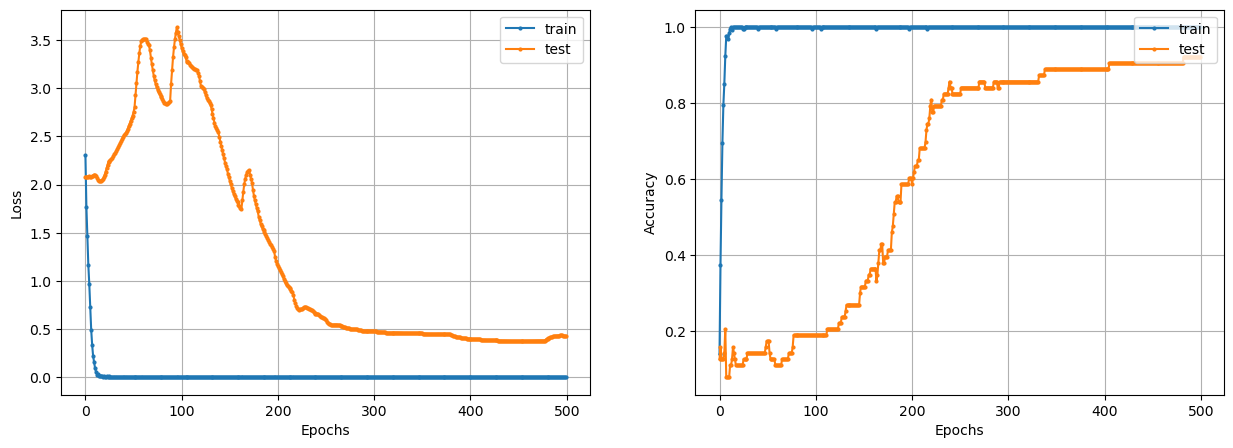

0.920634925365448 0.37416017055511475
Start subject 4, Len: 12


Edges shape: (2, 2412)      Nodes shape: (288, 1000)


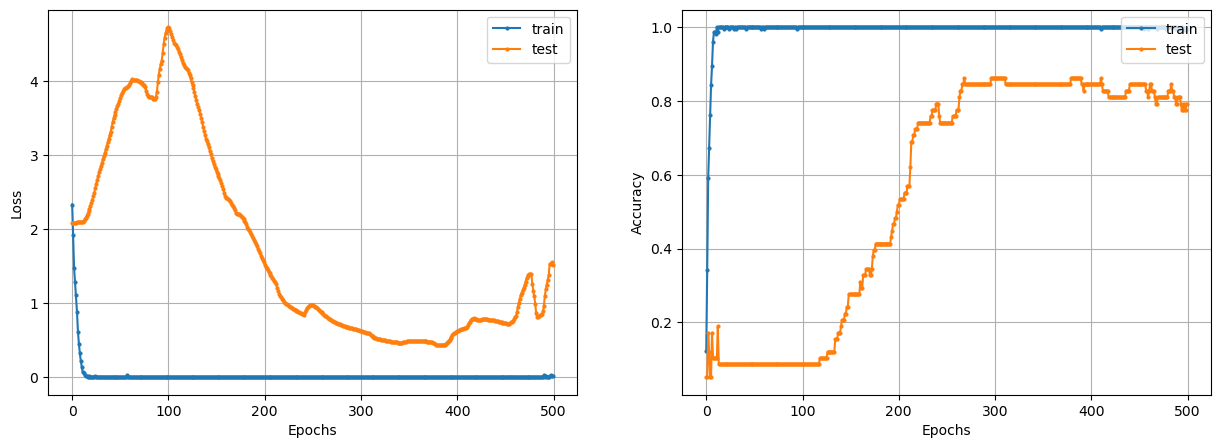

0.8620689511299133 0.4295390844345093
Start subject 4, Len: 11


Edges shape: (2, 2197)      Nodes shape: (264, 1000)


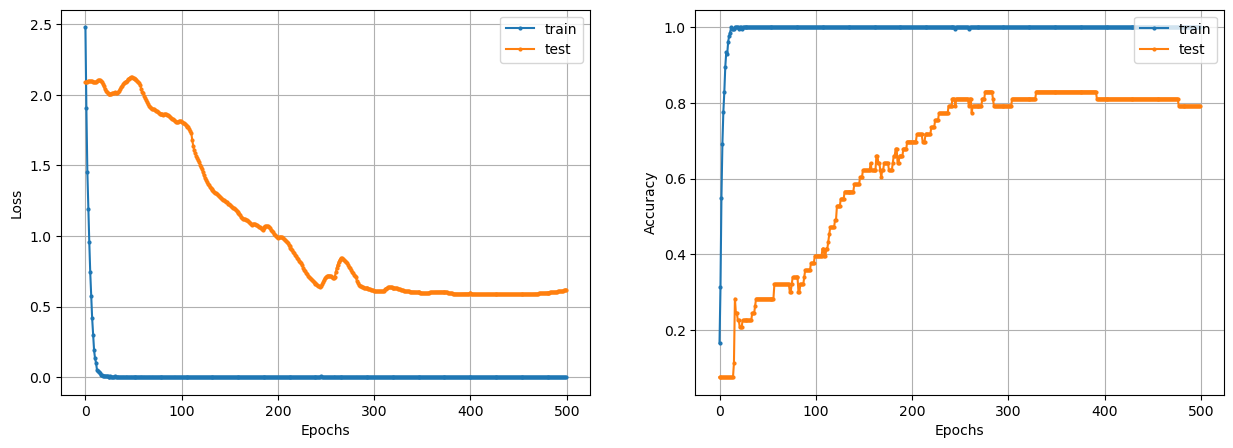

0.8301886916160583 0.588016927242279
Start subject 4, Len: 10


Edges shape: (2, 2054)      Nodes shape: (240, 1000)


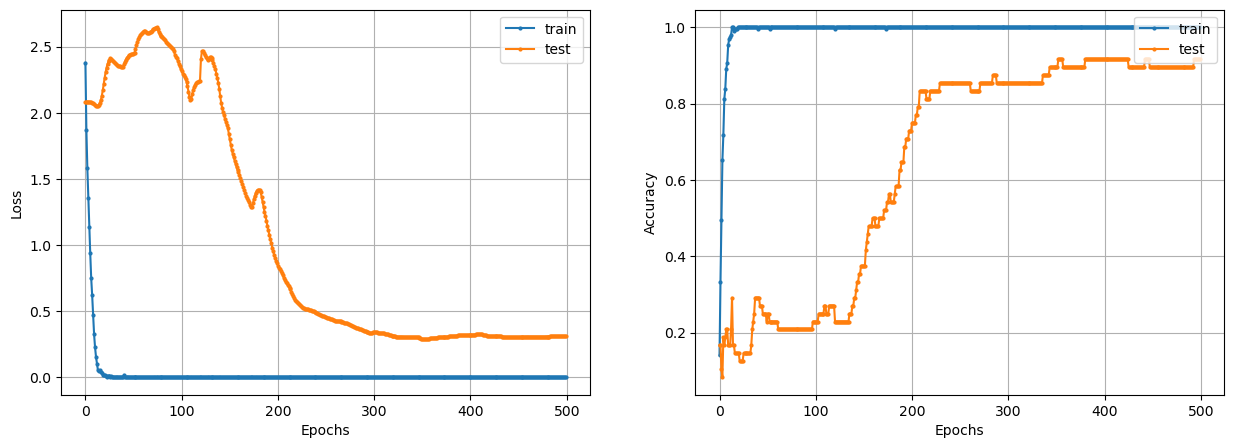

0.9166666865348816 0.28624987602233887
Start subject 4, Len: 9


Edges shape: (2, 1863)      Nodes shape: (216, 1000)


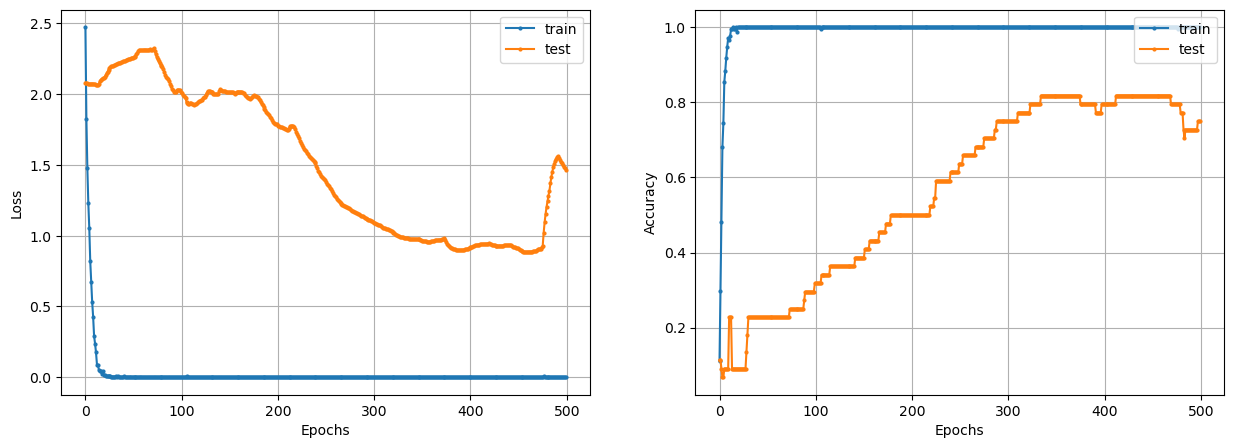

0.8181818127632141 0.8861758708953857
Start subject 4, Len: 8


Edges shape: (2, 1648)      Nodes shape: (192, 1000)


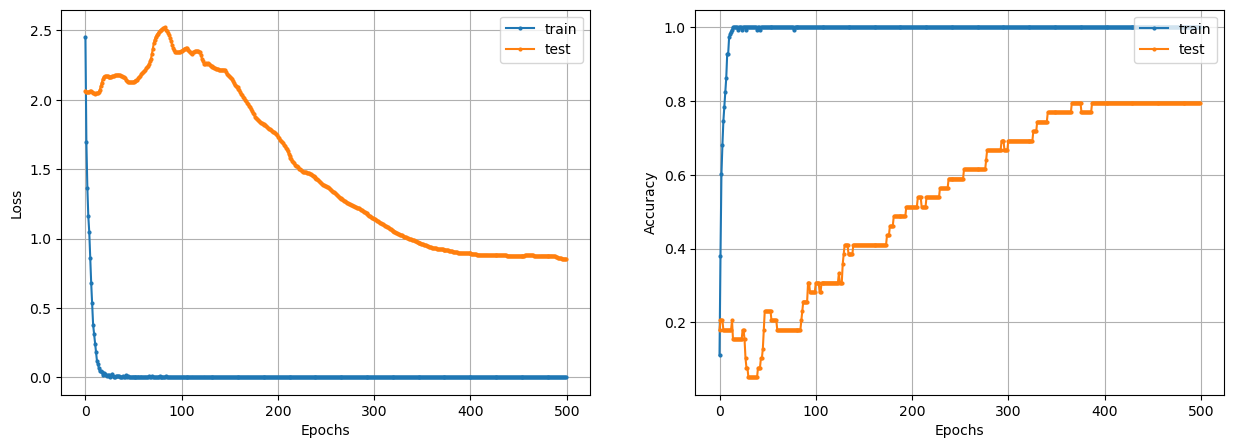

0.7948718070983887 0.8537382483482361
Start subject 4, Len: 7


Edges shape: (2, 1433)      Nodes shape: (168, 1000)


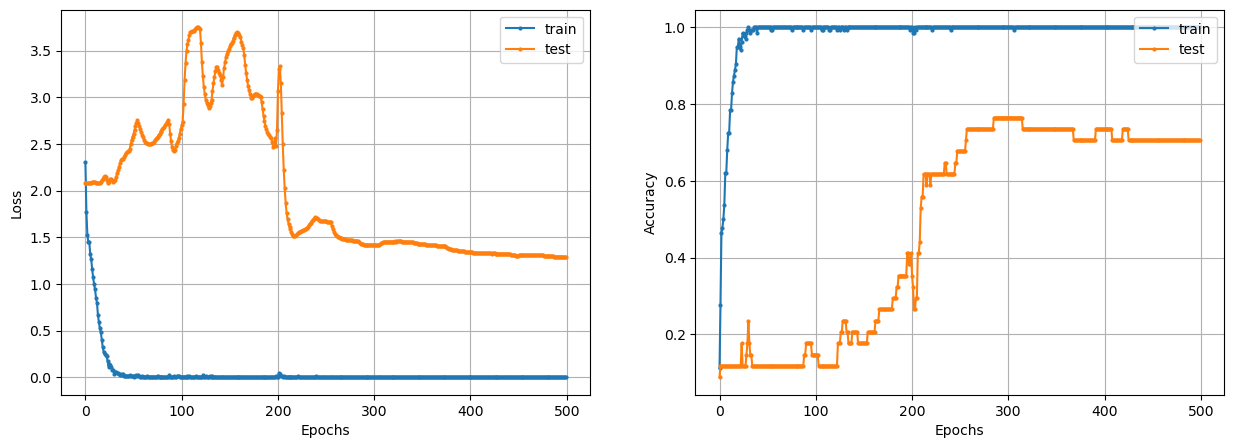

0.7647058963775635 1.2871644496917725
Start subject 4, Len: 6


Edges shape: (2, 1122)      Nodes shape: (144, 1000)


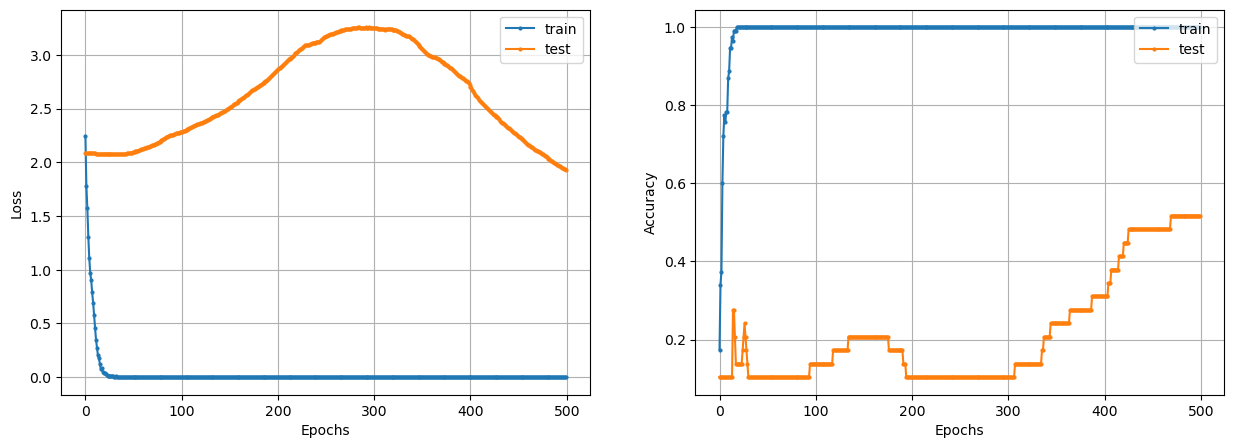

0.517241358757019 1.9276251792907715
Start subject 4, Len: 5


Edges shape: (2, 907)      Nodes shape: (120, 1000)


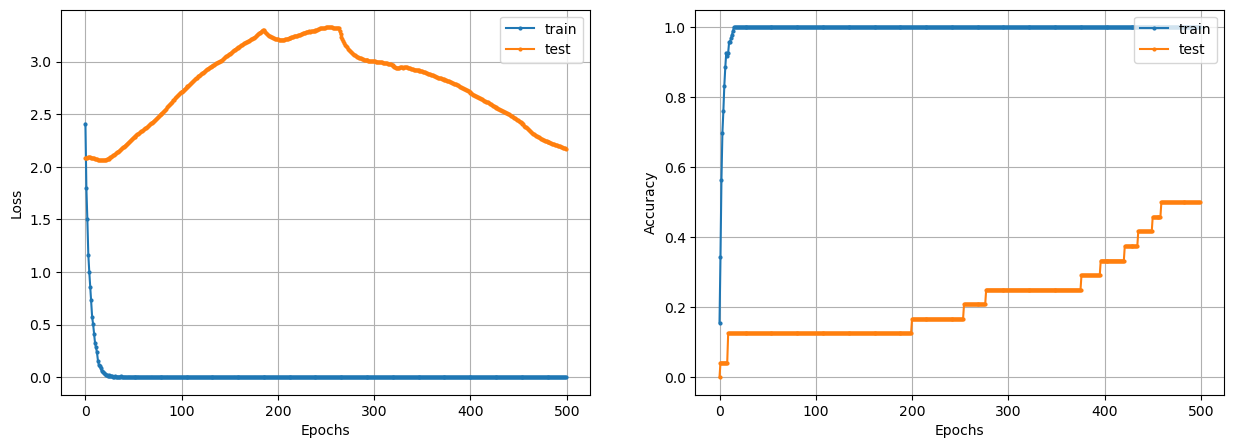

0.5 2.0610580444335938
Start subject 4, Len: 4


Edges shape: (2, 692)      Nodes shape: (96, 1000)


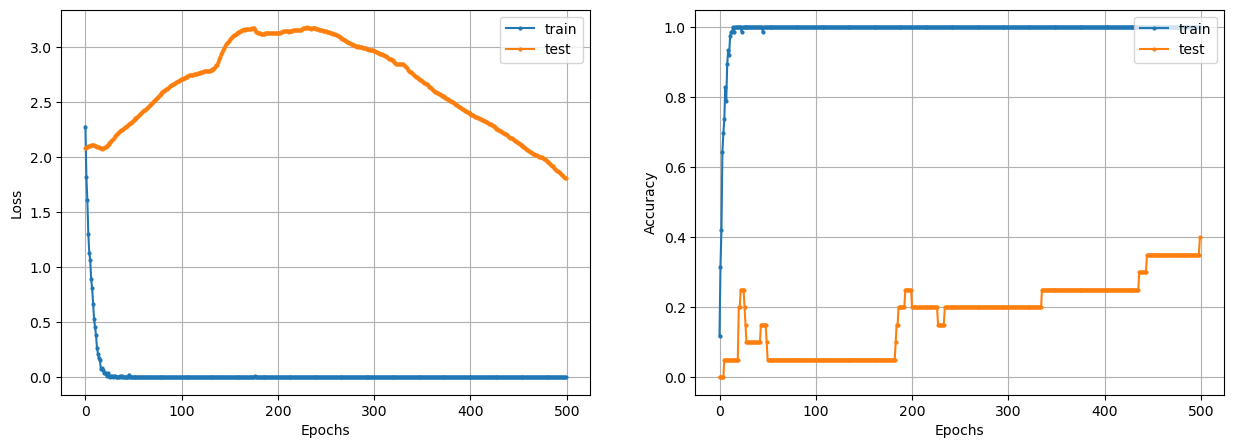

0.4000000059604645 1.8124210834503174
Start subject 4, Len: 3


Edges shape: (2, 477)      Nodes shape: (72, 1000)


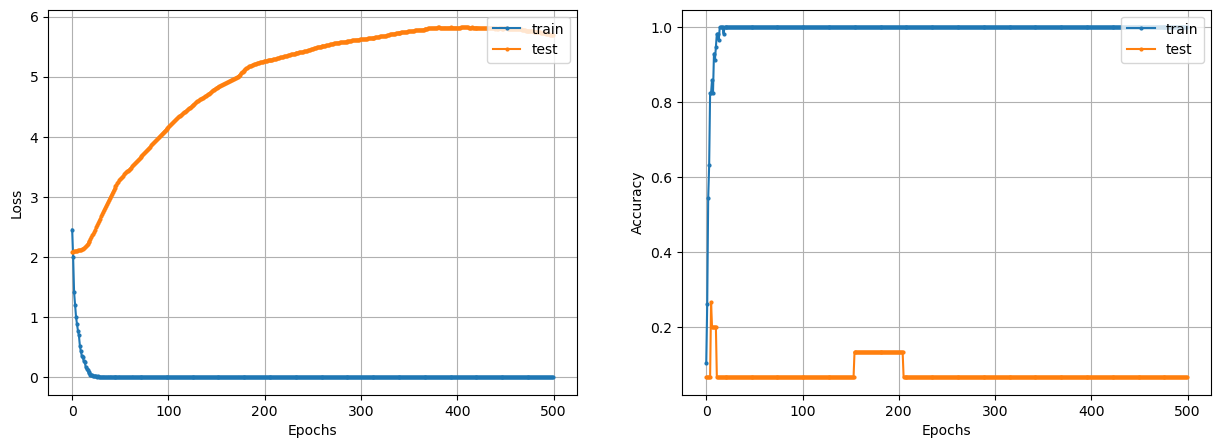

0.2666666805744171 2.086240291595459
Start subject 4, Len: 2


Edges shape: (2, 334)      Nodes shape: (48, 1000)


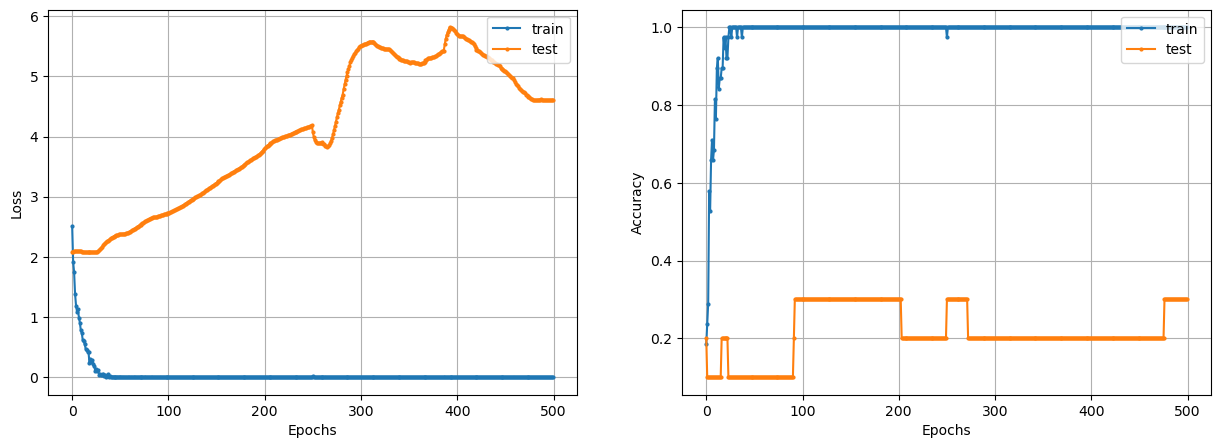

0.30000001192092896 2.0727932453155518
Start subject 4, Len: 1


Edges shape: (2, 143)      Nodes shape: (24, 1000)


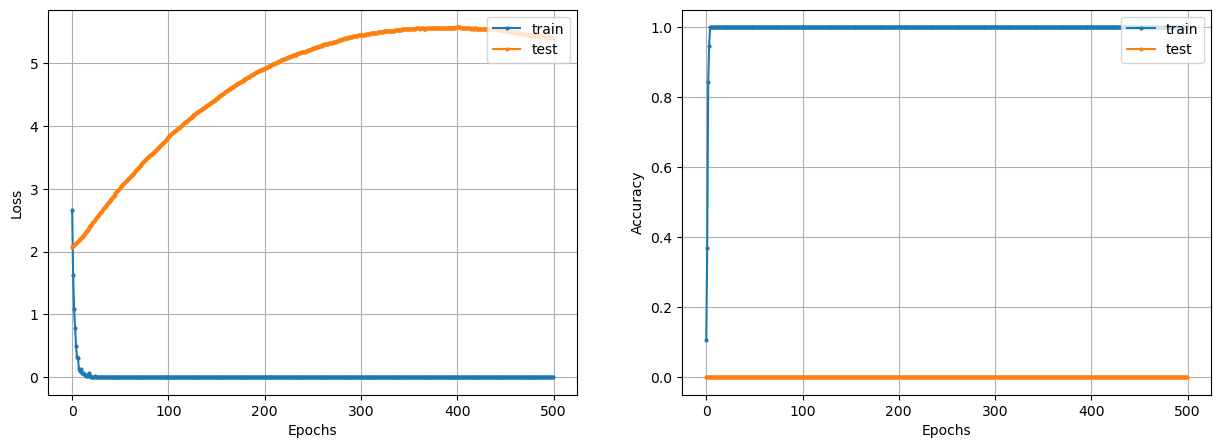

0.0 2.078169107437134
Start subject 5, Len: 15


Edges shape: (2, 3201)      Nodes shape: (360, 1000)


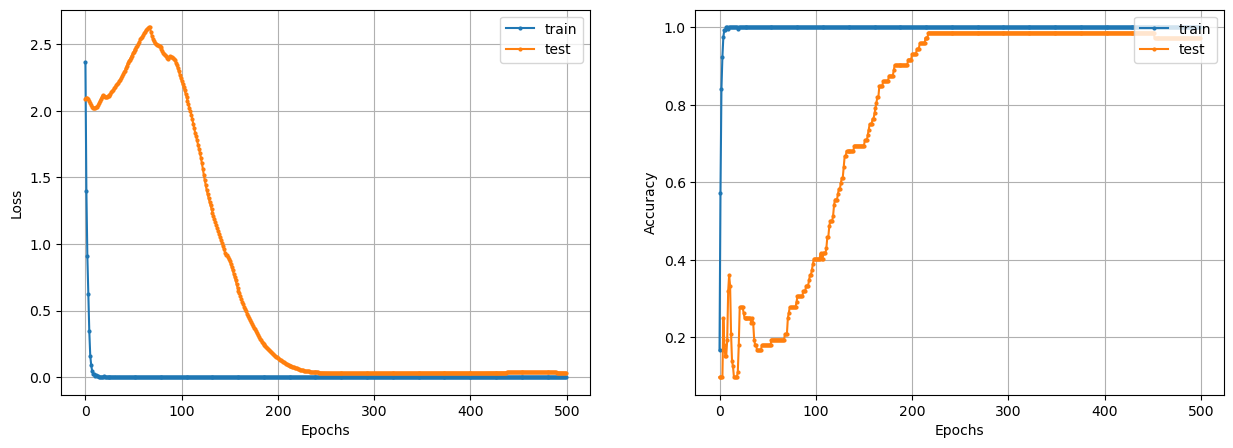

0.9861111044883728 0.0309650506824255
Start subject 5, Len: 14


Edges shape: (2, 2914)      Nodes shape: (336, 1000)


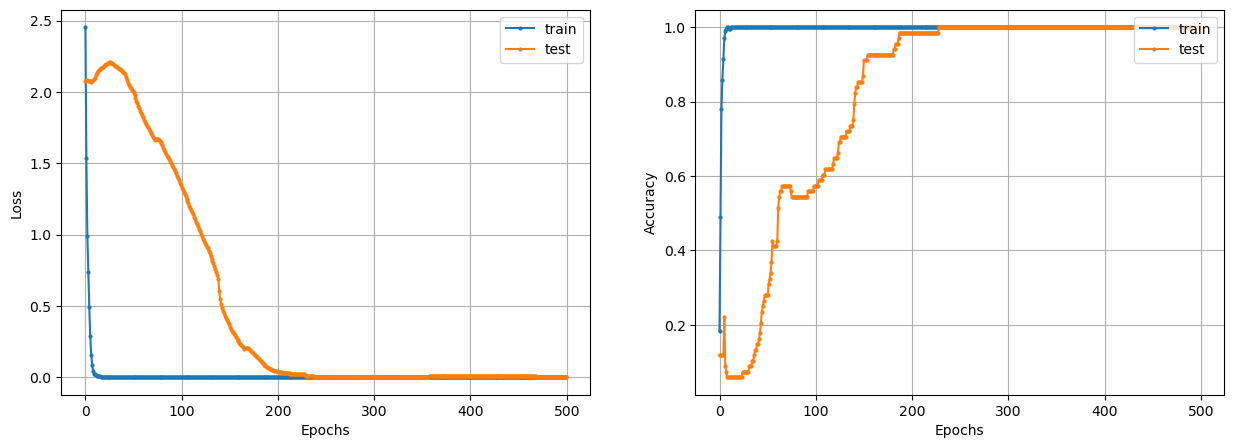

1.0 0.003871791996061802
Start subject 5, Len: 13


Edges shape: (2, 2627)      Nodes shape: (312, 1000)


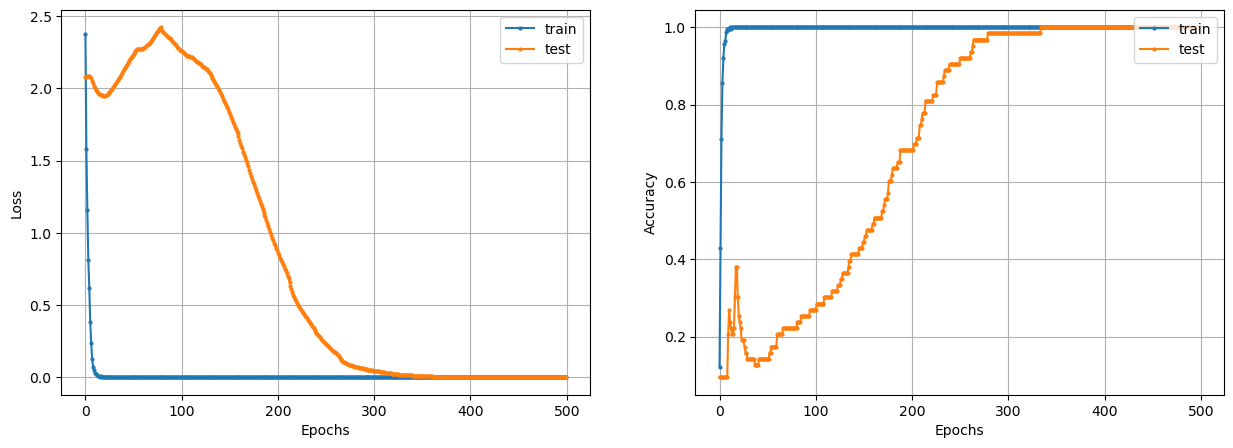

1.0 0.00036496963002718985
Start subject 5, Len: 12


Edges shape: (2, 2412)      Nodes shape: (288, 1000)


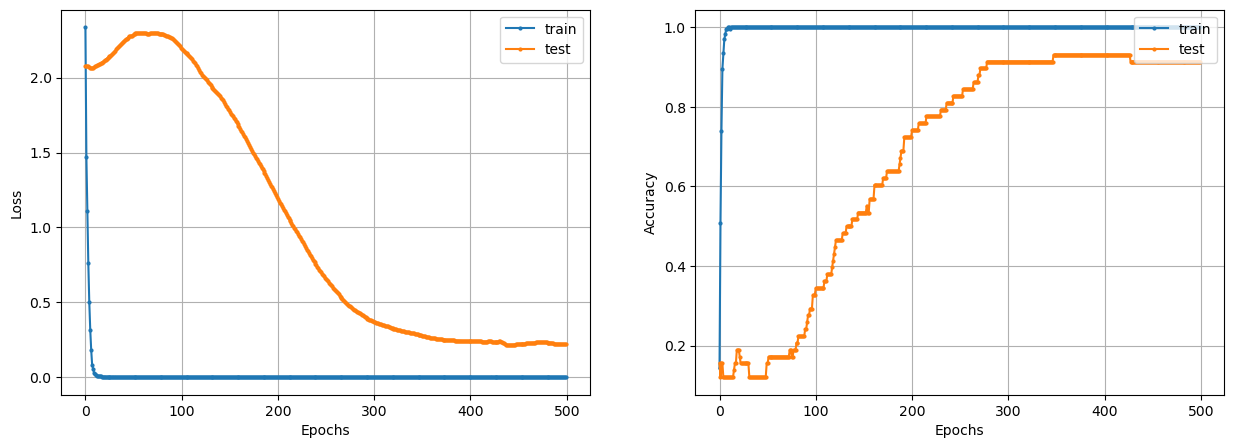

0.931034505367279 0.2151610553264618
Start subject 5, Len: 11


Edges shape: (2, 2197)      Nodes shape: (264, 1000)


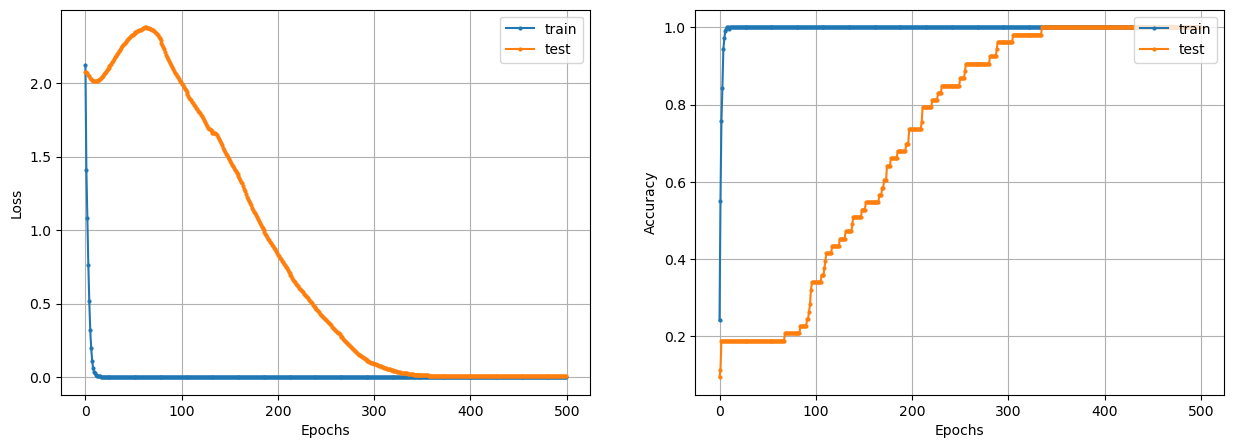

1.0 0.005276679061353207
Start subject 5, Len: 10


Edges shape: (2, 2054)      Nodes shape: (240, 1000)


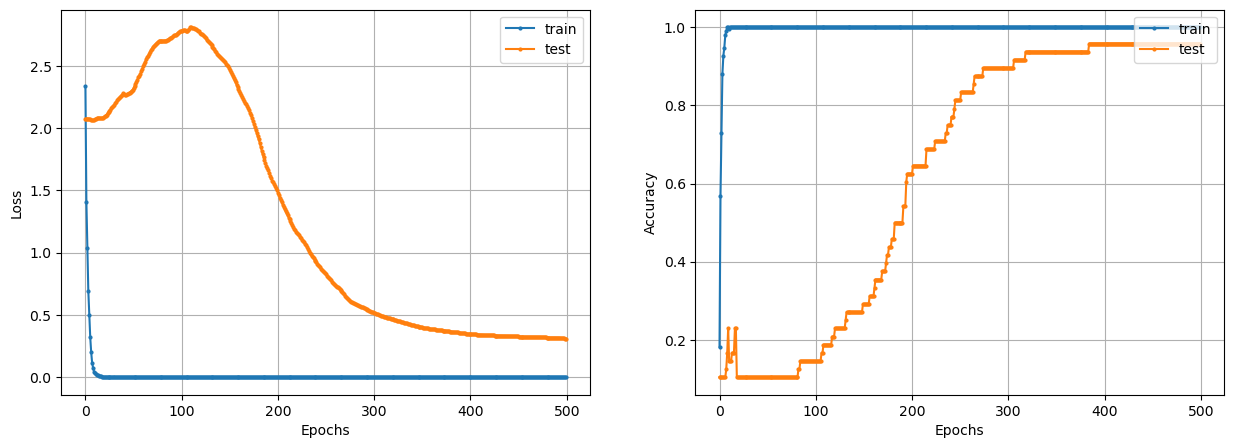

0.9583333134651184 0.31025680899620056
Start subject 5, Len: 9


Edges shape: (2, 1863)      Nodes shape: (216, 1000)


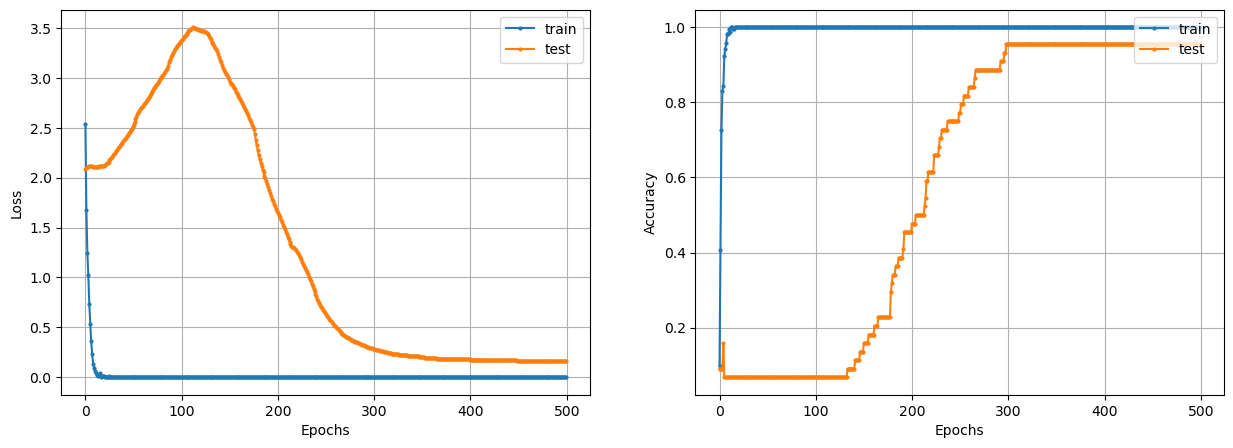

0.9545454382896423 0.16007275879383087
Start subject 5, Len: 8


Edges shape: (2, 1648)      Nodes shape: (192, 1000)


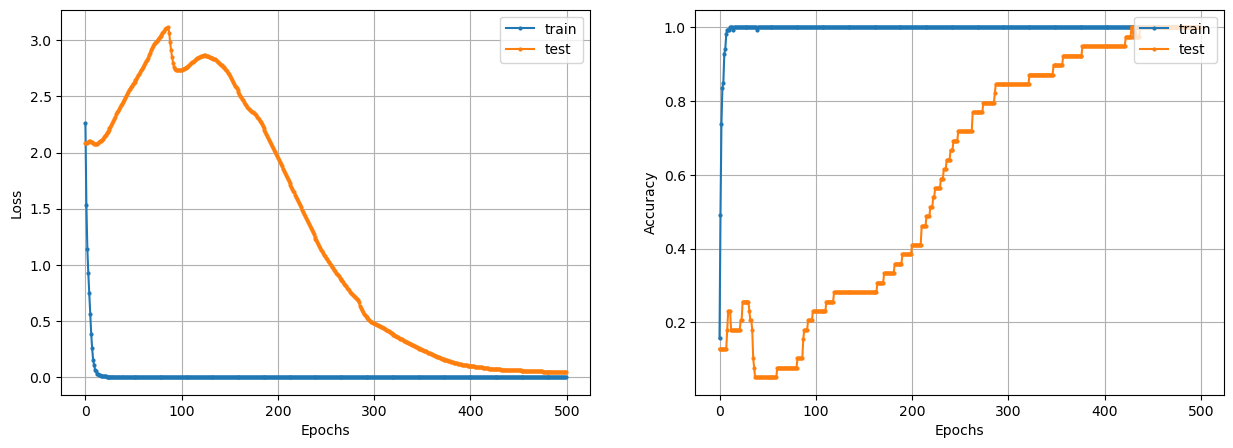

1.0 0.04308495670557022
Start subject 5, Len: 7


Edges shape: (2, 1433)      Nodes shape: (168, 1000)


KeyboardInterrupt: 

In [13]:
import random
pat = './performance_eval/'
ROW = 3 #select Best row here

for subject in range(6,11):
    for no_sen in range(1,16):
        LST_sensor = []
        for i in range(128):
            if i%8 == ROW:
                LST_sensor.append(i)
            
        for j in range(no_sen):
            LST_sensor.remove(random.choice(LST_sensor))

        print("Start subject {}, Len: {}\n======================================================\n\n".format(subject, len(LST_sensor)))
        df = build_df(LST_sensor, subject)
        graph, graph_info, x_train, y_train = build_graph_works_larger_than_16(df, LST_sensor)
        #draw_graph(graph)

        gnn_model = build_gnn_model(graph_info, num_classes, hidden_units, dropout_rate)

        val = gnn_model.fit(x=x_train, y=y_train, epochs=500, batch_size=batch_size, validation_split=0.2,
                            #callbacks=[lr_scheduler,early_stopping],
                            verbose = 0)

        plot(val)

        ACC = val.history['val_acc']
        LOSS = val.history['val_loss']
        print(np.max(ACC), np.min(LOSS))
        pd.DataFrame(ACC).to_csv(pat+'S{}/val_acc_missing_sensors_{}.csv'.format(subject, no_sen))
        pd.DataFrame(LOSS).to_csv(pat+'S{}/val_loss_missing_sensors_{}.csv'.format(subject, no_sen))

Start subject 5, Len: 10


Edges shape: (2, 2054)      Nodes shape: (240, 1000)


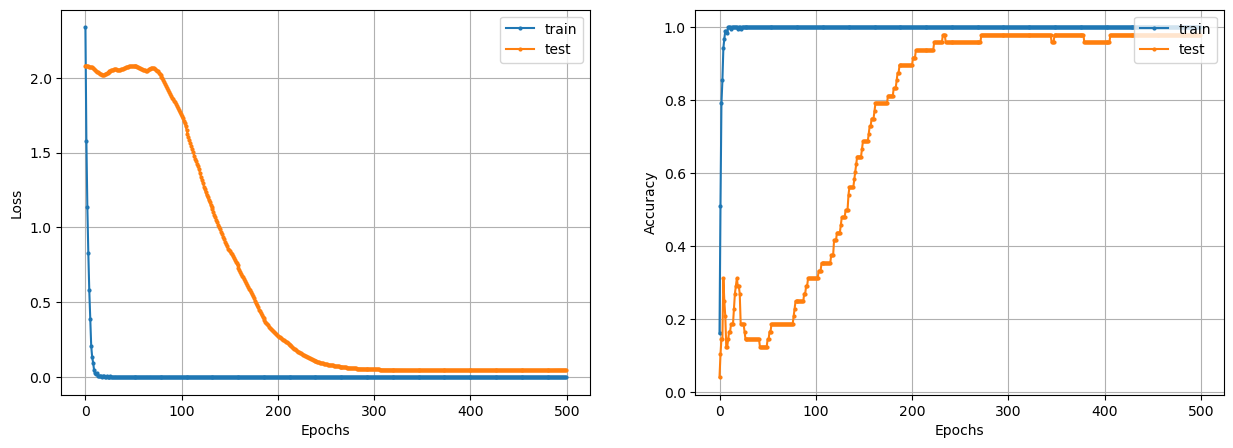

0.9791666865348816 0.04499121010303497
Start subject 5, Len: 9


Edges shape: (2, 1863)      Nodes shape: (216, 1000)


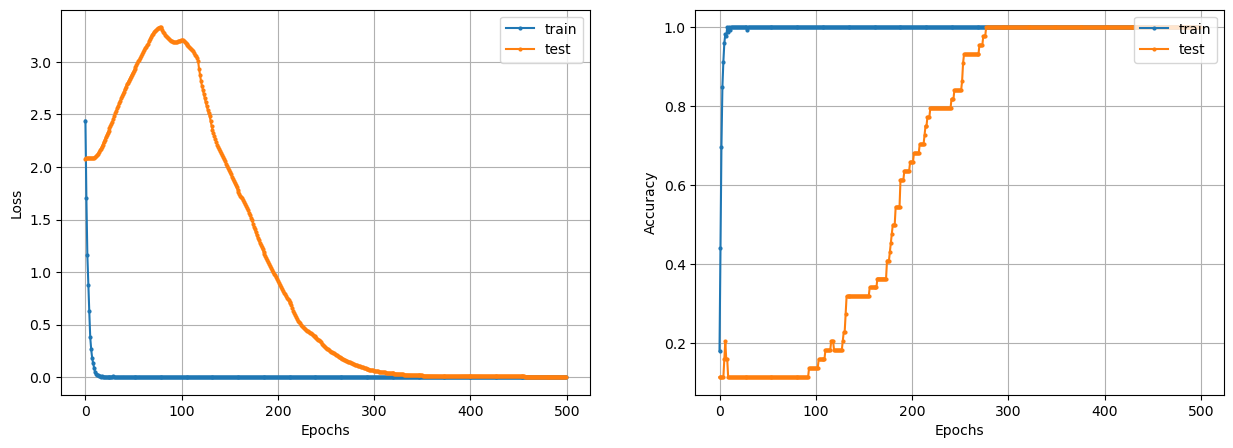

1.0 0.005570870358496904
Start subject 5, Len: 8


Edges shape: (2, 1648)      Nodes shape: (192, 1000)


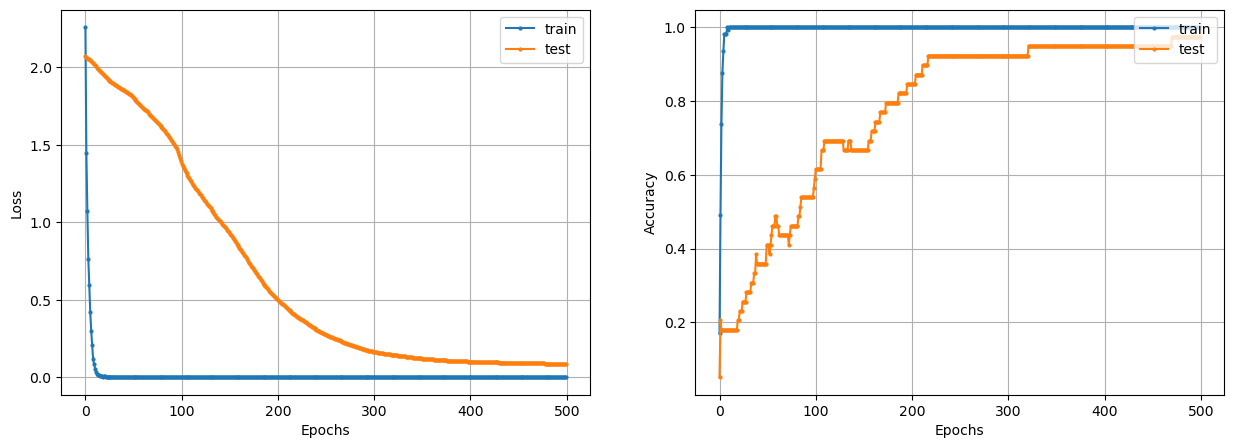

0.9743589758872986 0.08378099650144577
Start subject 5, Len: 7


Edges shape: (2, 1433)      Nodes shape: (168, 1000)


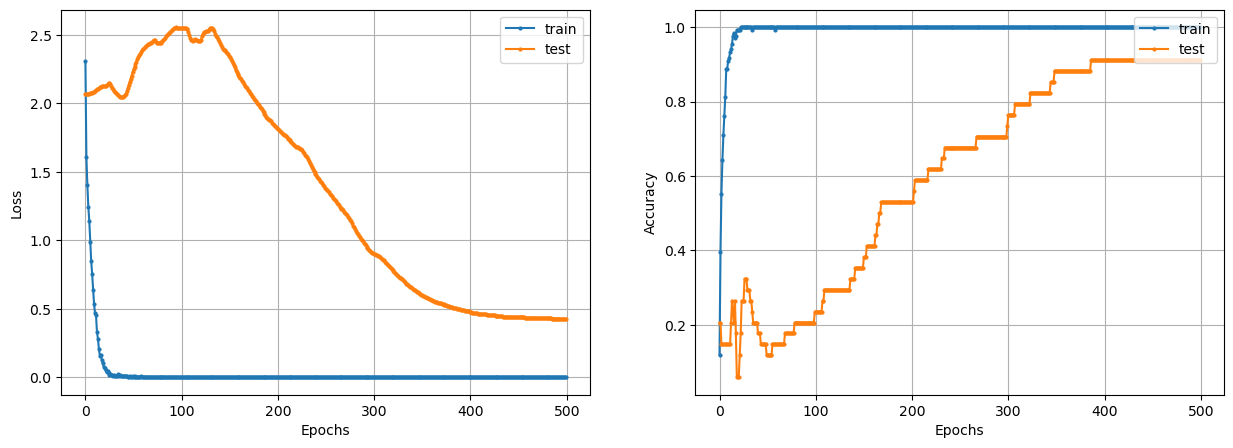

0.9117646813392639 0.42651423811912537
Start subject 5, Len: 6


Edges shape: (2, 1122)      Nodes shape: (144, 1000)


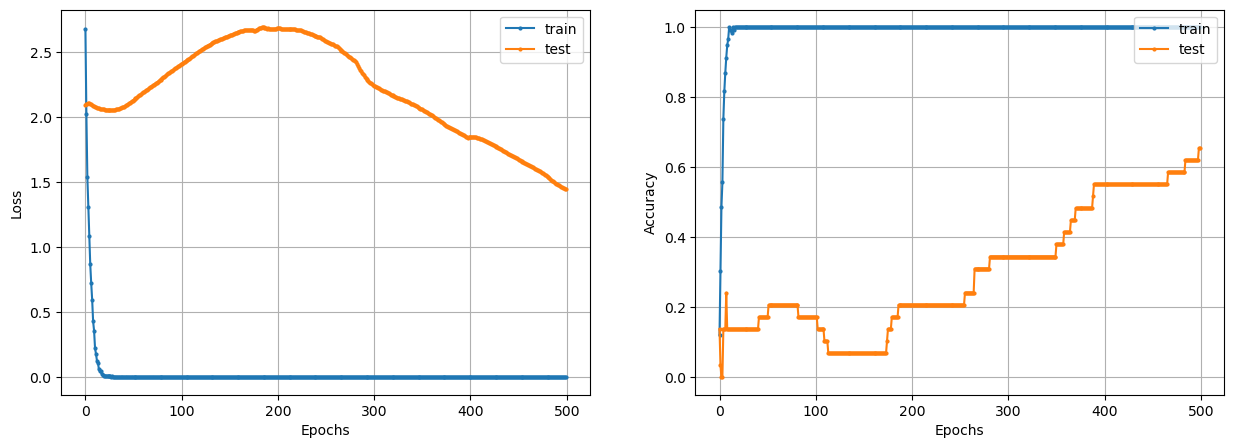

0.6551724076271057 1.4437551498413086
Start subject 5, Len: 5


Edges shape: (2, 907)      Nodes shape: (120, 1000)


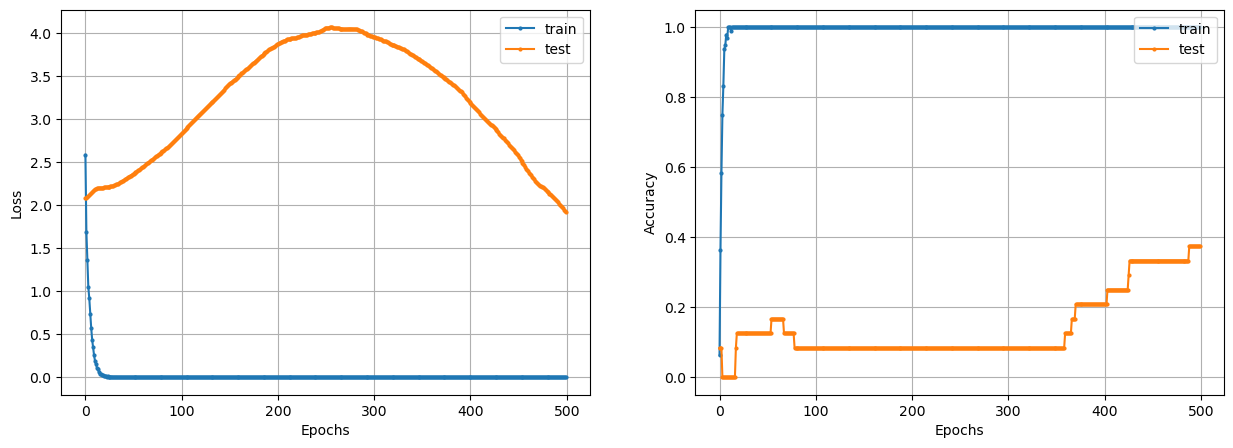

0.375 1.9235557317733765
Start subject 5, Len: 4


Edges shape: (2, 692)      Nodes shape: (96, 1000)


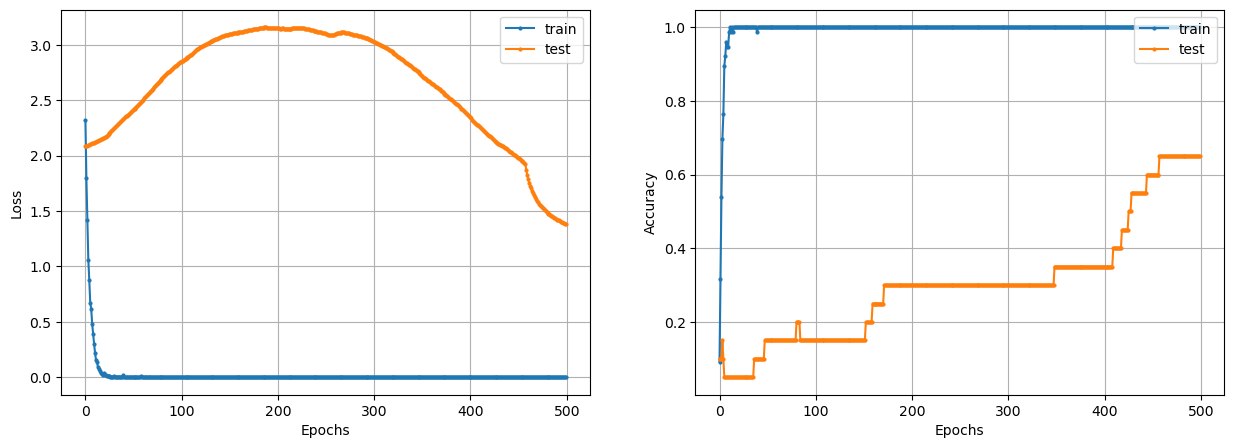

0.6499999761581421 1.3803646564483643
Start subject 5, Len: 3


Edges shape: (2, 477)      Nodes shape: (72, 1000)


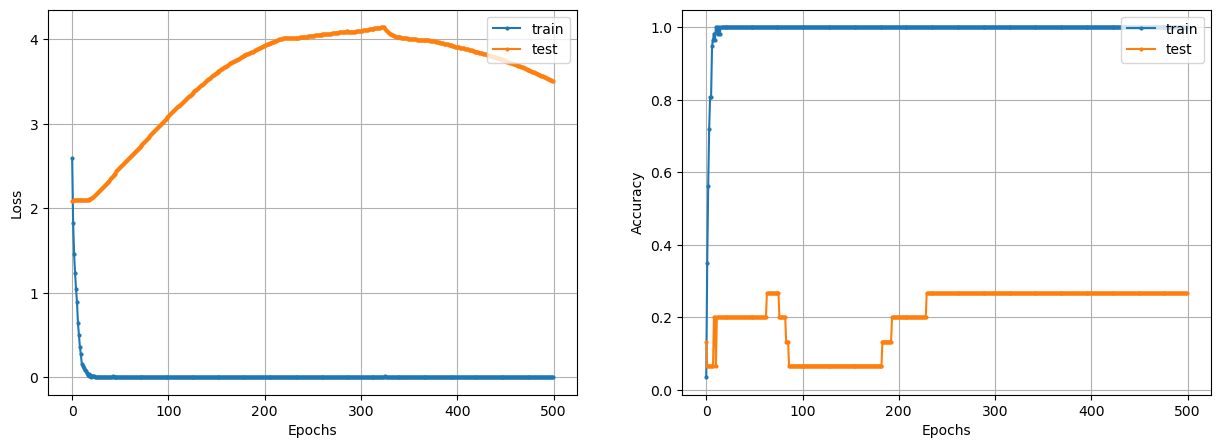

0.2666666805744171 2.0838897228240967
Start subject 5, Len: 2


Edges shape: (2, 334)      Nodes shape: (48, 1000)


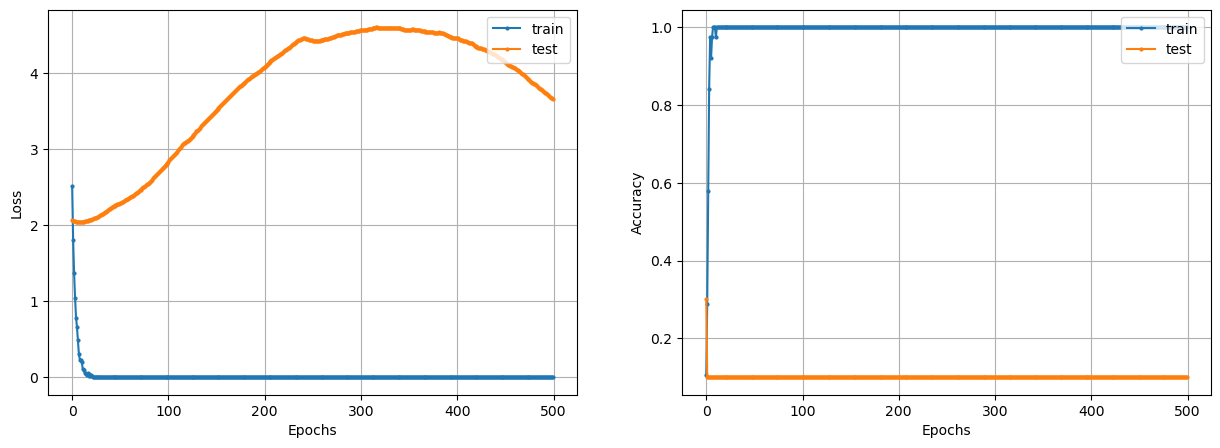

0.30000001192092896 2.044935703277588
Start subject 5, Len: 1


Edges shape: (2, 143)      Nodes shape: (24, 1000)


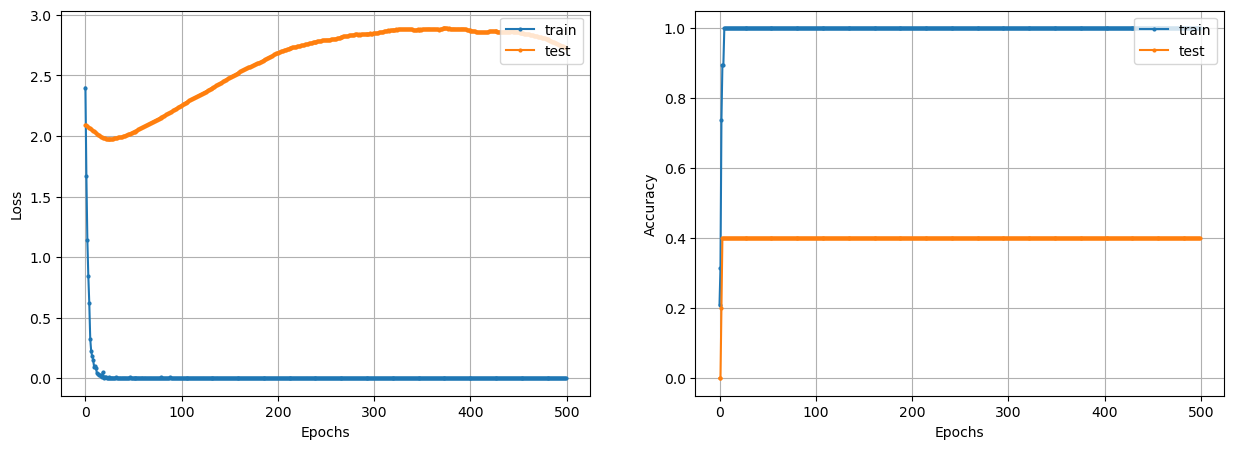

0.4000000059604645 1.9748108386993408


In [15]:
import random
pat = './performance_eval/'

ROW = 3 #select Best row here

for subject in range(5,6):
    for no_sen in range(6,16):
        LST_sensor = []
        for i in range(128):
            if i%8 == ROW:
                LST_sensor.append(i)
            
        for j in range(no_sen):
            LST_sensor.remove(random.choice(LST_sensor))

        print("Start subject {}, Len: {}\n======================================================\n\n".format(subject, len(LST_sensor)))
        df = build_df(LST_sensor, subject)
        graph, graph_info, x_train, y_train = build_graph_works_larger_than_16(df, LST_sensor)
        #draw_graph(graph)

        gnn_model = build_gnn_model(graph_info, num_classes, hidden_units, dropout_rate)

        val = gnn_model.fit(x=x_train, y=y_train, epochs=500, batch_size=batch_size, validation_split=0.2,
                            #callbacks=[lr_scheduler,early_stopping],
                            verbose = 0)

        plot(val)

        ACC = val.history['val_acc']
        LOSS = val.history['val_loss']
        print(np.max(ACC), np.min(LOSS))
        pd.DataFrame(ACC).to_csv(pat+'S{}/val_acc_missing_sensors_{}.csv'.format(subject, no_sen))
        pd.DataFrame(LOSS).to_csv(pat+'S{}/val_loss_missing_sensors_{}.csv'.format(subject, no_sen))

Start subject 18, Len: 128


Edges shape: (2, 25456)      Nodes shape: (3072, 1000)


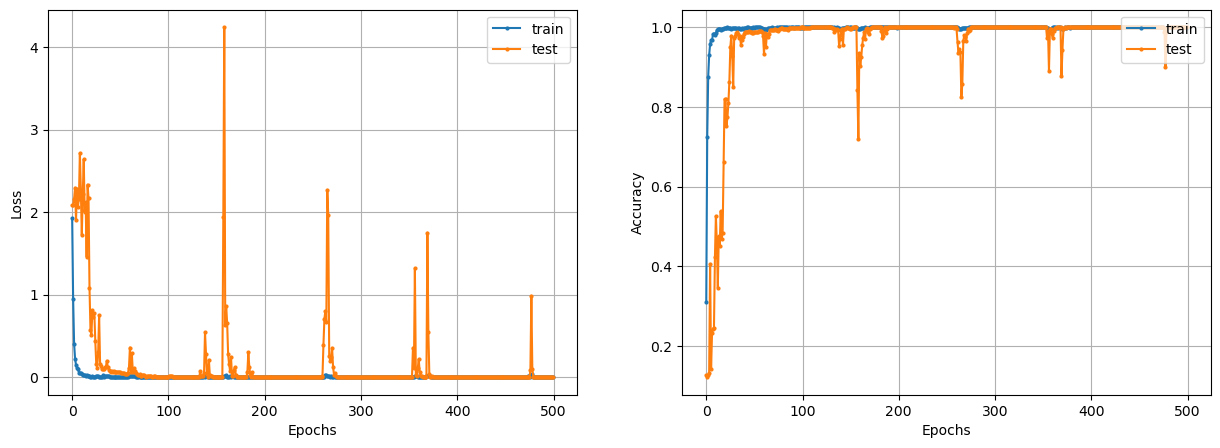

Start subject 18, Len: 103


Edges shape: (2, 20585)      Nodes shape: (2472, 1000)


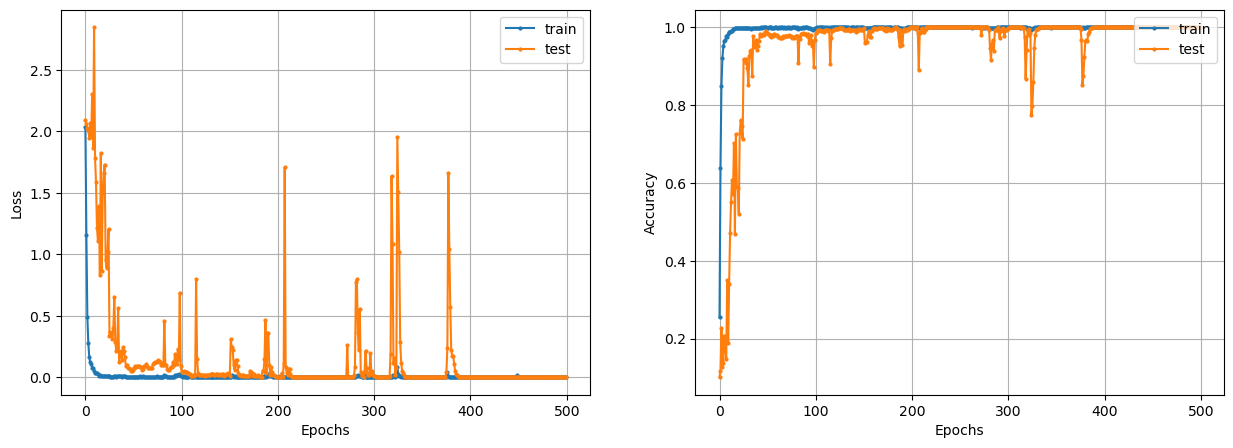

Start subject 18, Len: 78


Edges shape: (2, 15642)      Nodes shape: (1872, 1000)


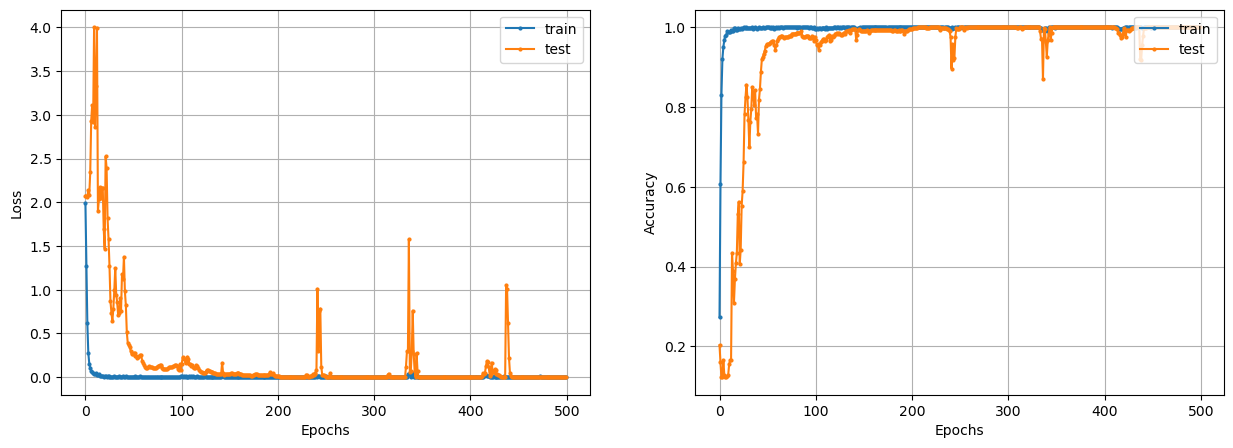

Start subject 18, Len: 53


Edges shape: (2, 10699)      Nodes shape: (1272, 1000)


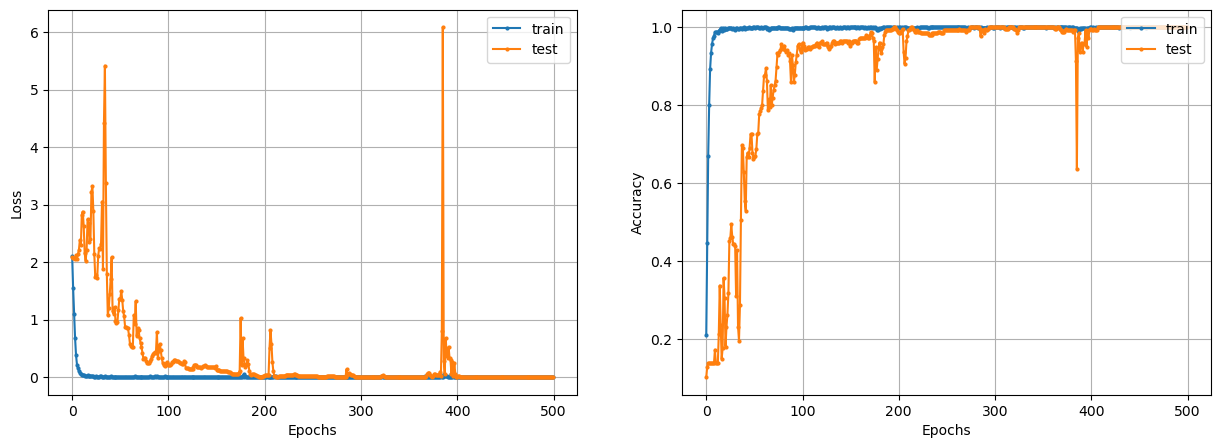

Start subject 18, Len: 28


Edges shape: (2, 5756)      Nodes shape: (672, 1000)


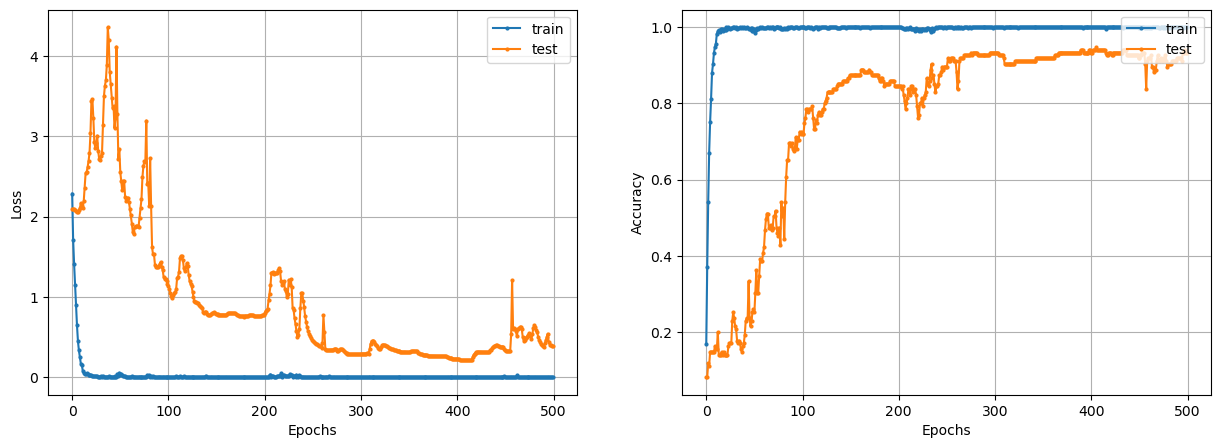

Start subject 19, Len: 128


Edges shape: (2, 25456)      Nodes shape: (3072, 1000)


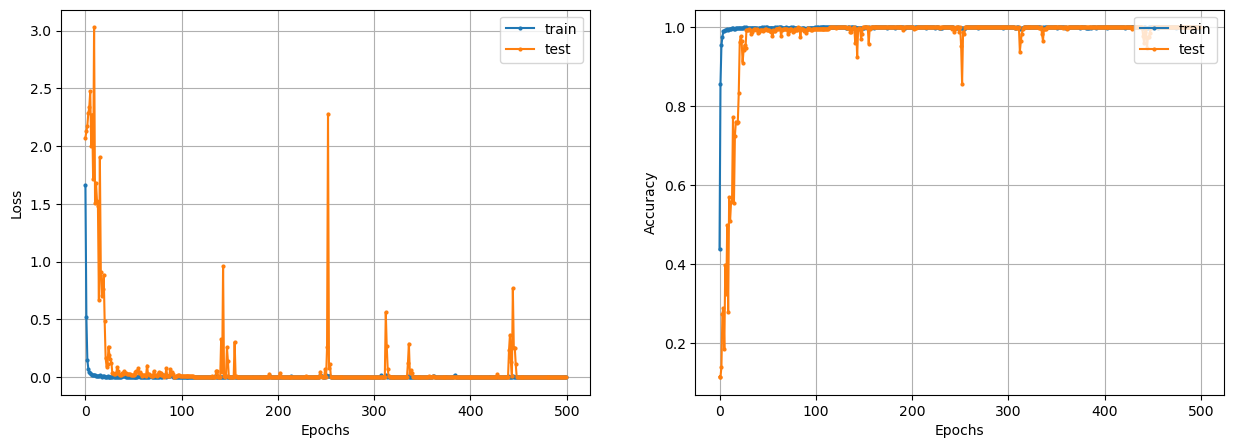

Start subject 19, Len: 103


Edges shape: (2, 20585)      Nodes shape: (2472, 1000)


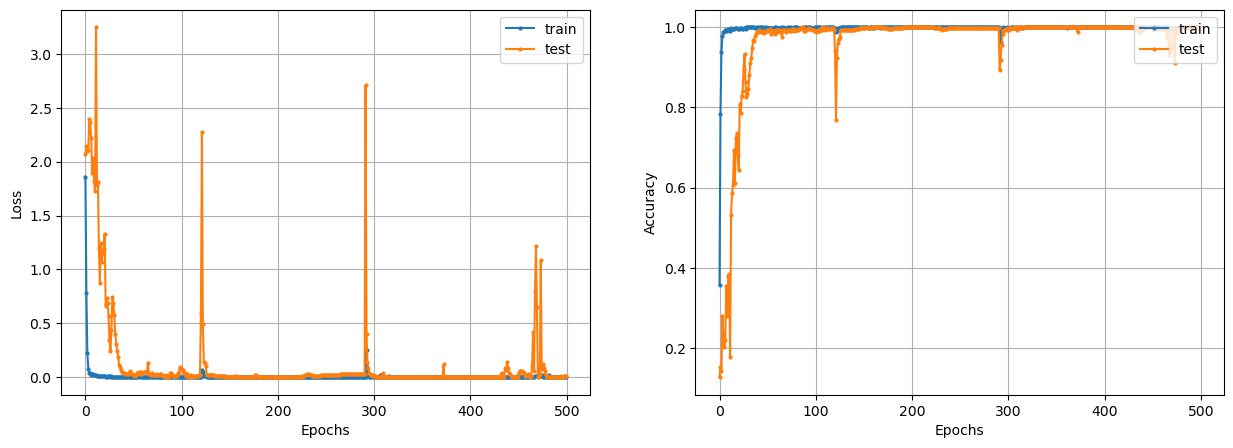

Start subject 19, Len: 78


Edges shape: (2, 15642)      Nodes shape: (1872, 1000)


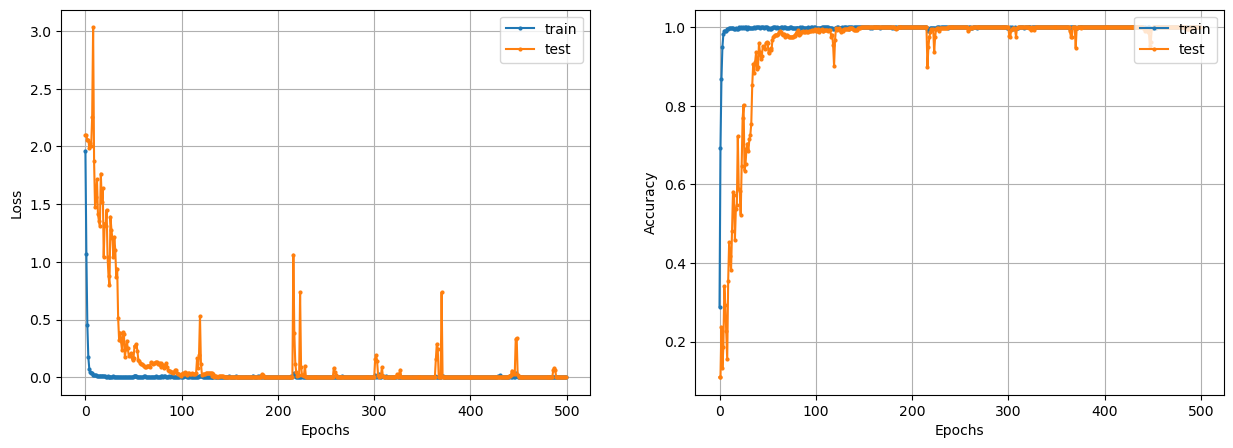

Start subject 19, Len: 53


Edges shape: (2, 10699)      Nodes shape: (1272, 1000)


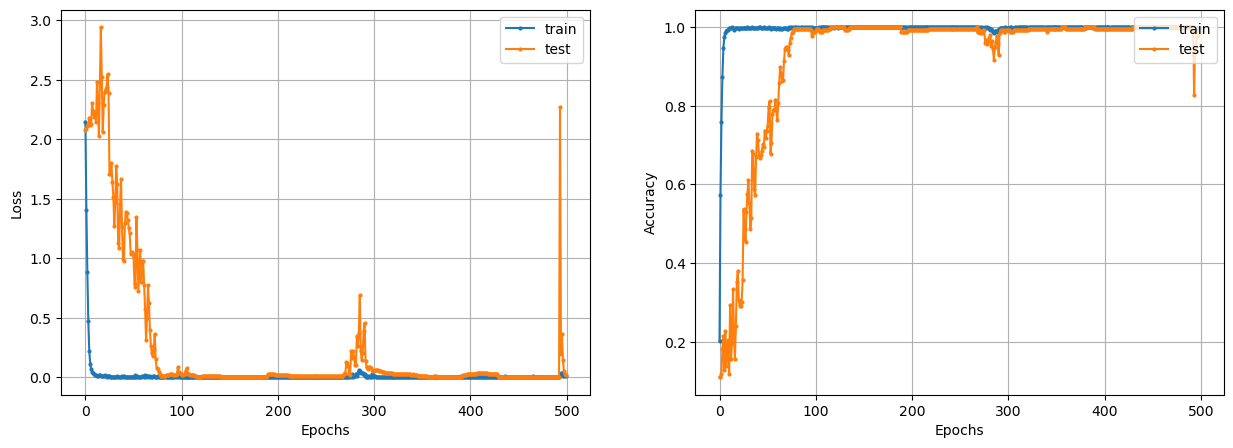

Start subject 19, Len: 28


Edges shape: (2, 5756)      Nodes shape: (672, 1000)


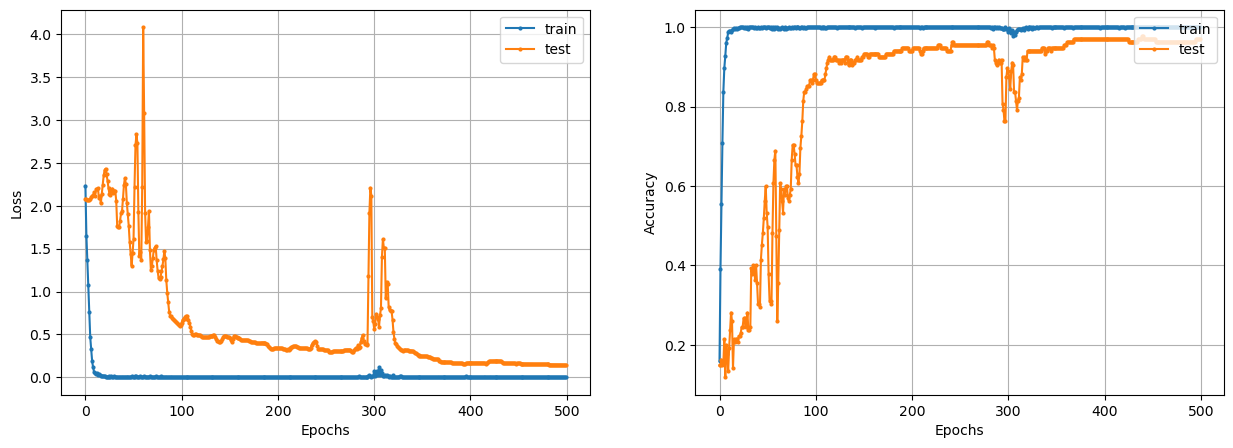

Start subject 20, Len: 128


Edges shape: (2, 25456)      Nodes shape: (3072, 1000)


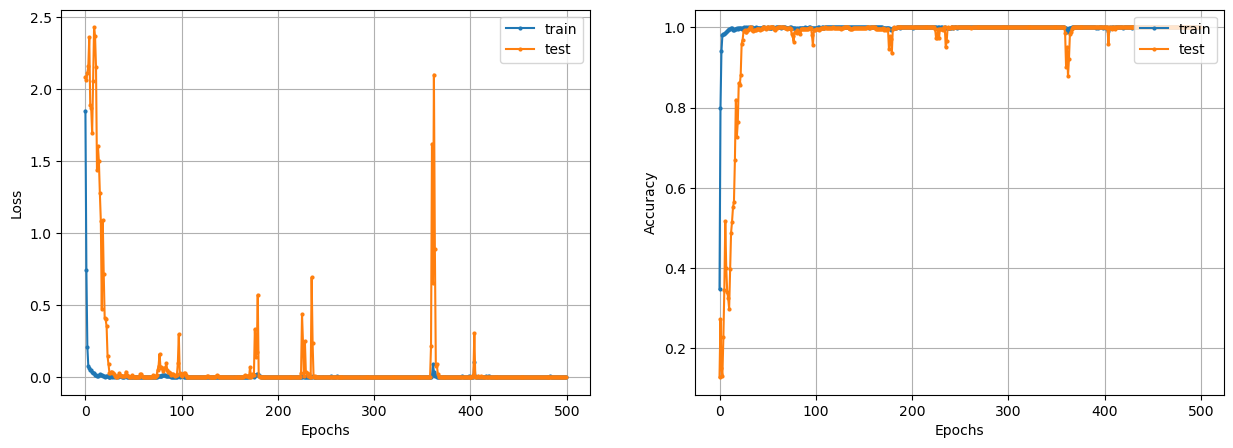

Start subject 20, Len: 103


Edges shape: (2, 20585)      Nodes shape: (2472, 1000)


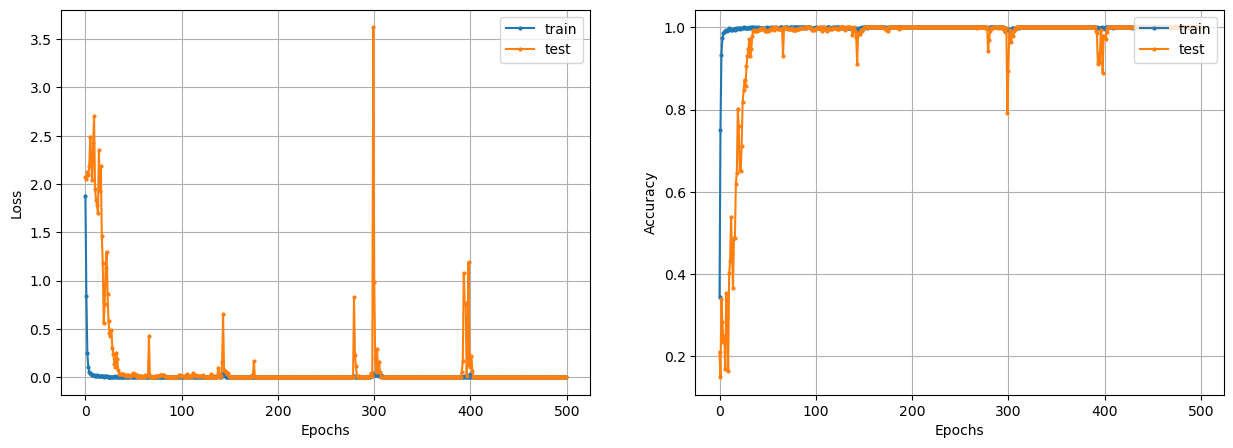

Start subject 20, Len: 78


Edges shape: (2, 15642)      Nodes shape: (1872, 1000)


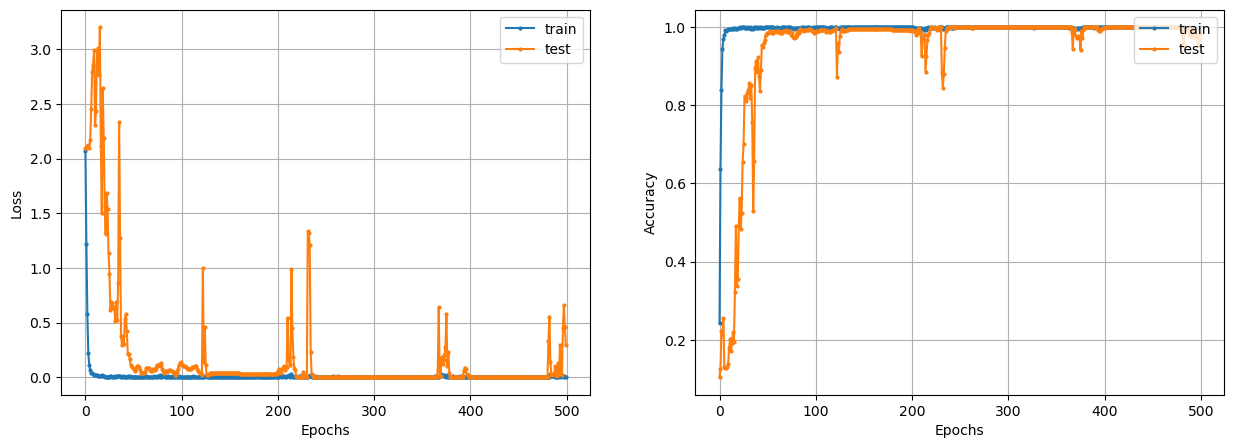

Start subject 20, Len: 53


Edges shape: (2, 10699)      Nodes shape: (1272, 1000)


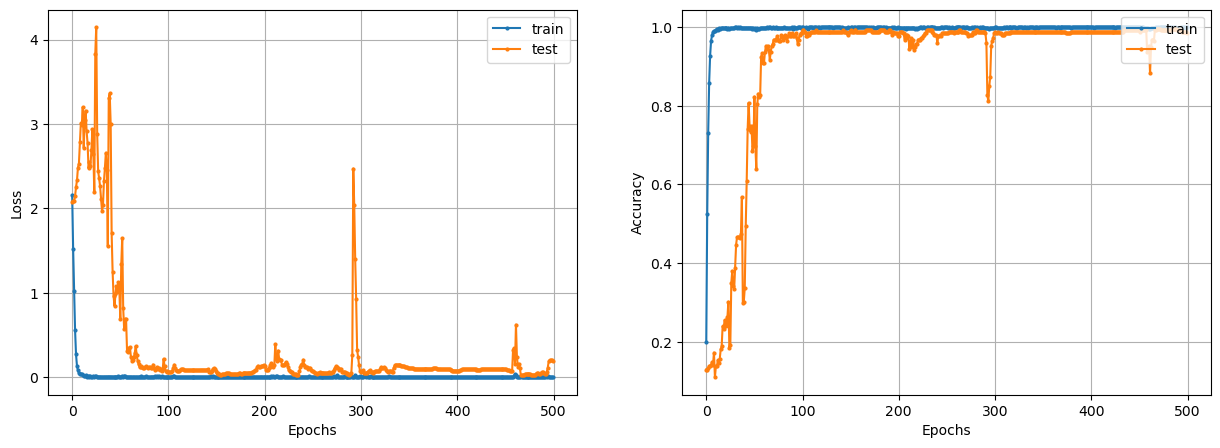

Start subject 20, Len: 28


Edges shape: (2, 5756)      Nodes shape: (672, 1000)


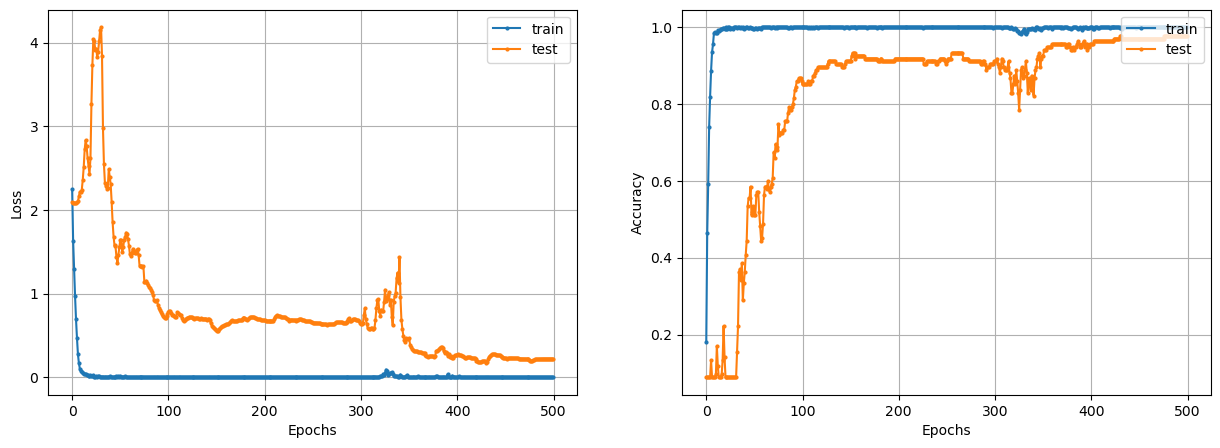

In [13]:
pat = './performance_eval/'

for subject in range(18,21):
    all_lst = np.arange(128).tolist()
    for no_sen in range(5):

        if no_sen == 0: pass
        elif no_sen == 5:
            for i in range(28): all_lst.remove(random.choice(all_lst))
                
        else:
            for i in range(25): all_lst.remove(random.choice(all_lst))                
        
        print("Start subject {}, Len: {}\n===========================================\n\n".format(subject, len(all_lst)))
        df = build_df(all_lst, subject)
        graph, graph_info, x_train, y_train = build_graph_works_larger_than_16(df, all_lst)

        gnn_model = build_gnn_model(graph_info, num_classes, hidden_units, dropout_rate)

        val = gnn_model.fit(x=x_train, y=y_train, epochs=500, batch_size=batch_size, validation_split=0.2,
                        #callbacks=[lr_scheduler,early_stopping],
                        verbose = 0)

        plot(val)
        ACC = val.history['val_acc']
        LOSS = val.history['val_loss']

        pd.DataFrame(ACC).to_csv(pat+'S{}/val_acc_having_sensors{}.csv'.format(subject, len(all_lst)))
        pd.DataFrame(LOSS).to_csv(pat+'S{}/val_loss_having_sensors{}.csv'.format(subject, len(all_lst)))